In [ ]:
#combined imports
import numpy as np
import matplotlib.pyplot as plt
import photutils
from photutils.datasets import make_noise_image
from photutils.psf import CircularGaussianPRF, make_psf_model_image
from photutils.psf import PSFPhotometry
from photutils.psf import SourceGrouper
from photutils.background import LocalBackground, MMMBackground
from photutils.background import Background2D, MedianBackground
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy.table import QTable
from astropy.stats import sigma_clipped_stats
from skimage.morphology import skeletonize
from threading import local
import cv2
import copy

#imports
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
import AnalysisFuncs as AF
import matplotlib.pyplot as plt
import cv2
from reproject import reproject_exact, reproject_adaptive, reproject_interp


In [42]:
def cropNanBorder(image, expected_shape):

    """
    Crop the nan border away such that the image fits the expected shape

    Parameters: 
    -image (float): The data to crop. 2D array. 
    -expected_shape (int): the expected shape to crop the data into. 2 element tuple. 

    Returns: 
    - returns the cropped image
    """

    # Create a mask of non-NaN values
    mask = ~np.isnan(image)
    
    # Find the rows and columns with at least one non-NaN value
    non_nan_rows = np.where(mask.any(axis=1))[0]
    non_nan_cols = np.where(mask.any(axis=0))[0]

    # Use the min and max of these indices to slice the image
    cropped_image = image[non_nan_rows.min():non_nan_rows.max() + 1, non_nan_cols.min():non_nan_cols.max() + 1]
    
    # Get the current shape of the cropped image
    current_shape = cropped_image.shape
    
    # Check if the cropped image needs to be resized
    if current_shape != expected_shape:
        # Pad or crop to reach the expected shape
        padded_image = np.full(expected_shape, np.nan)  # Initialize with NaNs
        
        # If cropped_image is larger than expected_shape, trim it
        trim_rows = min(current_shape[0], expected_shape[0])
        trim_cols = min(current_shape[1], expected_shape[1])
        
        # Center the cropped image within the expected shape
        start_row = (expected_shape[0] - trim_rows) // 2
        start_col = (expected_shape[1] - trim_cols) // 2
        
        # Place the trimmed or centered cropped_image in the padded_image
        padded_image[start_row:start_row + trim_rows, start_col:start_col + trim_cols] = \
            cropped_image[:trim_rows, :trim_cols]
        
        return padded_image
    
    return cropped_image

Set DATE-AVG to '2022-07-17T12:01:53.586' from MJD-AVG.
Set DATE-END to '2022-07-17T12:54:46.016' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.754891 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738895745.206 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(2600, 1891)
(2600, 1891)
(2600, 1891)
(2600, 1891)


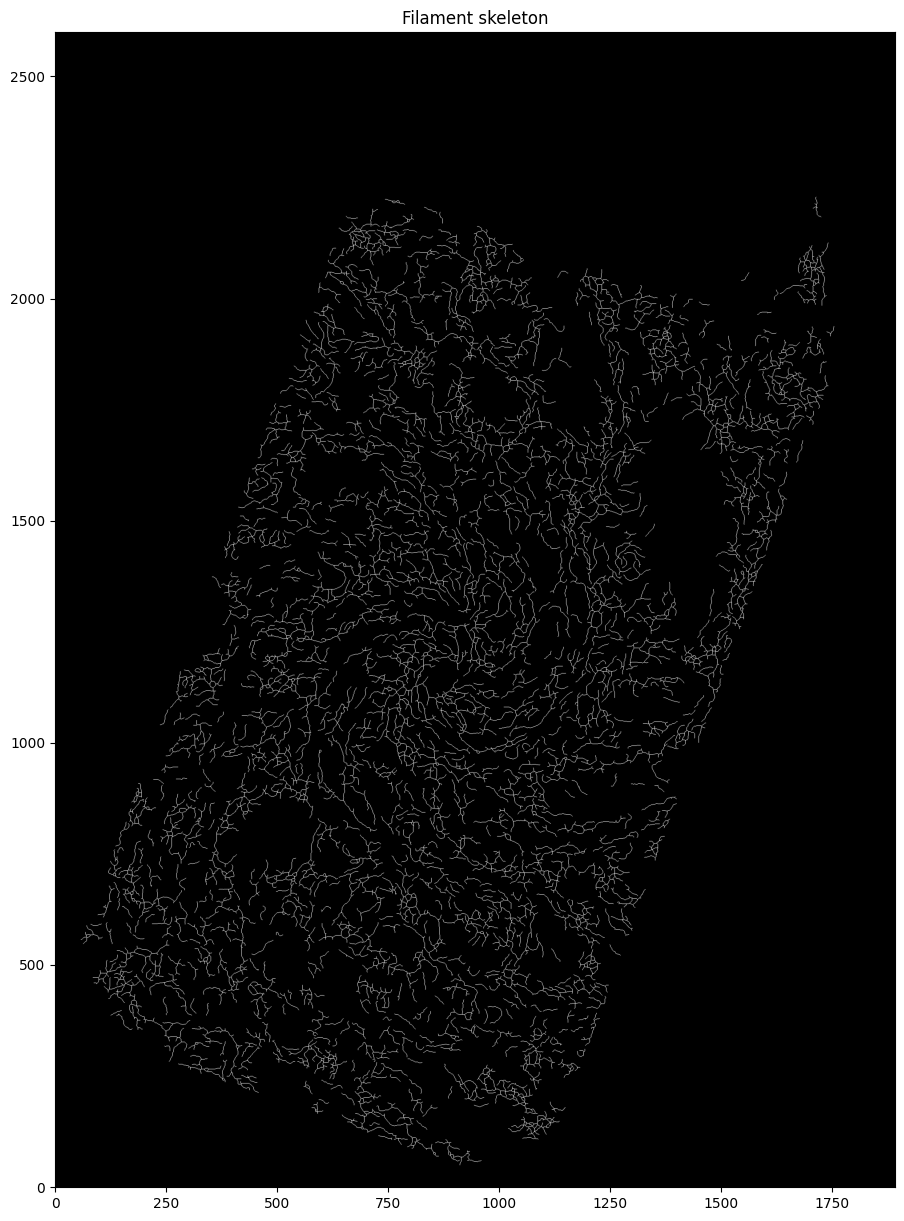

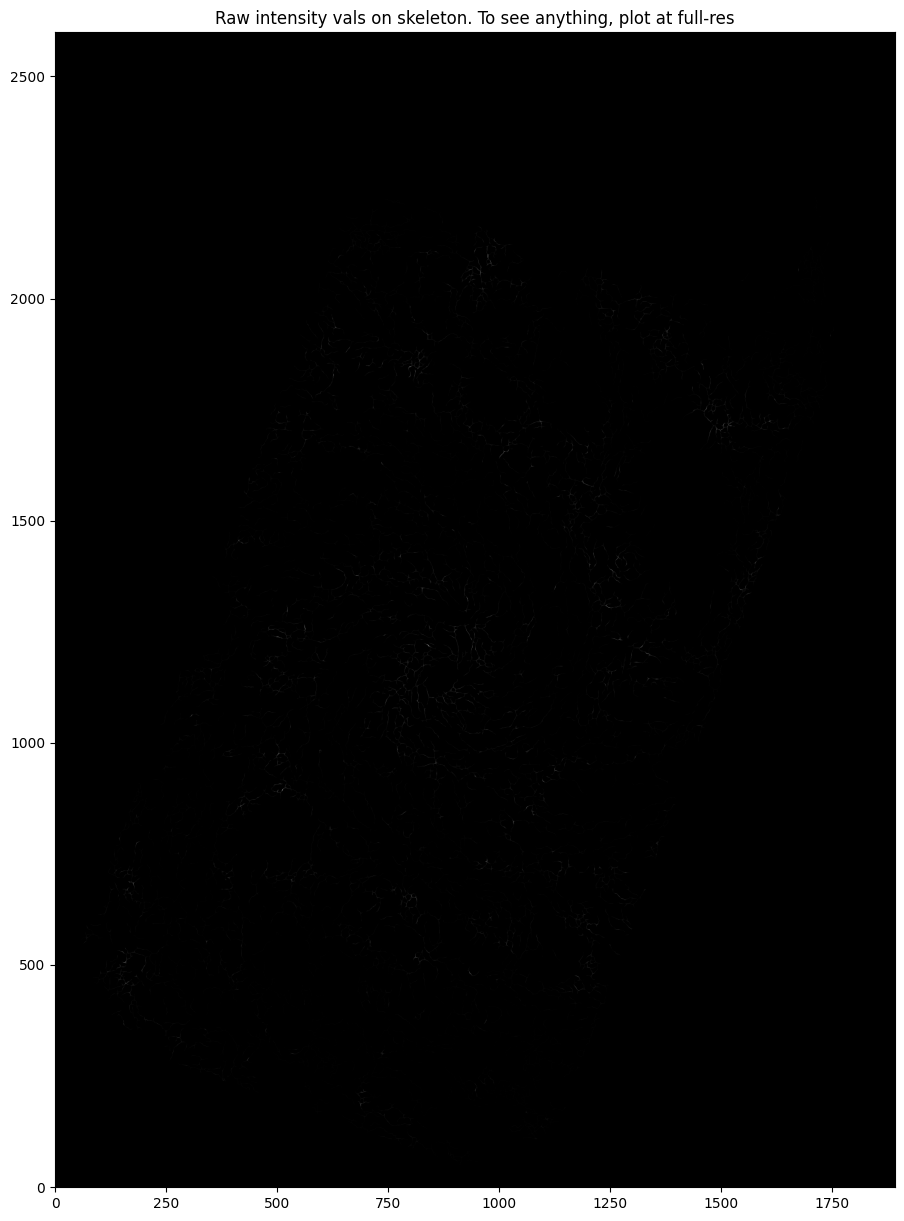

In [43]:
# set the FWHM of the filament in pixels
fwhmval=3.0 #16pc scale at 5.24 parcecs per pixel --> ~3 pixels   (!!!!will vary)

docutout=False
cutout_center=(875,1050)
cutout_size=(400,800)
#cutout_size=(1000,800)

#Composite skeleton from SOAX. Gives coordinates of sources in model
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/Composites/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc_Composites.fits"
with fits.open(original_image_path) as hdul:
    coords_data = hdul[0].data
    header_1 = hdul[0].header
    wcs_1 = WCS(header_1)


#allow cutout
print(np.shape(coords_data))
if docutout:
  cutout = Cutout2D(coords_data, cutout_center, cutout_size, wcs=wcs_1)
  coords_data = cutout.data
  header_1 = cutout.wcs.to_header()
print(np.shape(coords_data))


#Point-source removed single scale image
# original_image_path =  "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0016pc.fits"
original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/Code/PHANGSDustFill/Identification/ngc0628_drawinfill_16pc_sourceRemovalForSyntheticMaps_1.fits"
# original_image_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_F770W/CDD/ngc0628_F770W_JWST_Emission_starsub_CDDss0064pc.fits"

with fits.open(original_image_path) as hdul:
    data = hdul[0].data
    header_2 = hdul[0].header
    data = data[0]
odata= copy.deepcopy(data) #preserve original image

coords_data_copy = copy.deepcopy(coords_data) #preserve original image



#allow cutout
print(np.shape(data))
if docutout:
  cutout = Cutout2D(data, cutout_center, cutout_size, wcs=wcs_1)
  data = cutout.data
  header_1 = cutout.wcs.to_header()
print(np.shape(data))

#Dilate the composite map from soax and then skeletonize to get smooth, 1 pixel wide, filaments for the PSF model
data[np.isnan(data)] = 0
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.morphologyEx(coords_data, cv2.MORPH_CLOSE, kernel)
dilated_image = skeletonize(dilated_image)
coords_data= dilated_image.astype(np.uint8)

#retrieve intensity in the point-source removed single scale image _along_the_skeleton_
#will be scaled in various ways below to account for cumulative contribution from adjacent overlapping models, and the peak pix vs. integrated model issue


# BlockFactor = 4
# BlockHeader = header_1.copy() #updated later
# BlockData = np.zeros((int(data.shape[0] / BlockFactor), int(data.shape[1] / BlockFactor))) 

# BlockHeader['CDELT1'] = (header_1['CDELT1']) * BlockFactor
# BlockHeader['CDELT2'] = (header_1['CDELT2']) * BlockFactor
# BlockHeader['CRPIX1'] = (header_1['CRPIX1']) / BlockFactor 
# BlockHeader['CRPIX2'] = (header_1['CRPIX2']) / BlockFactor 

# data, _ = reproject_interp((data, header_1), BlockHeader, shape_out=(np.shape(BlockData)))
# coords_data, _ = reproject_interp((coords_data, header_1), BlockHeader, shape_out=(np.shape(BlockData)))
# data = cropNanBorder(data, np.shape(BlockData))
# coords_data = cropNanBorder(coords_data, np.shape(BlockData))

intensity_data = copy.deepcopy(data)
intensity_data[coords_data==0] = 0.
intensity_data[coords_data>0] = data[coords_data>0]

plt.figure(figsize=(15, 15))
plt.imshow(coords_data, origin='lower', cmap='gray')
plt.title('Filament skeleton')
plt.show()
plt.figure(figsize=(15, 15))
plt.imshow(intensity_data, origin='lower', cmap='gray')
plt.title('Raw intensity vals on skeleton. To see anything, plot at full-res')
plt.show()



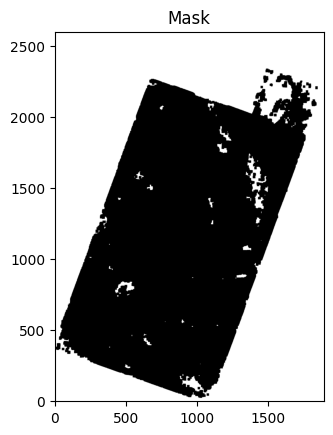

background box size=  15  then the grid of box (bkg and noise) results 2d-medianed with  3  x  3  operator
median large scale background =  0.0
median large scale noise  =  0.11140794594754025


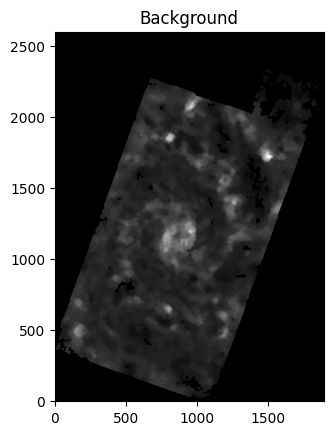

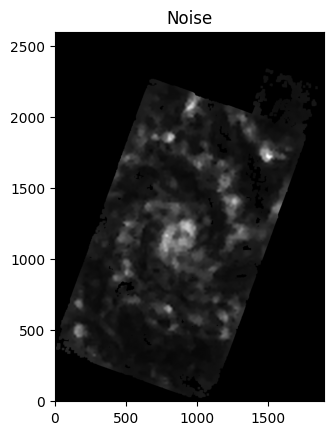

In [44]:
#create a mask indicating which pixels in data to ignore
#must also determine uncertainty in data and subtract any large-scale background emission left in single-scale image

threshold = 10**-20 #pixels below this value will be seeds for mask
Scalepix = 5.24  #pc/pix in the data  (!!!adjust/set with various galaxies, and perhaps with different single-scale maps e.g. if blocked)
noise_min = 10**-2  #noise values that are estimated too low will be set to this value


#----------------------------------make mask------------------------
data_to_mask = data
mask_copy = copy.deepcopy(data_to_mask)

#Dilate White Pixels
mask_copy[mask_copy > threshold] = 255
mask_copy = mask_copy.astype(np.uint8)
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_image = cv2.dilate(mask_copy, kernel, iterations= 5)

#threshold other way
copy_image = copy.deepcopy(data_to_mask).astype(np.float32)
copy_image[dilated_image < threshold] = np.nan
mask = np.isnan(copy_image)

#set up binary mask
binary_mask = np.zeros_like(copy_image, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

#dilate the mask
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

dilated_image = copy.deepcopy(data_to_mask).astype(np.float32)
dilated_image[dilated_mask==255] = np.nan

#make a mask based on dilated image, true value indicates pixel should be masked
mask = np.isnan(dilated_image)
assert(not np.isnan(mask).any())
plt.imshow(mask, origin='lower', cmap='gray')
plt.title('Mask')
plt.show()


#--------------determine large scale background and noise variations-------------

#subtract bkg
bkg_estimator = MedianBackground()

#set box size
box_size = round(4.5*fwhmval/2)*2+1
#set filter size (number of boxes)
filter_size = 3
print('background box size= ',box_size,' then the grid of box (bkg and noise) results 2d-medianed with ',filter_size,' x ',filter_size,' operator')

# if(box_size < .02* np.min((np.shape(data)[0], np.shape(data)[1]))):
#     print("Correcting box size")
#     box_size = int(.02*np.min((np.shape(data)[0], np.shape(data)[1]))) * 2 + 1 #Make box 2% of smaller image dimension...appears to work well

bkg = Background2D(data, box_size=box_size, coverage_mask = mask, exclude_percentile = 11, filter_size=(filter_size,filter_size), bkg_estimator=bkg_estimator) #Very different RMS with mask. Minimum noise is MUCH larger.

data -= bkg.background #subtract bkg
print('median large scale background = ', np.median(bkg.background[data>=0]))
data[data < 0] = 0 #Elimate neg values since this is over estimating the background.

noise = bkg.background_rms
print('median large scale noise  = ', np.median(noise[(data>=0)&(noise>=noise_min)]))
noise[noise < noise_min] = noise_min #replace unphysical and absent noise with 10^-3

assert(np.mean(noise !=0))


plt.imshow(bkg.background, origin='lower', cmap='gray')
plt.title('Background')
plt.show()
plt.imshow(noise, origin='lower', cmap='gray')
plt.title('Noise')
plt.show()

#data is background subtracted and noise array generated; odata still retains the background
del data_to_mask
del mask_copy
del copy_image
del binary_mask
del dilated_mask

Max of single model, and sum of single model: 0.09320139311474838 0.9991760284426763


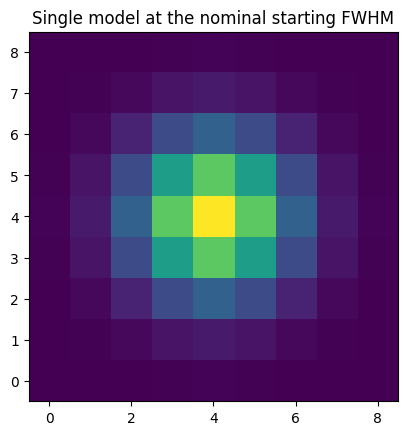

Max of composite model, and sum of composite filament-like model: 0.30528892954779896 8.94015554856643


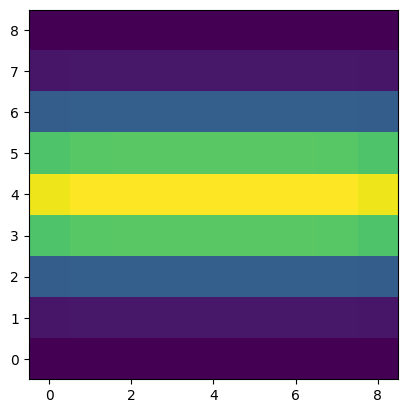

expected reduction factor from ridge-line peak values to single Gaussian peak in presence of neighbors:  0.305289134633216
expected increase factor from max of single Gaussian peak to integral of the complete model peak:  10.7206125901198
Net scaling factor to be applied to skeleton intensities in order to obtain first guess of model flux:  3.2728865403756338


In [45]:
#set up for forced photometry, NOT allowing positions along filament to vary (ONLY FLUX AND FWHM ALLOWED TO VARY)
#note: with the model evaluated at integer pixel positions as done below, it yields a single brightest pixel in every model realization
#whereas if the pixel positions were half-integers (e.g. x=50.5,y=900.5) there would be four central pixels equal to the max intensity
#I think this may perpetuate a little bit of the negative residual appearance at the skeleton ridge.  We might consider a post-(complete)-model-rendering smoothing (very little though)

psf_model = CircularGaussianPRF(flux=1, fwhm=fwhmval) #No longer divide fwhmval/2.35
psf_model.x_0.fixed = True #allowing this to vary when x_coords, y_coords given no intentional offset shows most would only move by ~0.125 pix, so neglect any shift
psf_model.y_0.fixed = True
psf_model.fwhm.fixed = False
psf_model.flux.min = 0. #### -1. * np.std(noise)  #keep all models positive
psf_model.fwhm.max = fwhmval * 2.0 #do not allow the fwhm to encroach into next larger single scale interval
psf_model.fixed

#needed for example rendering of model
yy, xx = np.mgrid[-4:5,-4:5]


#experiment to get flux scaling factor to convert between peak and integral (of one single model)
showpsf = psf_model(xx, yy)
print('Max of single model, and sum of single model:',np.max(showpsf),np.sum(showpsf))
plt.imshow(showpsf, origin='lower', interpolation='nearest')
plt.title('Single model at the nominal starting FWHM')
plt.show()
#experiment with overlapping models to get one of the flux scaling factors attributed to using models with spatial extent that overlap neighbors
showfil = psf_model(xx, yy) + psf_model(xx+1, yy) + psf_model(xx-1, yy) +  psf_model(xx+2, yy) + psf_model(xx-2, yy) + psf_model(xx+3, yy) + psf_model(xx-3, yy) \
        + psf_model(xx+4, yy) + psf_model(xx-4, yy) + psf_model(xx+5, yy) + psf_model(xx-5, yy) + psf_model(xx+6, yy) + psf_model(xx-6, yy)
print('Max of composite model, and sum of composite filament-like model:',np.max(showfil),np.sum(showfil))
plt.imshow(showfil, origin='lower', interpolation='nearest')
plt.show()

print('expected reduction factor from ridge-line peak values to single Gaussian peak in presence of neighbors: ', np.max(showpsf)/np.max(showfil))
print('expected increase factor from max of single Gaussian peak to integral of the complete model peak: ', np.sum(showpsf)/np.max(showpsf))
print('Net scaling factor to be applied to skeleton intensities in order to obtain first guess of model flux: ', (np.sum(showpsf)/np.max(showpsf))*(np.max(showpsf)/np.max(showfil)))

In [46]:
#Remove junctions, identify filaments with segmentation, create filament dictionary, update group_id and group_size
#remove junctions and small filaments to identify indivdual filaments

from skimage.morphology import skeletonize
import AnalysisFuncs as AF

#work with filament centers
fil_centers = copy.deepcopy(coords_data)
junctions = AF.getSkeletonIntersection(np.array(fil_centers*255))
print(len(junctions))
IntersectsRemoved = AF.removeJunctions(junctions, fil_centers, dot_size = 3) #check intersects removed
assert(np.max(IntersectsRemoved) == 1)

fil_centers = IntersectsRemoved
save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_filament_intersectsRemoved.fits"
hdu = fits.PrimaryHDU(fil_centers)  # No header passed
hdu.writeto(save_path, overwrite=True)

2202


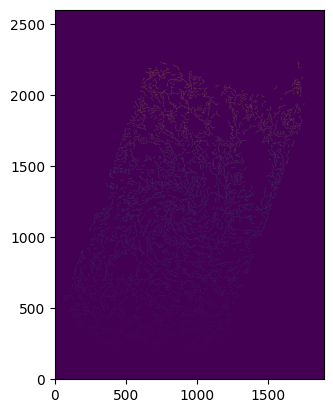

In [47]:
#use photutils segmentation to create a dictionary of filaments
#data = fil_centers
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import deblend_sources

segment_map = detect_sources(fil_centers, threshold=.5,   npixels=10)
segm_deblend = deblend_sources(fil_centers, segment_map, npixels=10, nlevels=32, contrast=0.001,progress_bar=False)
plt.imshow(segm_deblend, origin='lower')
plt.show()
save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_filament_segments.fits"
hdu = fits.PrimaryHDU(segm_deblend)  # No header passed
hdu.writeto(save_path, overwrite=True)

In [48]:
#make a dictionary of filaments
segment_info = {}

# Loop through each segment label
for label in segm_deblend.labels:
    # Find pixels that belong to this segment
    mask = segm_deblend.data == label
    coords = np.argwhere(mask)  # shape (N, 2), where each entry is (y, x)

    num_pixels = coords.shape[0]  # total number of pixels in this filament

    pixel_list = []
    for (y, x) in coords:
        pixel_value = data[y, x]  # value from the original image
        pixel_list.append((x, y, pixel_value, num_pixels))  # (x, y, value, Npix)

    segment_info[label] = pixel_list


In [ ]:
x_init = []
y_init = []
flux_init = []
group_size_init = []
group_id_init = []
for fil_id, pix_list in segment_info.items():
    for values in pix_list:
        group_id = fil_id
        x = values[0]
        y = values[1]
        flux = values[2]
        group_size = values[3]
        x_init.append(x)
        y_init.append(y)
        flux_init.append(flux)
        group_size_init.append(group_size)
        group_id_init.append(group_id)

# # Now: Add background pixels (label=0)
# ny, nx = data.shape
# for y in range(ny):
#     for x in range(nx):
#         if segm_deblend.data[y, x] == 0:  # not assigned to any segment
#             x_init.append(x)
#             y_init.append(y)
#             flux_init.append(0.0)  # flux = 0
#             group_size_init.append(0)  # group size = 0
#             group_id_init.append(0)  # group id = 0


# Create a new QTable with these coordinates
# init_params = QTable()
# init_params['x'] = x_init
# init_params['y'] = y_init
# init_params['flux'] = flux_init
# init_params['group_id'] = np.array(group_id_init).astype(np.uint8)
# init_params['id'] = np.array(group_id_init).astype(np.uint8)

# print(type(init_params['group_id']))
# init_params['group_size'] = group_size_init
# print(init_params)


: 

In [ ]:
# # # Find nonzero pixel coordinates based on output from SOAX that was skeletonized earlier
y_coords, x_coords = np.where(coords_data > 0)
init_params = QTable()
init_params['x'] = x_coords+0.0
init_params['y'] = y_coords+0.0
init_params['flux'] = data[coords_data>0]*(np.sum(showpsf)/np.max(showpsf))*(np.max(showpsf)/np.max(showfil))

# Define PSF fitting region
psf_shape = (2*int(np.ceil(fwhmval)) + 1, 2*int(np.ceil(fwhmval)) + 1)
fit_shape = psf_shape
print(f"PSF Shape: {psf_shape}")

#define this grouper to try fitting as many overlapping models together as we can
#in revision see if we can get discrete pieces of skeleton and generate groups containing all model positions in individual pieces
grouper = SourceGrouper(min_separation=1)

#stat method for estimation of local background --- independently per single model,
#but beware that the annular background area defined below will be biased by the filament running through the annulus
#and caution on how the local background is handled [included/not;incorrectforoverlap?] in generation of final complete model or residual
bkgstat = MMMBackground()
localbkg_estimator = LocalBackground(fwhmval, fwhmval+1.0, bkgstat)

psfphot = PSFPhotometry(psf_model, fit_shape, grouper = grouper, fitter_maxiters = 5) # !!! 2 iterations used, could minimally explore higher but might not be needed with good guess and could lead to divergence?

#deprecated options below-- aperture_radius irrelevant/harmful since we have a better initial flux guess; xy_bounds disabled see above rationale
#localbkg_estimator=localbkg_estimator,  aperture_radius=3, xy_bounds=0.33

# Perform PSF model fitting to filament
# data[coords_data == 0] = 0 #mask out background
print(np.shape(init_params))
phot = psfphot(data, error=noise, init_params=init_params)
print(phot[('id', 'x_init', 'x_fit', 'y_init', 'y_fit', 'flux_init', 'flux_fit', 'group_id')])
print(phot[('id', 'flux_init', 'flux_fit', 'group_id', 'group_size')])

plt.hist(phot['group_size'], bins=100)
plt.title('Group size')
plt.show()

PSF Shape: (7, 7)
(96629,)


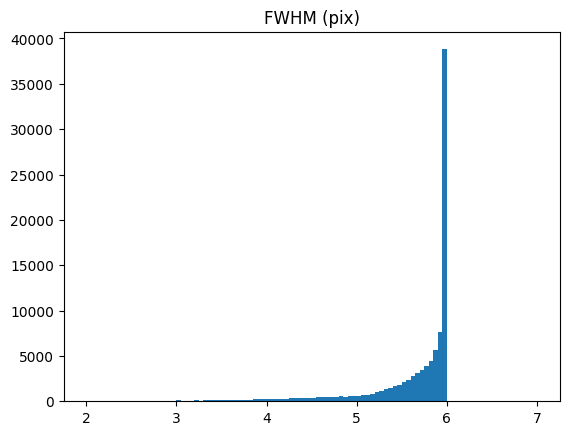

counting: 0


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_2292/3309410106.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.hist(phot['flux_fit']/phot['flux_init'], bins=100,range=(0,5)) #what causes some 0 flux_fit/flux_init values --> There are no zeros


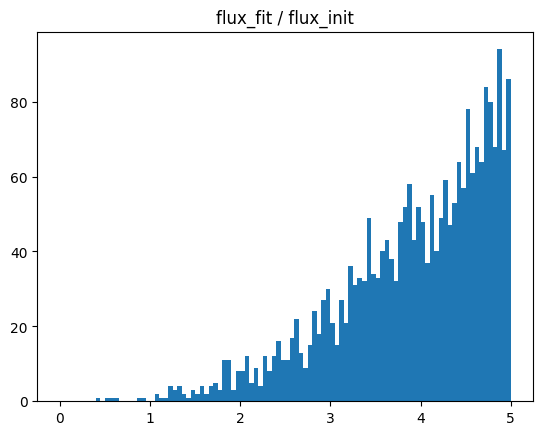

In [ ]:
plt.hist(phot['fwhm_fit'], bins=100,range=(2,7))
plt.title('FWHM (pix)')
plt.show()
plt.hist(phot['flux_fit']/phot['flux_init'], bins=100,range=(0,5)) #what causes some 0 flux_fit/flux_init values --> There are no zeros
print('counting:', np.sum(phot['flux_fit'] == 0))
plt.title('flux_fit / flux_init')
plt.show()
#NOTE!!! The tendency for this distribution to have values of about 2 (and the higher tail) is not completely understood yet. At one point I thought
#it might be due to groups being fit separately though part of the same filament, but this doesn't make sense either

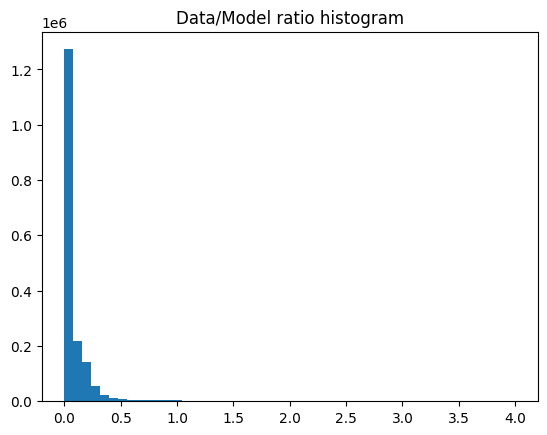

median ratio: 0.0


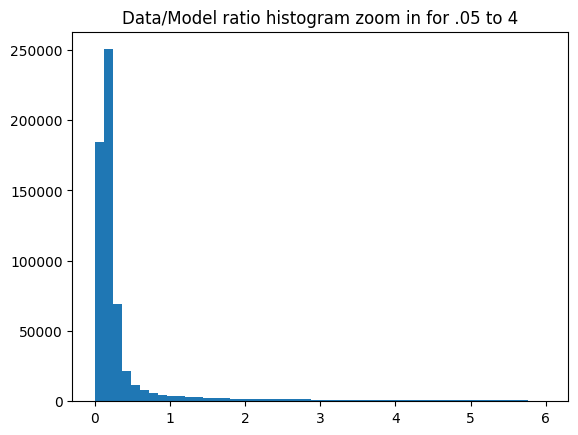

.05 to 4 median ratio: 0.16601696509177105
0.14047487853186444 0.1356821466849376 0.05500957667329156


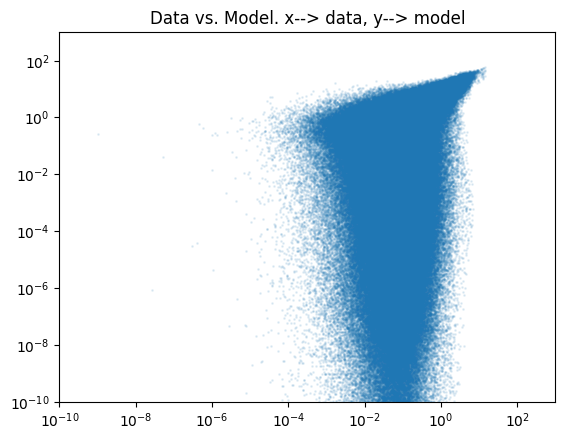

original global correction factor:  0.14509748440820894  was biased high
Useful data/model ratio based global correction factor now used:  0.1356821466849376


In [ ]:
# Compute residuals and model
resid = psfphot.make_residual_image(data)
model = (data - resid)  # Model is data minus residuals


plt.hist(data[model != 0]/model[model != 0], bins=50, range=(0,4))
plt.title('Data/Model ratio histogram')
plt.show()
print('median ratio:', np.median(data[model != 0]/model[model != 0]))

ratio=data[model != 0]/model[model != 0]
ratiouseful=ratio[(ratio>0.05) & (ratio<6.)]
plt.hist(ratiouseful, bins=50, range=(0,6))
plt.title('Data/Model ratio histogram zoom in for .05 to 4')
plt.show()
print('.05 to 4 median ratio:', np.median(ratiouseful))

ratiomean,ratiomedian,ratiostd=sigma_clipped_stats(ratiouseful, sigma=2, maxiters=5)
print(ratiomean,ratiomedian,ratiostd)

plt.scatter(data[model != 0],model[model != 0],s=1,alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-10,1e3)
plt.ylim(1e-10,1e3)
plt.title('Data vs. Model. x--> data, y--> model')
plt.show()

#original way of judging overall scaling agreement
flux_model = np.sum(model[model != 0])
flux_original_over_filaments = np.sum(data[model != 0])
globalfactor = flux_original_over_filaments/flux_model
print('original global correction factor: ',globalfactor,' was biased high')

#instead now use the ratiomedian value from above
globalfactor=ratiomedian
print('Useful data/model ratio based global correction factor now used: ',globalfactor)

#actually scale the model
model = globalfactor * model #Scale total flux to be equivalent along filaments

#!!!might instead want to scale 'flux_fit' values then regenerate residual and model images. 
#!!!note we might also want to remove point-like sources a bit more aggressively. Agrred. 

savesuffix='_alltest'
save_path =  "ngc0628_F770W_CDDss0016pc_ModelMap_SorcesRemoved_today.fits"

# Save the model as a FITS file
hdu = fits.PrimaryHDU(model, header =header_1)
hdu.writeto(save_path, overwrite=True)

save_path =  "ngc0628_F770W_CDDss0016pc_DataMap_SorcesRemoved.fits"

# Save the model as a FITS file
hdu = fits.PrimaryHDU(data, header =header_1)
hdu.writeto(save_path, overwrite=True)

In [ ]:
# #project back
# print(np.shape(odata))
# BlockData = np.zeros((int(odata.shape[0]), int(odata.shape[1]))) 

# model, _ = reproject_interp((model, BlockHeader), header_1, shape_out=(np.shape(BlockData)))

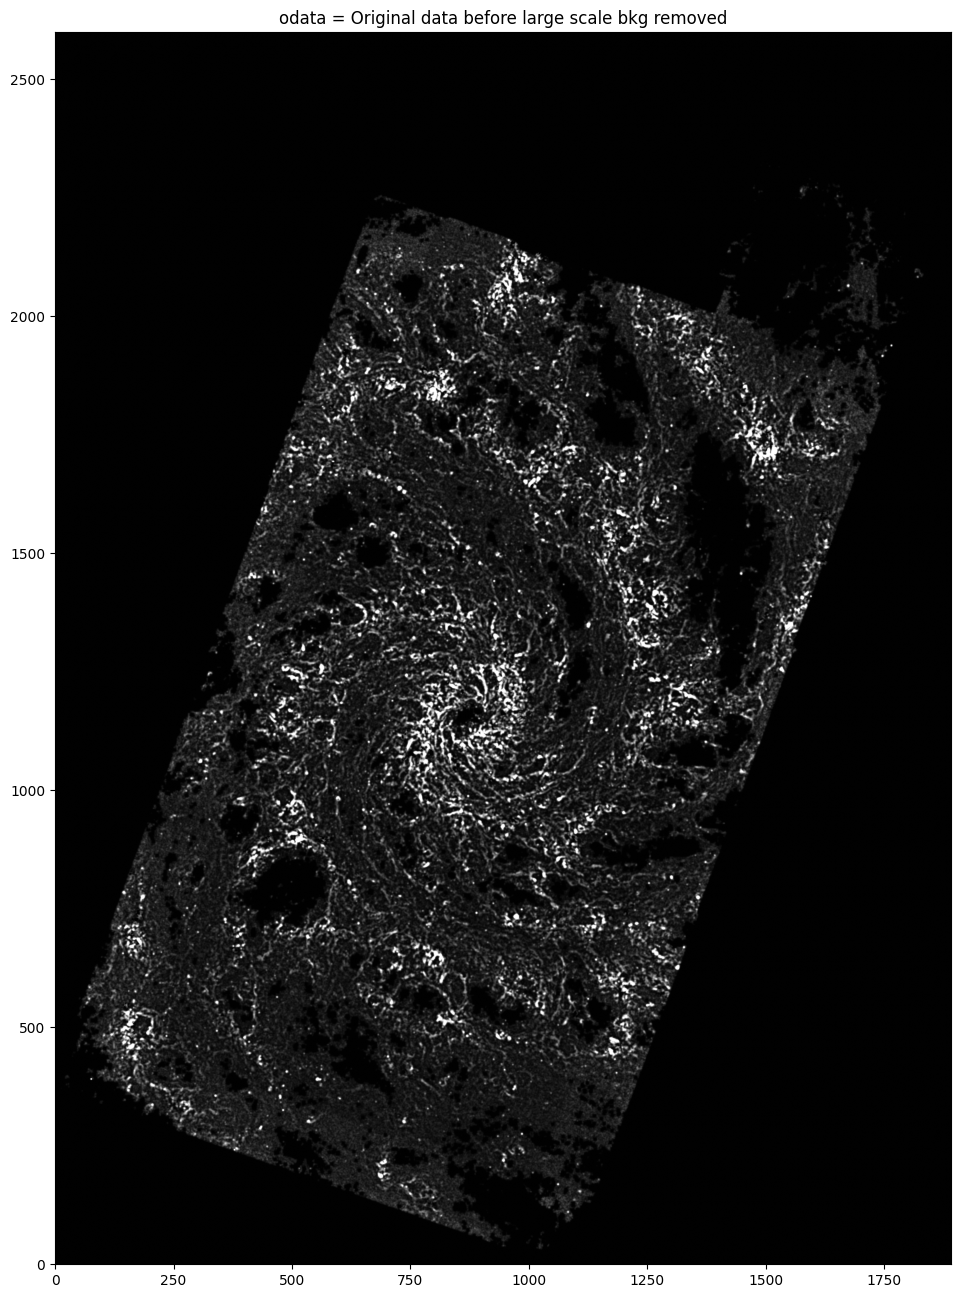

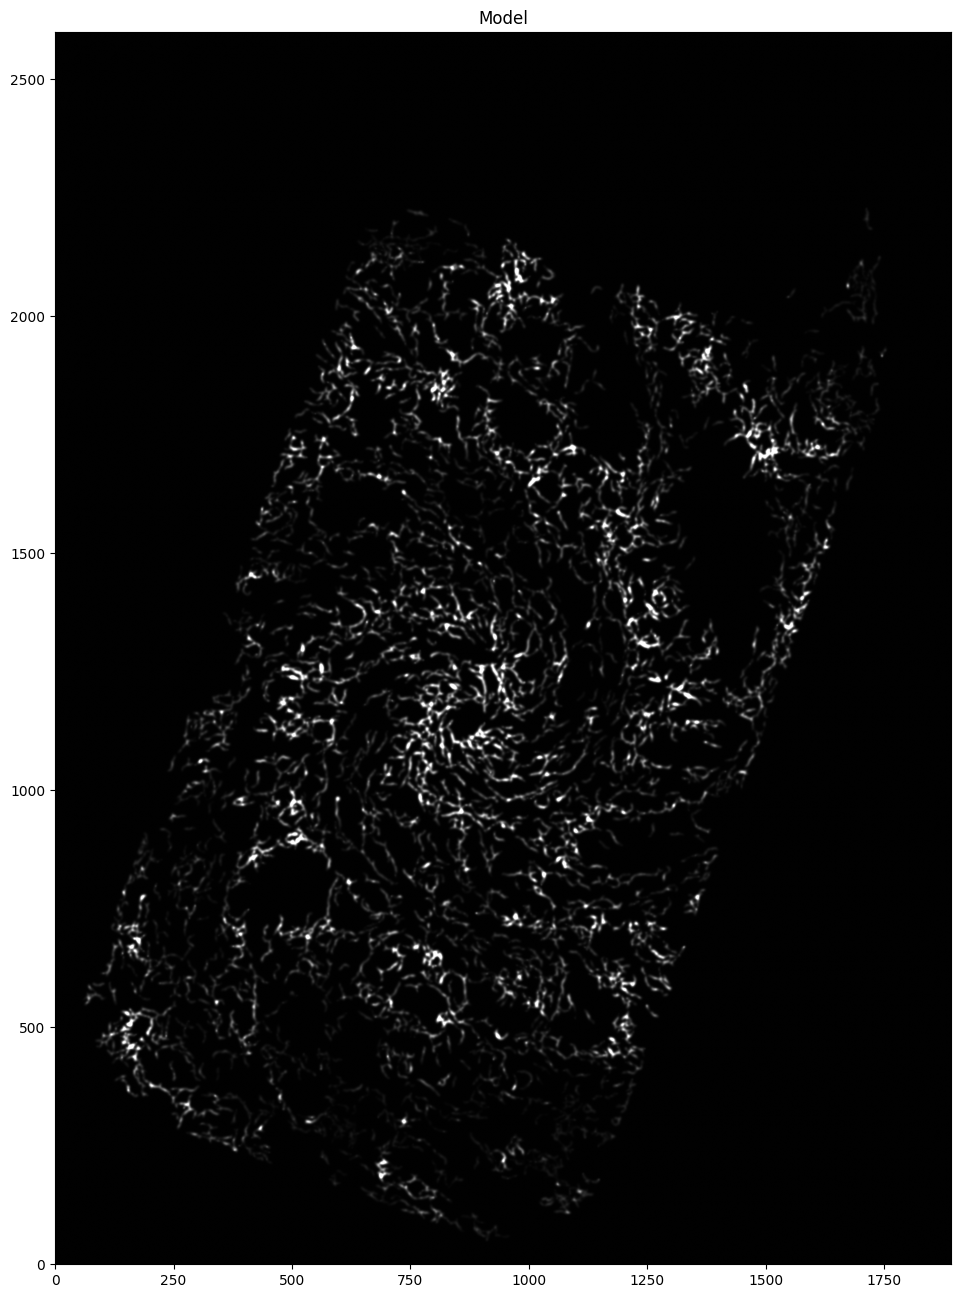

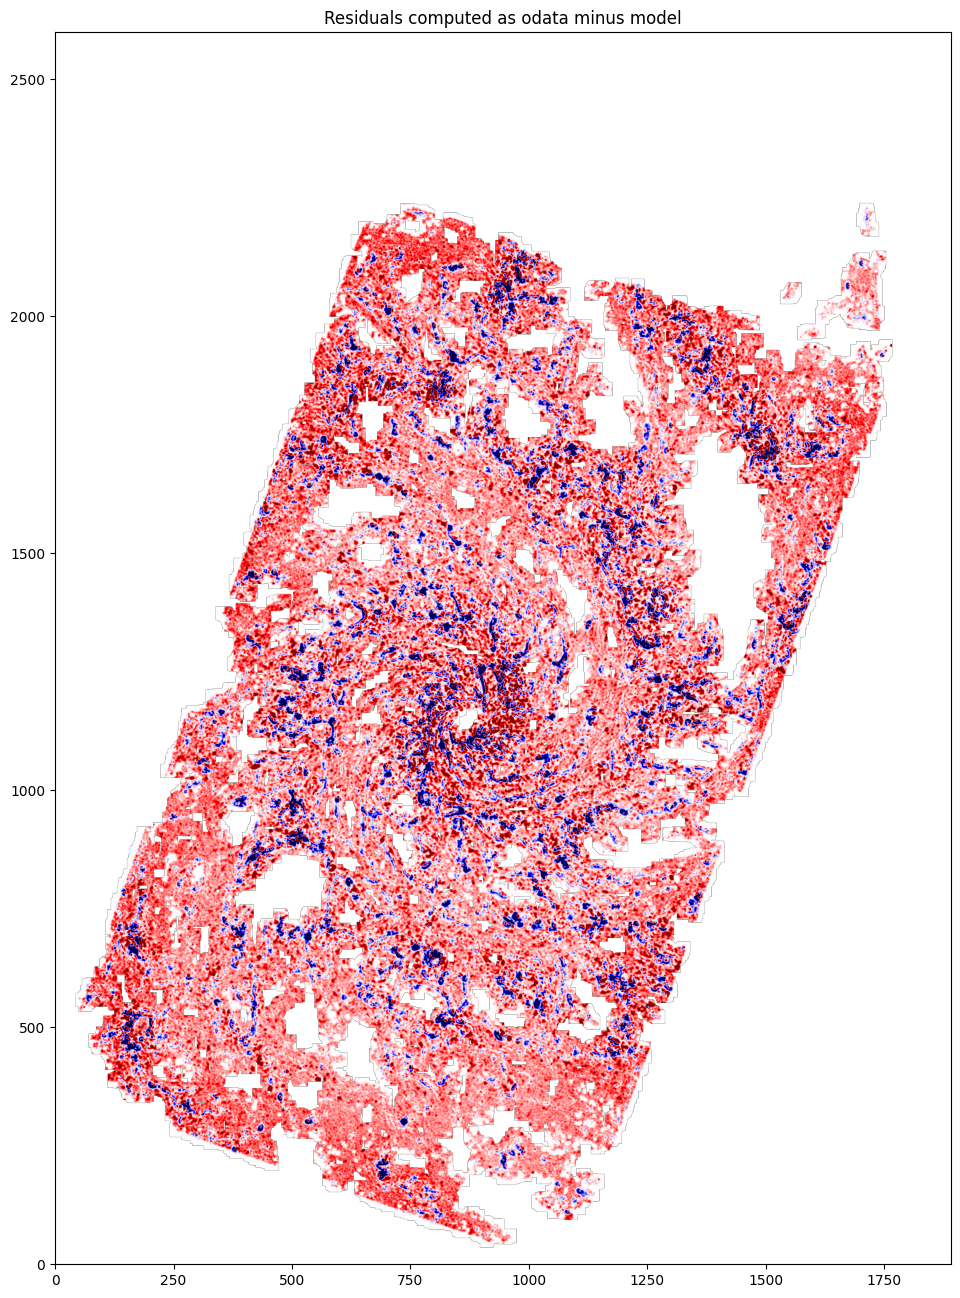

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(odata, origin='lower', cmap='gray', vmin=-1.*np.median(noise), vmax=np.percentile(odata, 99.5))
plt.title('odata = Original data before large scale bkg removed')
#plt.colorbar()
plt.show()

plt.figure(figsize=(16, 16))
plt.imshow(model, origin='lower', cmap='gray', vmin=-1.*np.median(noise), vmax=np.percentile(odata, 99.5))
plt.title('Model')
#plt.colorbar()
plt.show()

f = 1.6
sub = odata - f*model
sub[model == 0] = np.nan
plt.figure(figsize=(16, 16))
plt.imshow(sub, origin='lower', cmap='seismic', vmin=-2.*np.std(odata), vmax=2.*np.std(odata))#np.percentile(odata, 99.5))
plt.title('Residuals computed as odata minus model')
#plt.colorbar()
plt.show()

In [ ]:
#check fit quality
#recall that if flux_fit values are used in additional/future steps below that they need corrected by 'factor' above

# x_fit = phot['x_fit']
# y_fit = phot['y_fit']
# flux_fit = phot['flux_fit']

# flags = phot['flags']
# cfit = phot['cfit']
# qfit = phot['qfit']

# zero_flags = []
# zero_cfits = []
# zero_qfits = []

# flux_dict = {}
# for flags, cfits, qfits, f in zip(flags.astype(int), cfit.astype(int), qfit.astype(int), flux_fit):
#   if f == np.nan: #or ==0 or <=0
#     zero_flags.append(flags)
#     zero_cfits.append(cfits)
#     zero_qfits.append(qfits)

# print(type(zero_flags))
# print(len(zero_flags))
# print(np.median(zero_flags))
# print(np.median(zero_cfits))
# print(np.median(zero_qfits))

In [ ]:
#Ngc0628 Parameters
inclination = 9 * np.pi / 180  # Inclination in radians
sSFR = 1.74 #get specific SFR*
pc_pix = 5.24

In [ ]:
#USE FLUX MAP TO DERIVE DENSITIES INSTEAD OF OPERATING ON THE SYNTHETIC MAP DIRECTLY
#Comparisons to synthetic map/model included for sanity checks

x_fit = phot['x_fit']
y_fit = phot['y_fit']
flux_fit = phot['flux_fit']

# Optional cleaning step: only keep valid, positive fluxes
print(f'total flux of sources: {np.sum(flux_fit)} and total flux of model : {np.sum(model)}')

# Create a 2D map to associate flux values with filament spine pixels
flux_map = np.zeros_like(model, dtype=float)
for x, y, f in zip(x_fit.astype(int), y_fit.astype(int), flux_fit):
    flux_map[y, x] = f  # Note: numpy image convention is (row=y, col=x)

I_F770W_16pc = flux_map*globalfactor

I_F770W_16pc_2 = model
print(f'Initial Number of NaN values in model: {np.isnan(model).sum()}')
print(f'ratio: {np.sum(I_F770W_16pc)/np.sum(I_F770W_16pc_2)}')

save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_filament_Mass_Plot.fits"
hdu = fits.PrimaryHDU(flux_map.astype(np.uint8))  # No header passed
hdu.writeto(save_path, overwrite=True)

total flux of sources: 1771417.2819070055 and total flux of model : 240349.68327613577
Initial Number of NaN values in model: 0
ratio: 1.0000000674342642


In [ ]:
# Step 2: Apply inclination correction
I_F770W_16pc = I_F770W_16pc * np.cos(np.radians(inclination))
I_F770W_16pc_2 = I_F770W_16pc_2 * np.cos(np.radians(inclination))

print(f'step 2 ratio (sum original / model): {np.sum(I_F770W_16pc)/np.sum(I_F770W_16pc_2)}')
print(f'step 2 NaNs — I_F770W_16pc: {np.isnan(I_F770W_16pc).sum()}, I_F770W_16pc_2: {np.isnan(I_F770W_16pc_2).sum()}')

# Step 3: Estimate log(C_F770W)
log_C_F770W = -0.21 * (np.log10(sSFR) + 10.14)  
log_C_F770W_2 = -0.21 * (np.log10(sSFR) + 10.14)

# Step 4: Filter out zeros before taking log
valid_mask_1 = I_F770W_16pc > 0
valid_mask_2 = I_F770W_16pc_2 > 0

x = np.zeros_like(I_F770W_16pc)
x_2 = np.zeros_like(I_F770W_16pc_2)

x[valid_mask_1] = np.log(I_F770W_16pc[valid_mask_1]) - log_C_F770W
x_2[valid_mask_2] = np.log(I_F770W_16pc_2[valid_mask_2]) - log_C_F770W_2

print(f'step 3 NaNs — x: {np.isnan(x).sum()}, x_2: {np.isnan(x_2).sum()}')

log_I_CO_2_1_16pc = 0.88 * (x - 1.44) + 1.36
log_I_CO_2_1_16pc_2 = 0.88 * (x_2 - 1.44) + 1.36

# Avoid division by zero in ratio by adding small epsilon if needed
sum1 = np.nansum(log_I_CO_2_1_16pc)
sum2 = np.nansum(log_I_CO_2_1_16pc_2)
ratio = sum1 / sum2 if sum2 != 0 else np.nan
print(f'step 3 ratio (log I_CO): {ratio}') #ratio differs because the model has many small avlues that cintribute negatively to x_2. How to resolve this?!!

# Step 5: Exponentiate
I_CO__2_1_16pc = 10**log_I_CO_2_1_16pc
I_CO__2_1_16pc_2 = 10**log_I_CO_2_1_16pc_2

# Zero out invalid entries
I_CO__2_1_16pc[~valid_mask_1] = 0
I_CO__2_1_16pc_2[~valid_mask_2] = 0

print(f'step 4 NaNs — I_CO_16pc: {np.isnan(I_CO__2_1_16pc).sum()}, I_CO_16pc_2: {np.isnan(I_CO__2_1_16pc_2).sum()}')
print(f'step 4 ratio (final I_CO): {np.sum(I_CO__2_1_16pc)/np.sum(I_CO__2_1_16pc_2)}')


step 2 ratio (sum original / model): 1.0000000674342635
step 2 NaNs — I_F770W_16pc: 0, I_F770W_16pc_2: 0
step 3 NaNs — x: 0, x_2: 0
step 3 ratio (log I_CO): -0.09007362126998972
step 4 NaNs — I_CO_16pc: 0, I_CO_16pc_2: 0
step 4 ratio (final I_CO): 8.899115393995775


In [ ]:
#6) Calculate molecular mass and Get Density Statistics
from encodings.punycode import T

Molecular_Mass = 5.5 * I_CO__2_1_16pc #Units of Solar mass per pix^2

Total_Mass = np.sum(Molecular_Mass)

Molecular_Mass_2 = 5.5 * I_CO__2_1_16pc_2 #Units of Solar mass per pix^2
Total_Mass_2 = np.sum(Molecular_Mass_2)

print(f'final ratio: {Total_Mass/Total_Mass_2:E}')

# plt.figure(figsize = (12,12))
# # Display images
# plt.imshow(Molecular_Mass, origin='lower', cmap='plasma', norm = 'log')
# plt.title('Filament after conv+noise')
# plt.show()
# save_path = "/Users/jakehoffmann/Documents/JHU_Research/FilPHANGS_Main/ngc0628_filament_Mass_Plot.fits"
# hdu = fits.PrimaryHDU(Molecular_Mass.astype(np.uint8))  # No header passed
# hdu.writeto(save_path, overwrite=True)

final ratio: 8.899115E+00


<>:58: SyntaxWarning: invalid escape sequence '\o'
<>:58: SyntaxWarning: invalid escape sequence '\o'
/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_2292/3623306627.py:58: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Surface Density (M$_\odot$/pc²)")


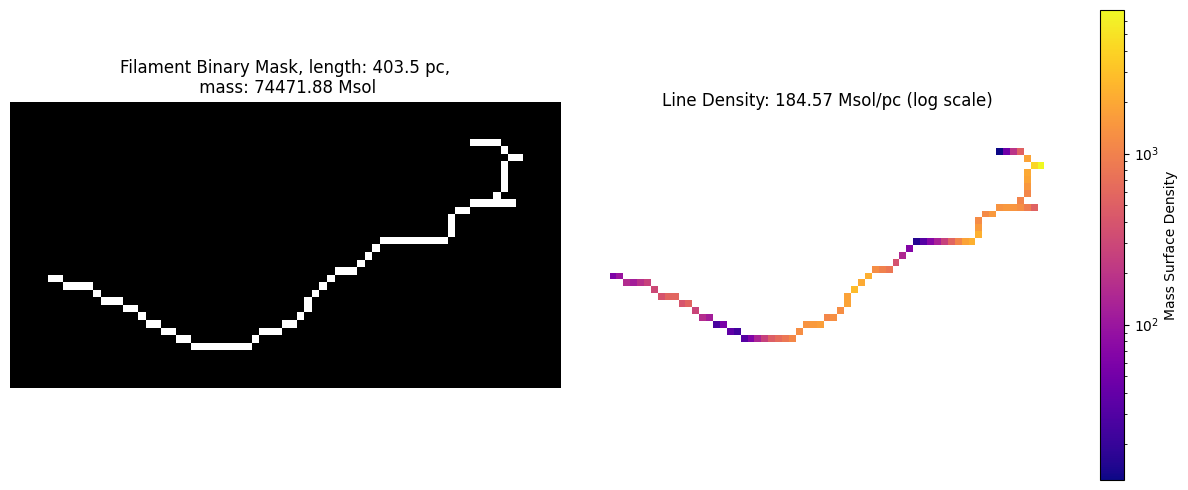

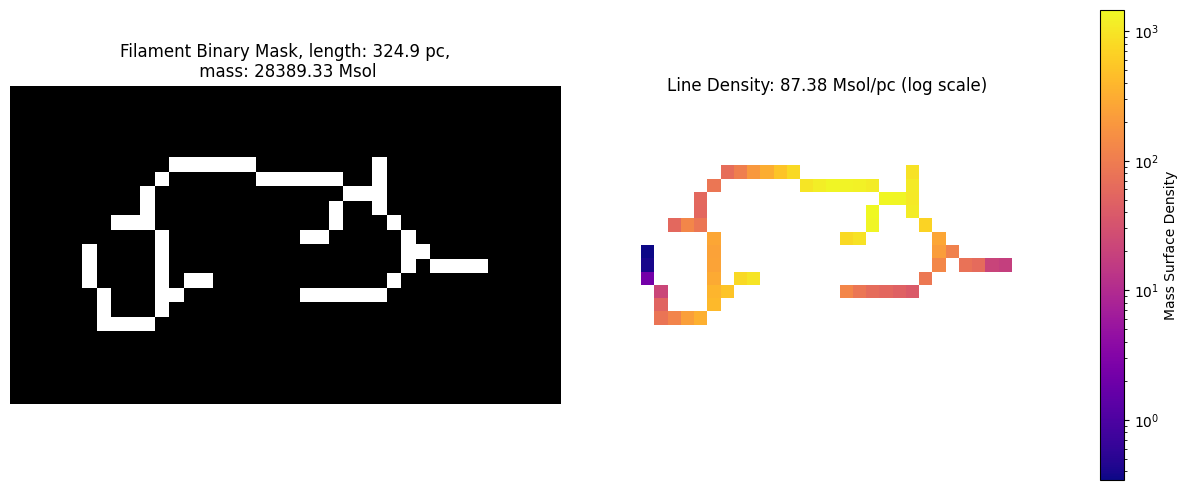

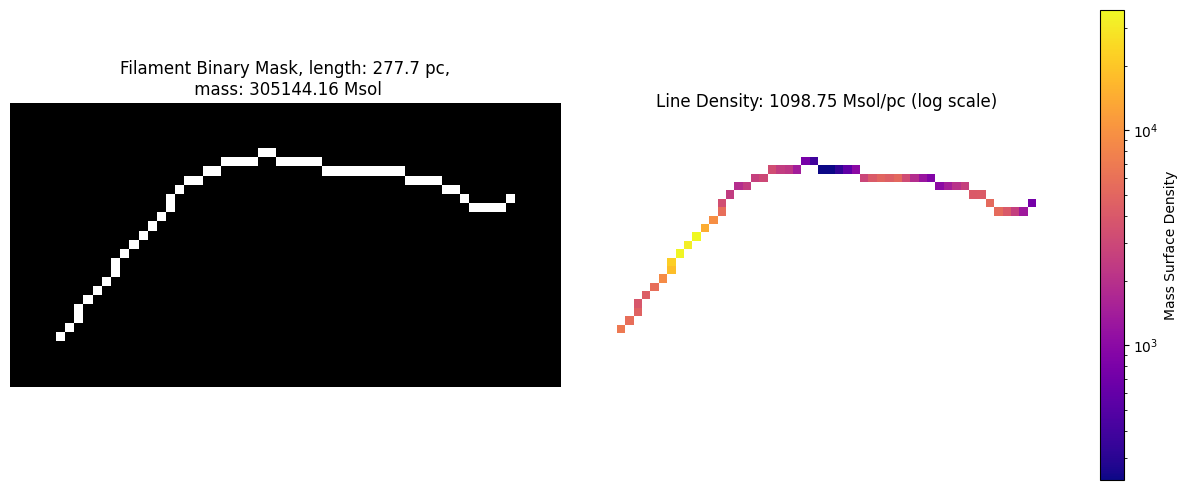

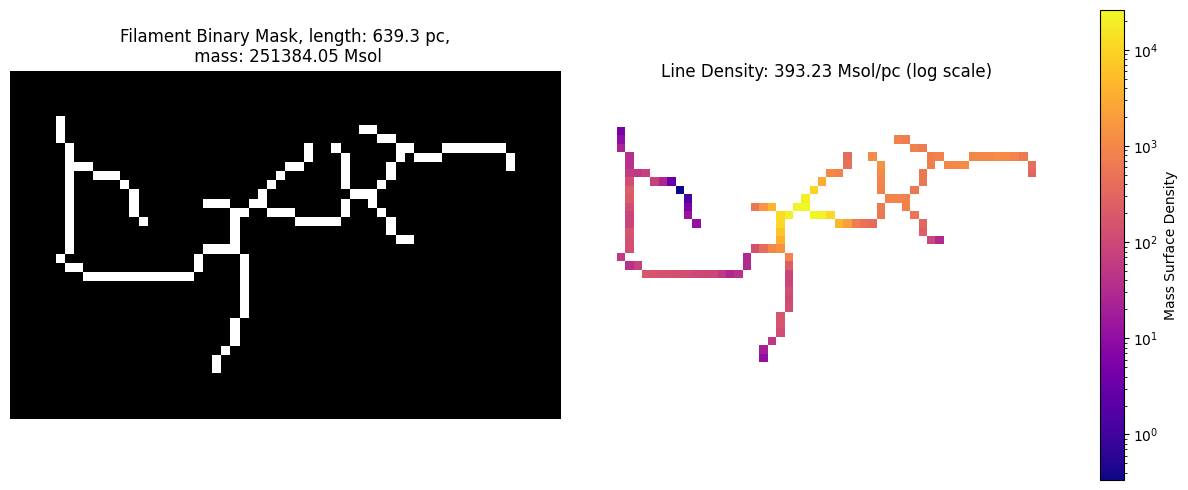

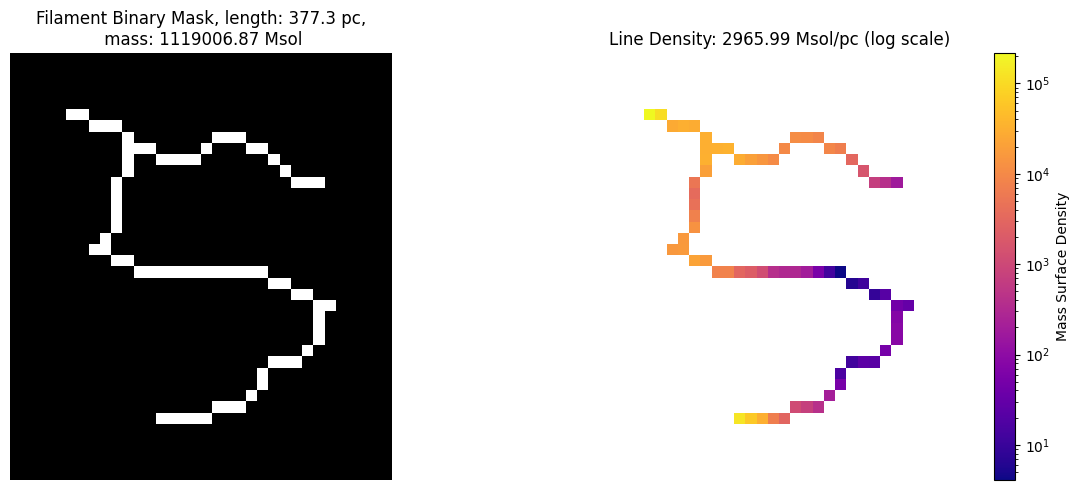

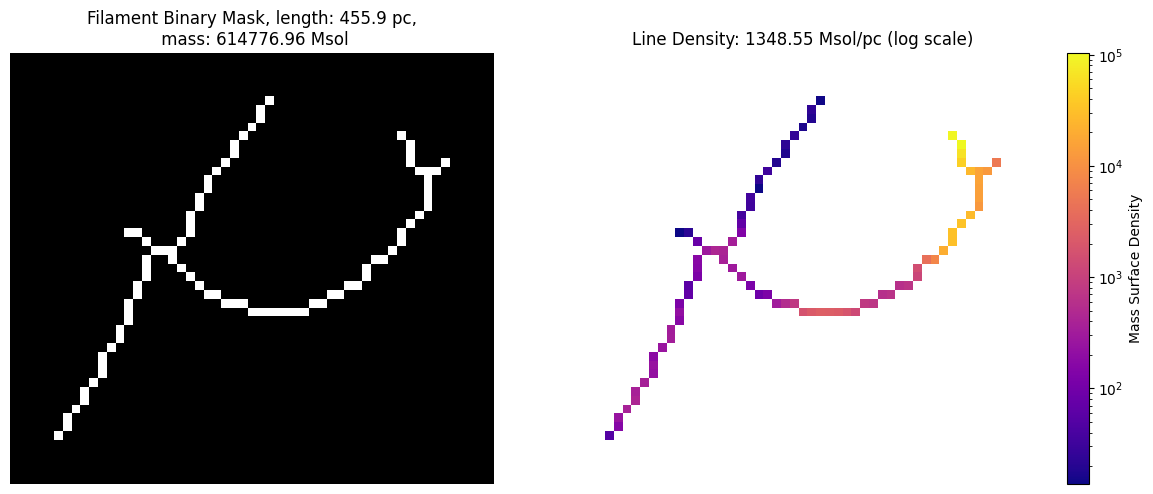

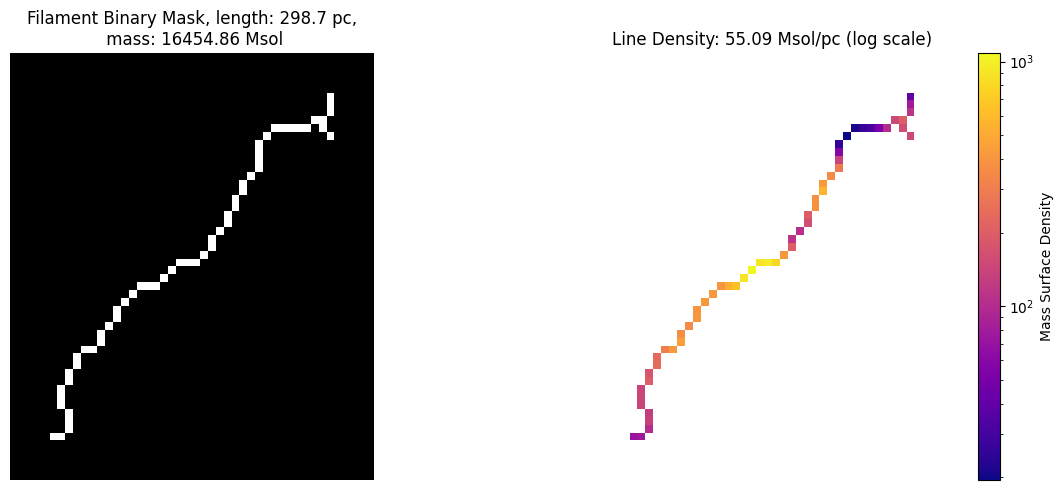

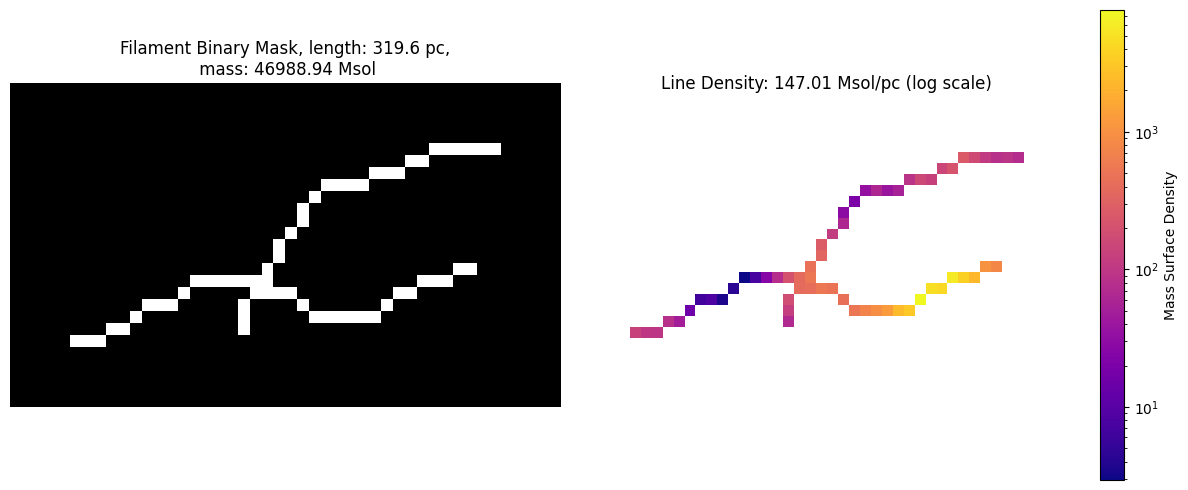

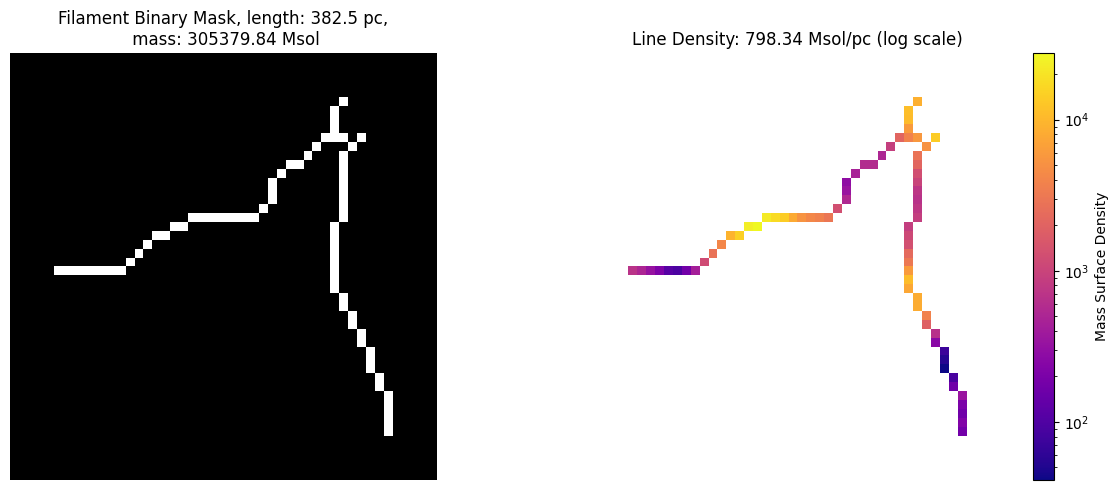

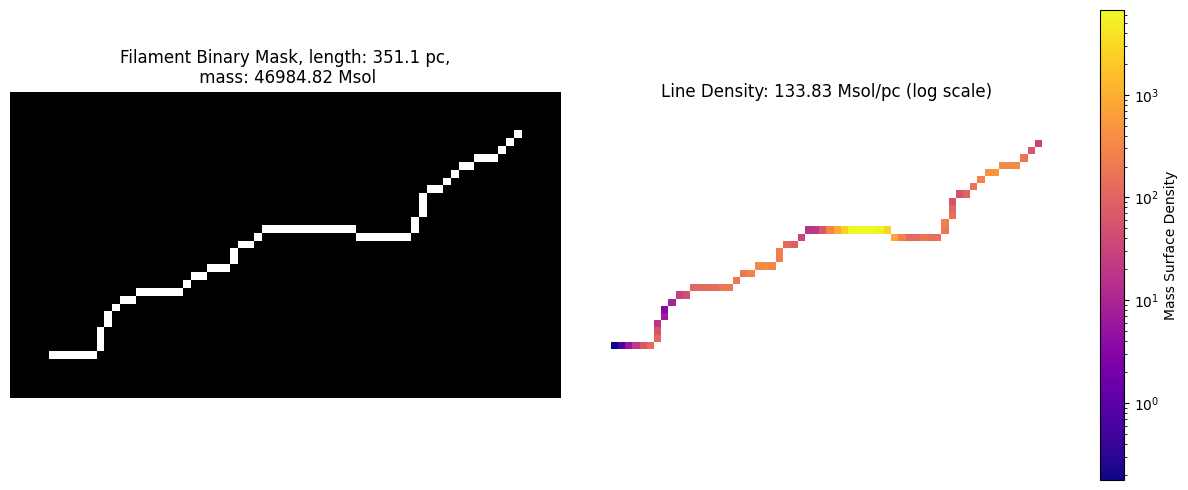

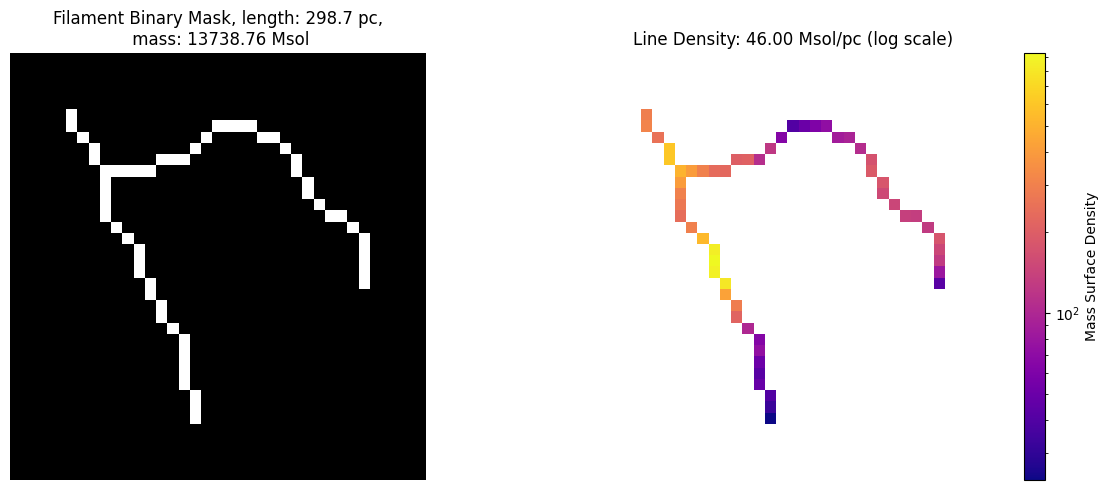

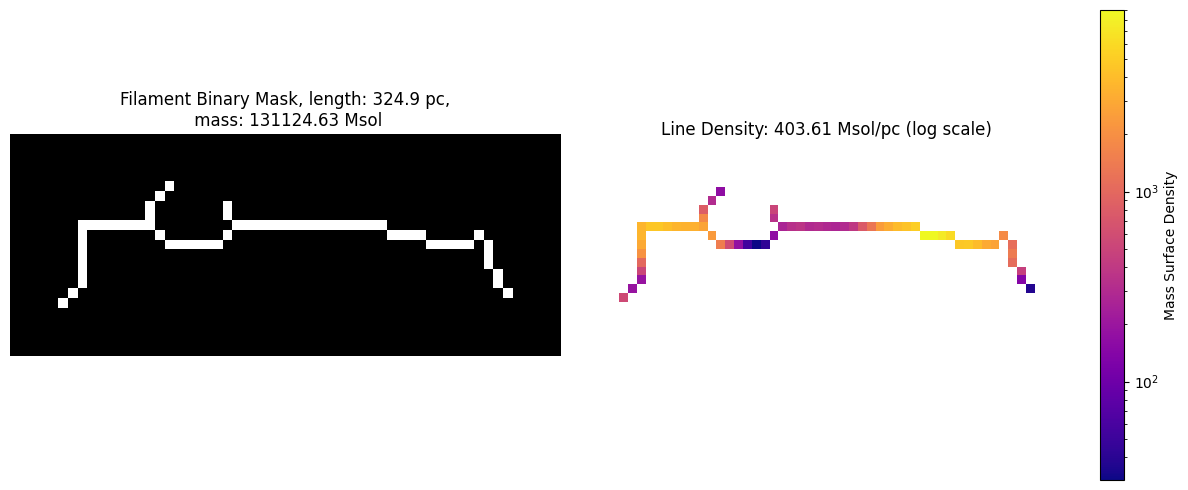

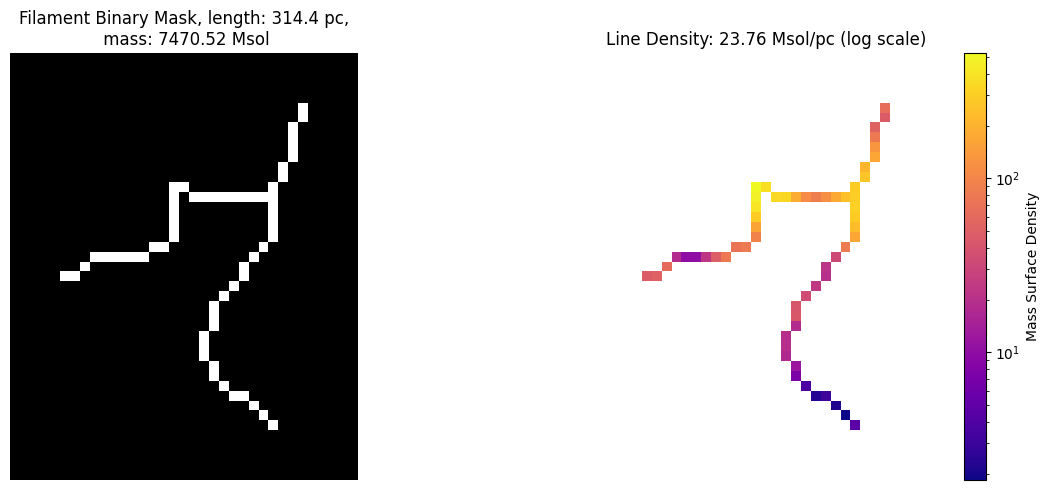

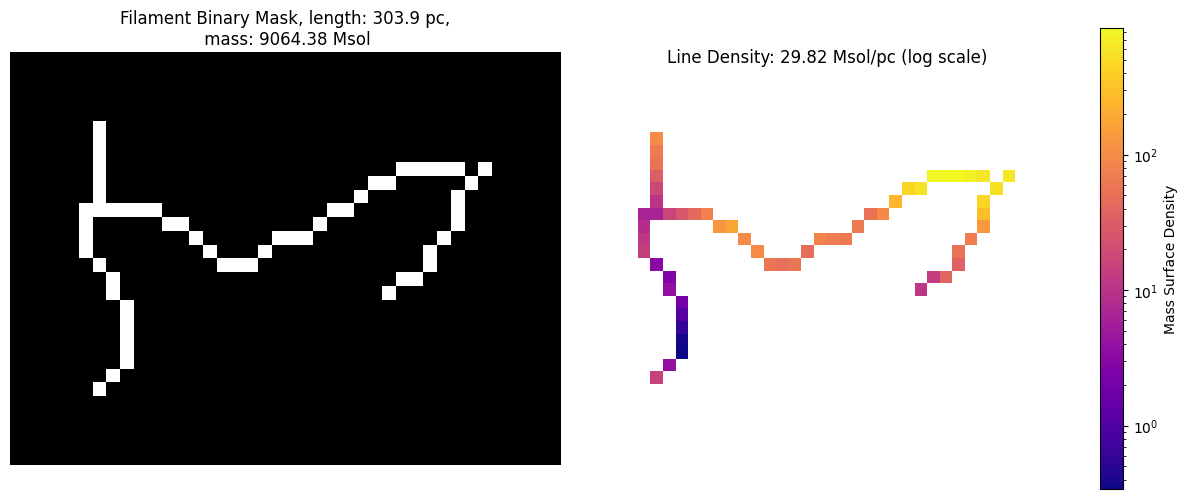

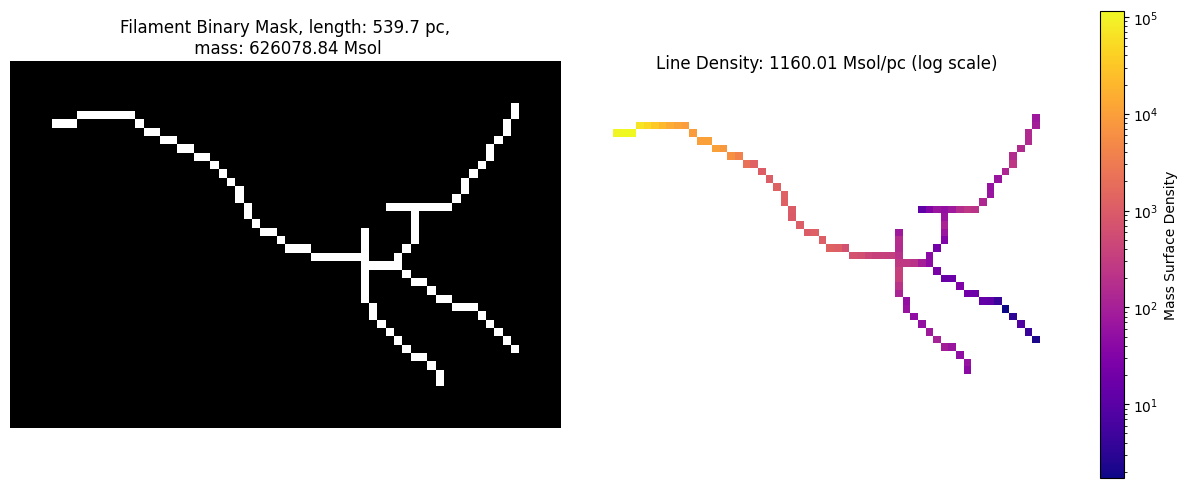

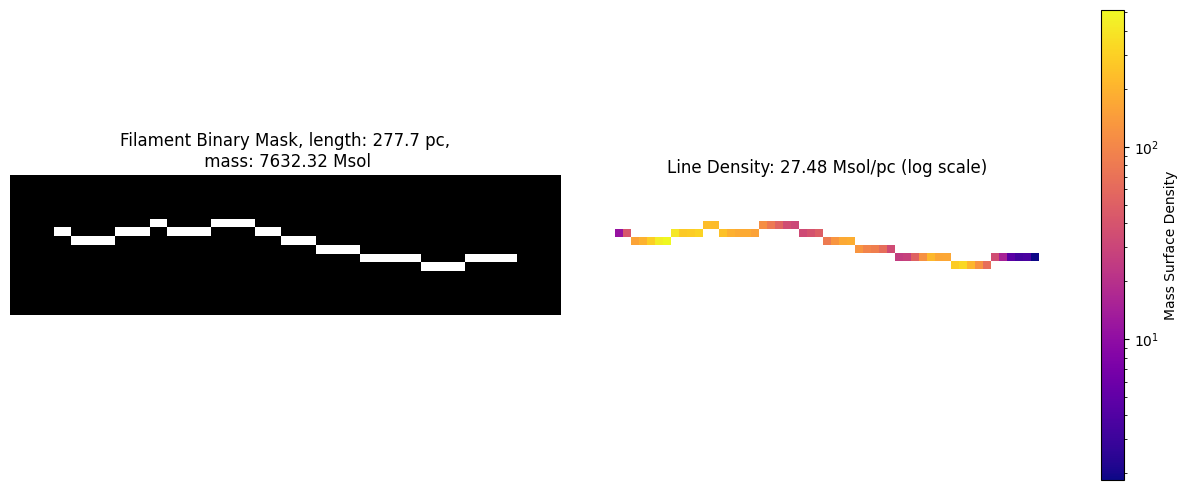

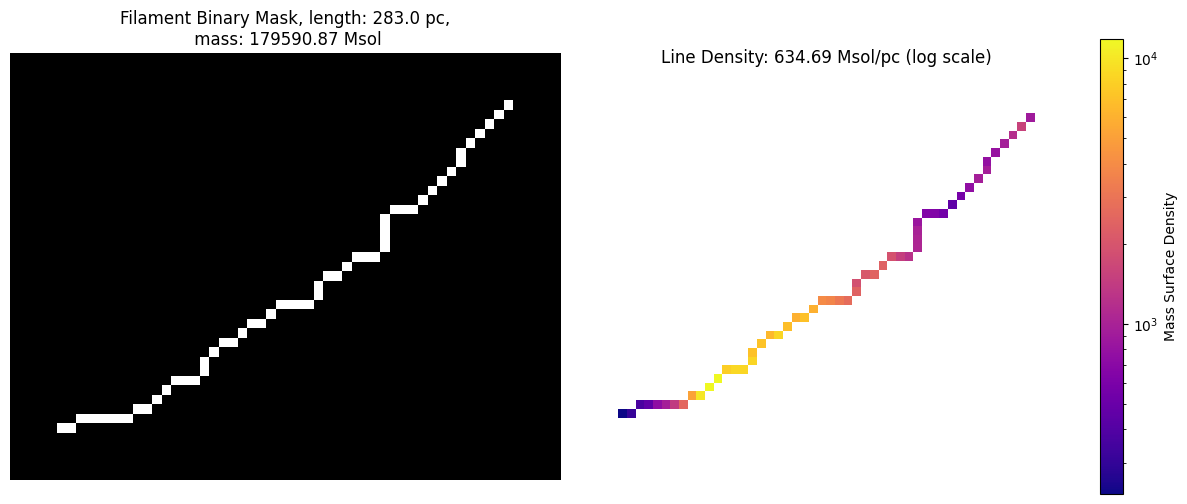

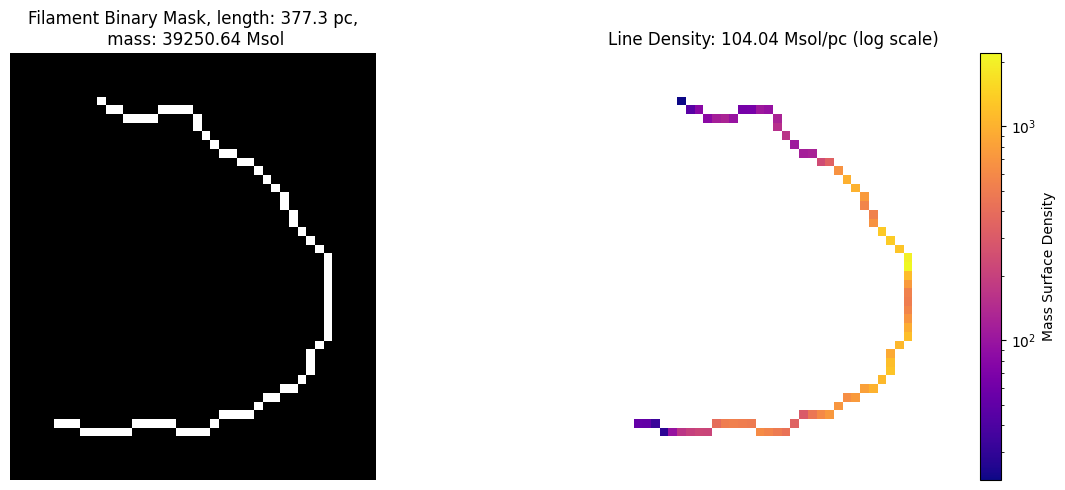

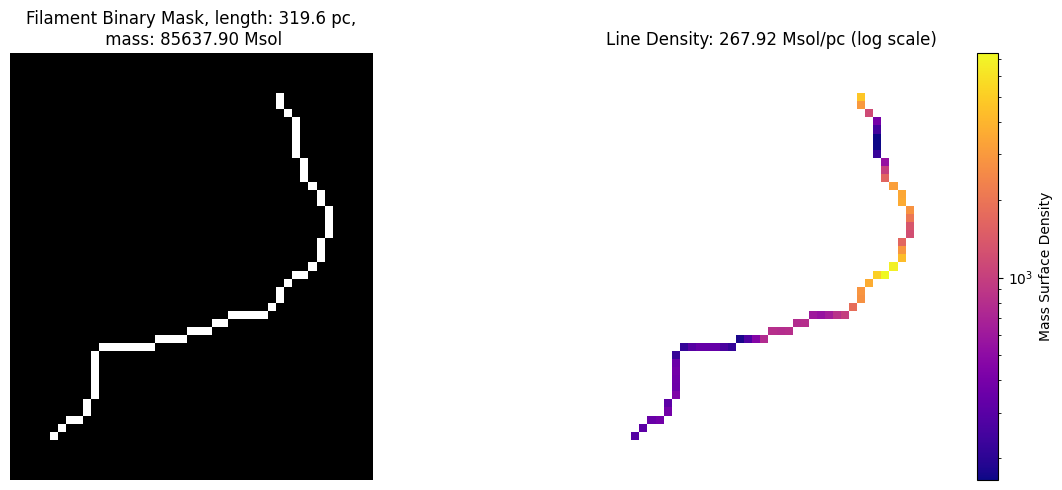

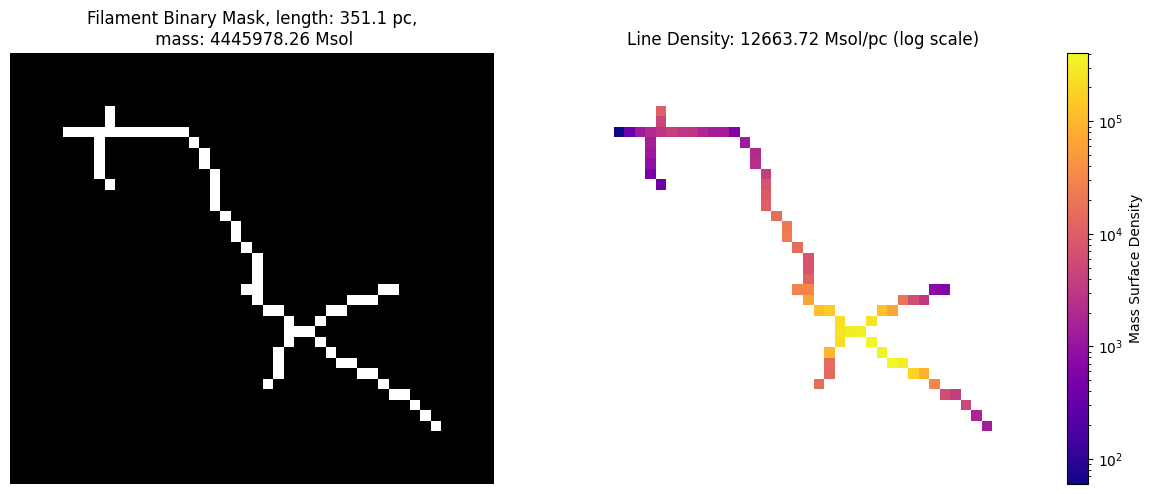

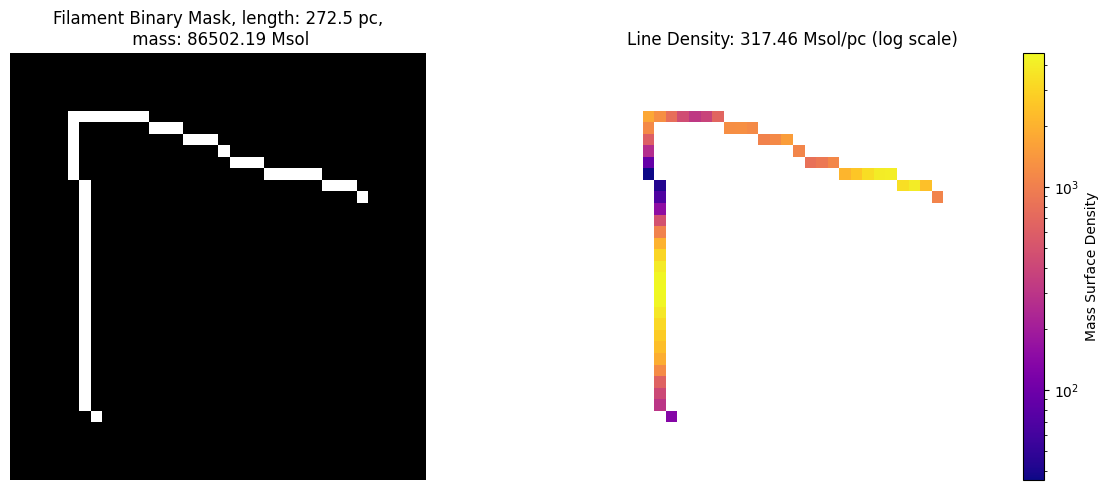

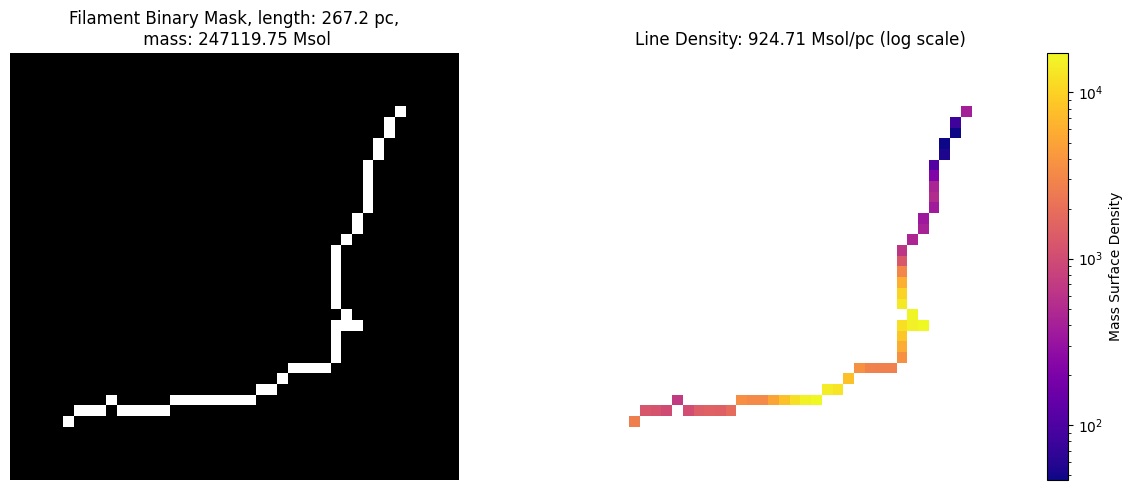

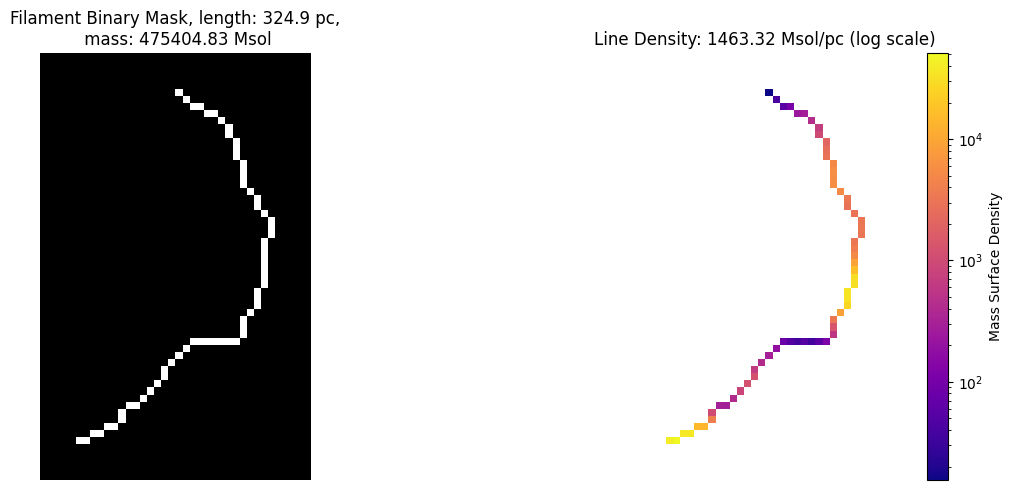

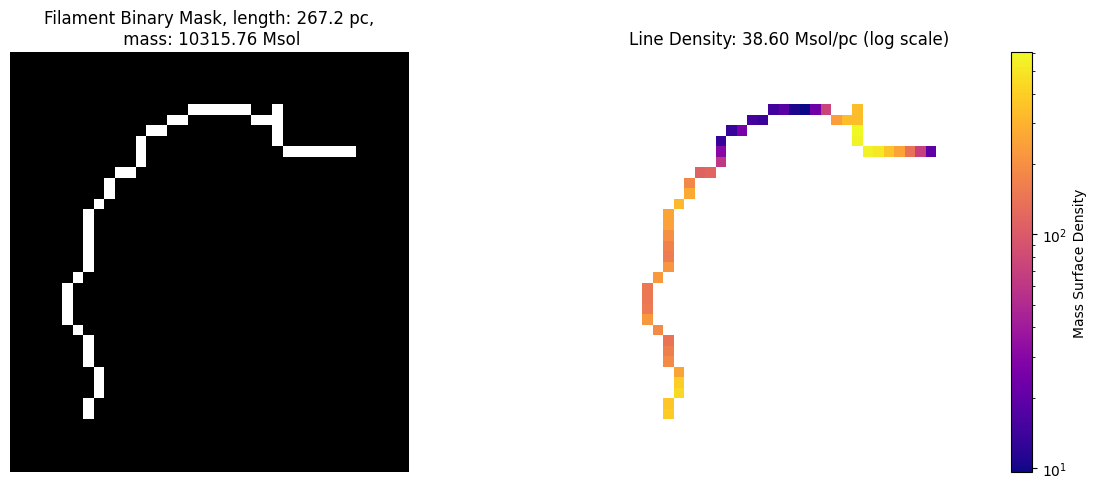

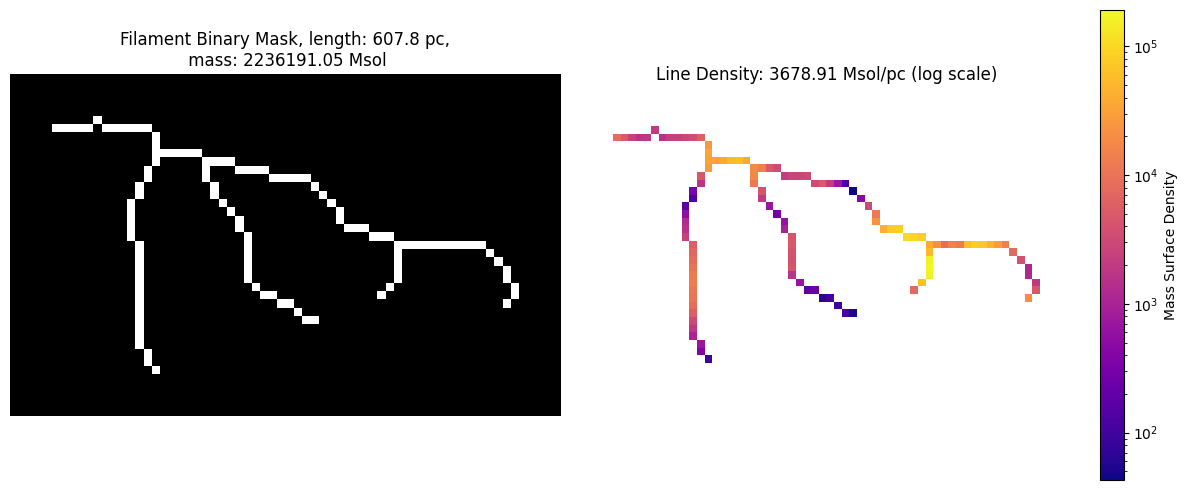

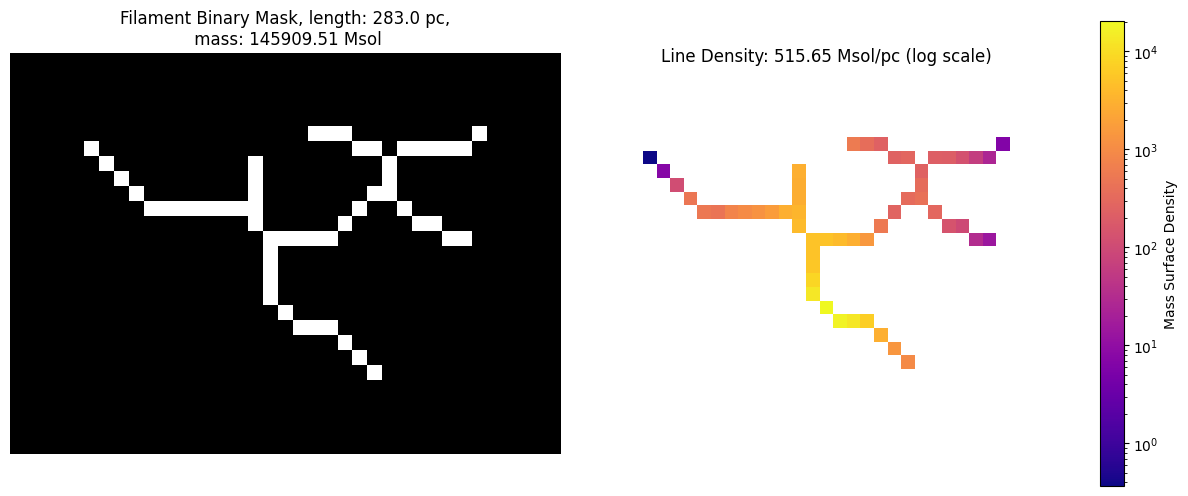

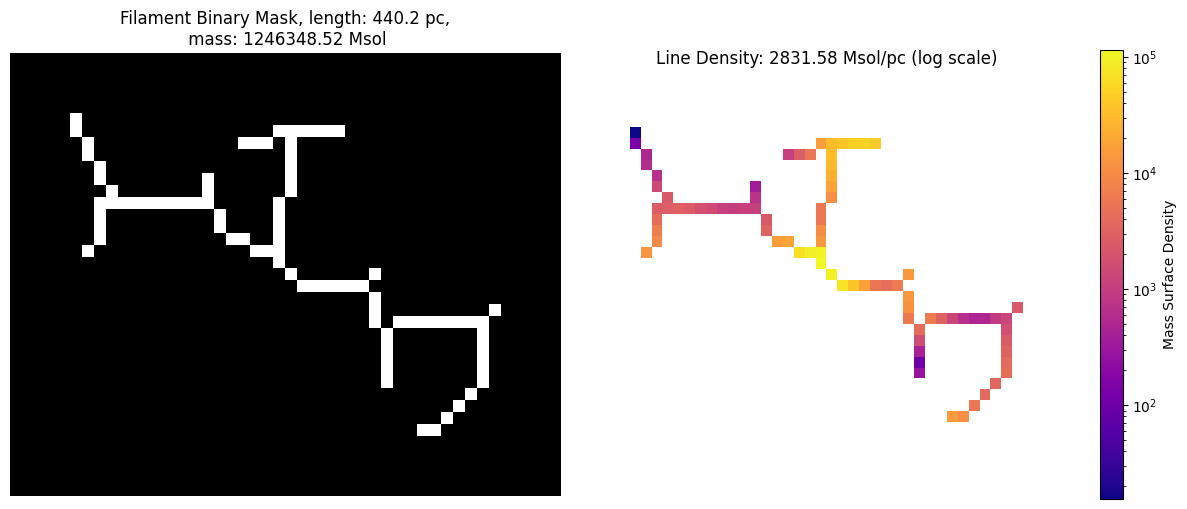

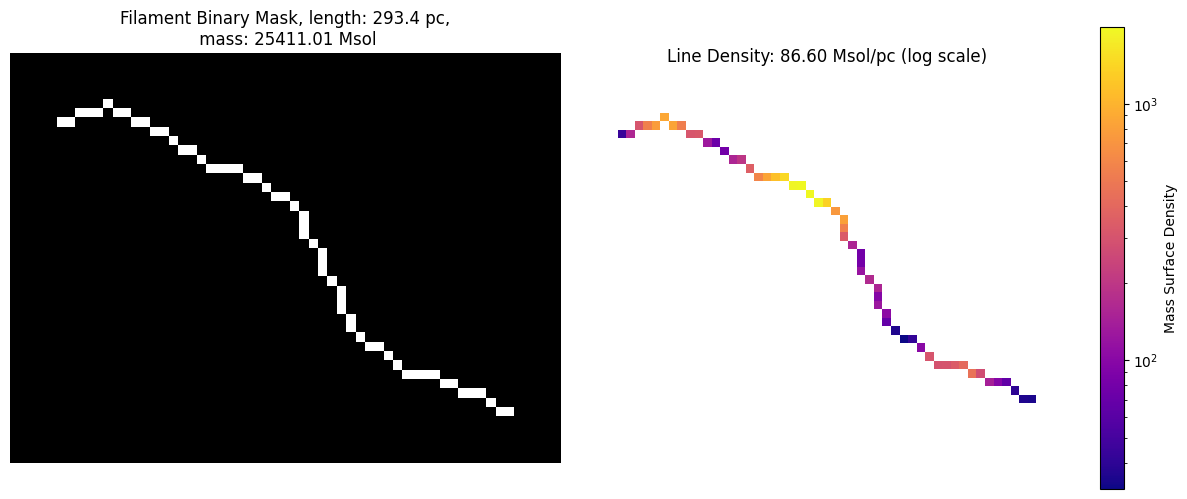

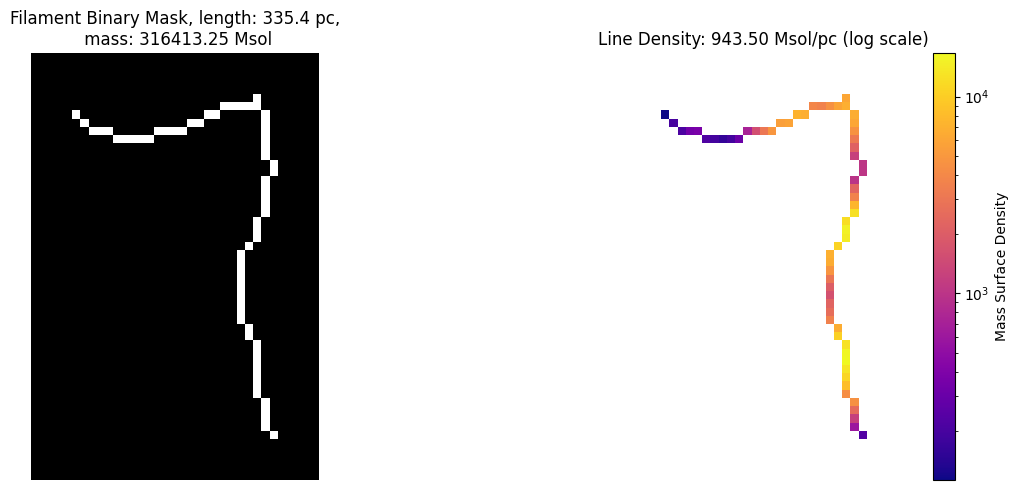

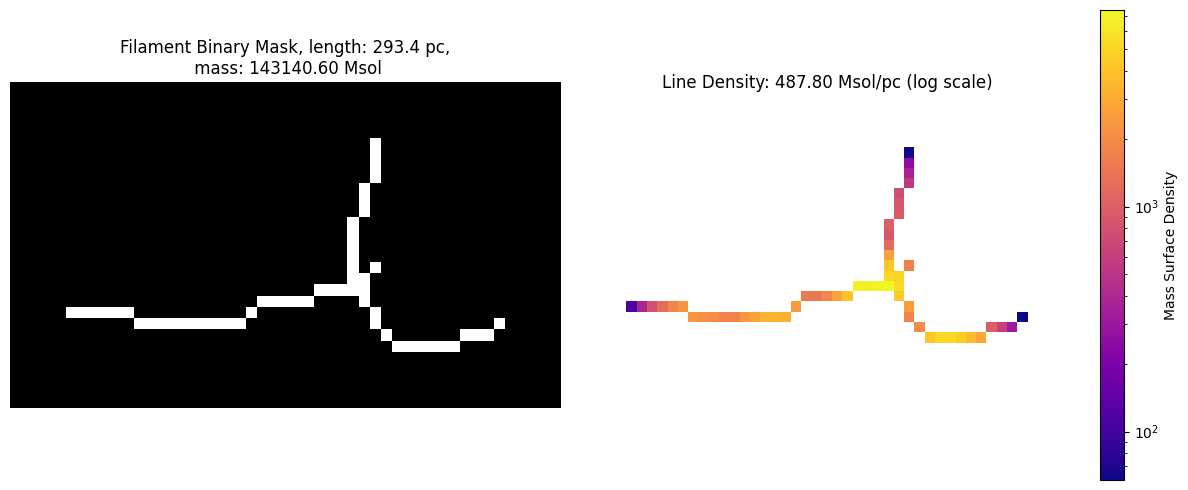

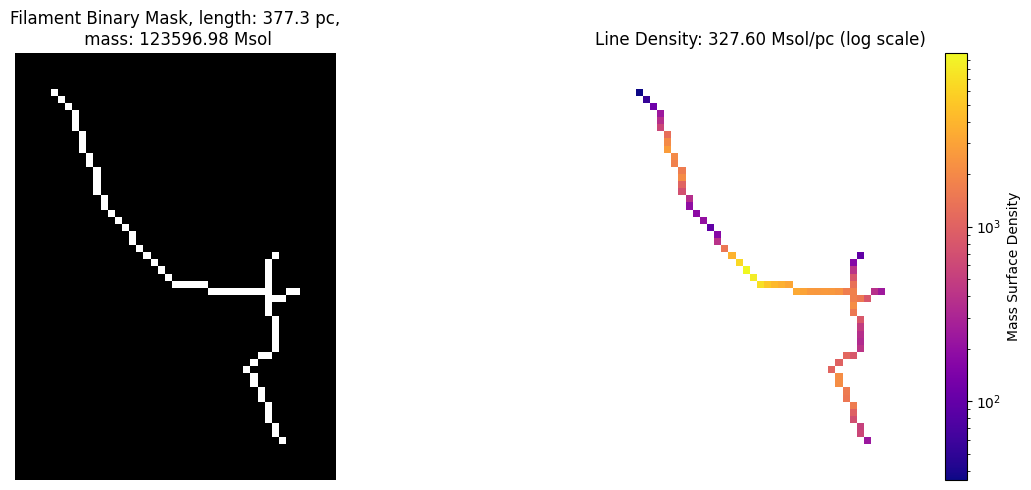

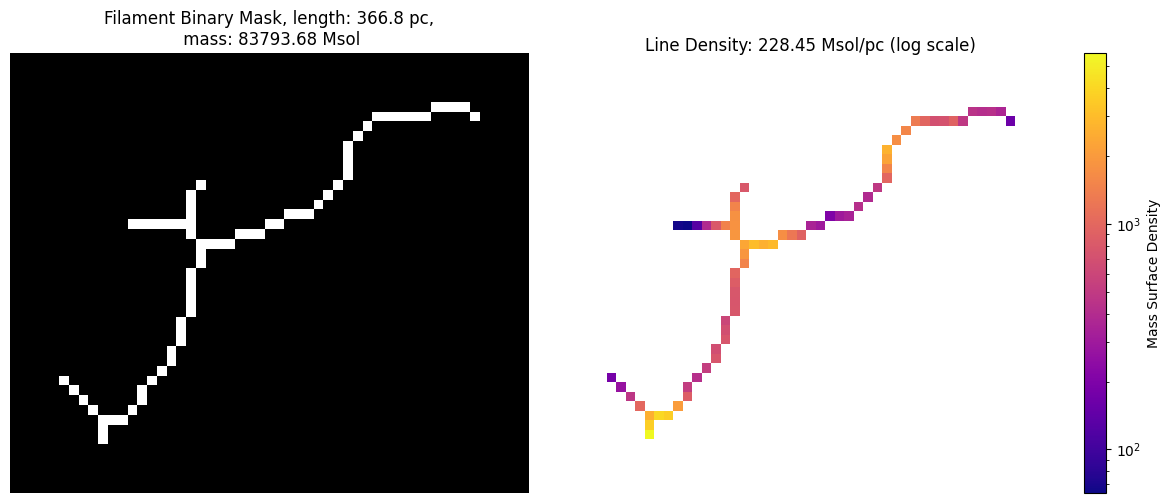

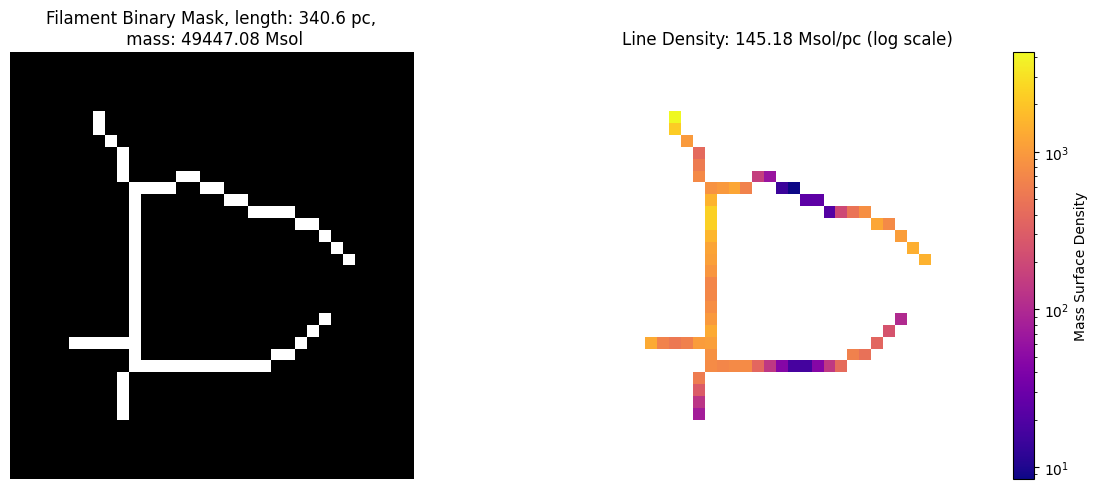

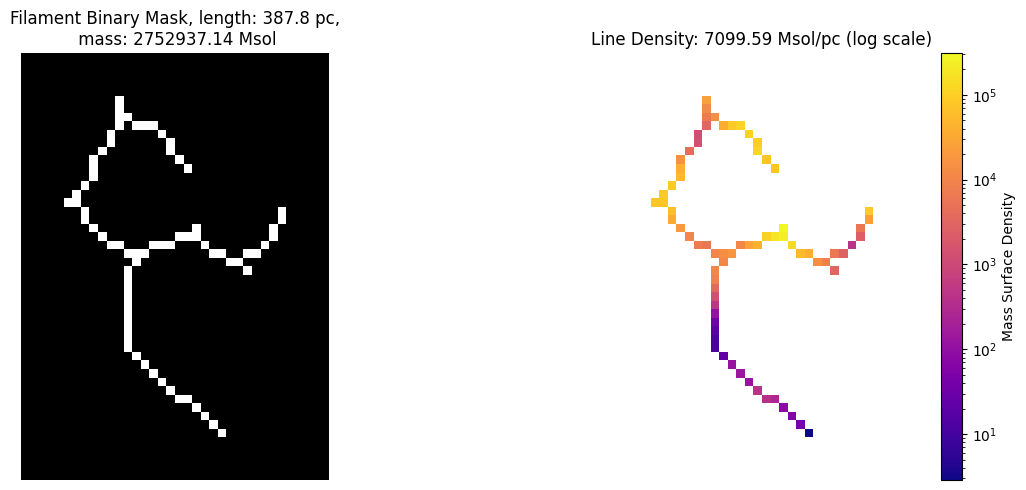

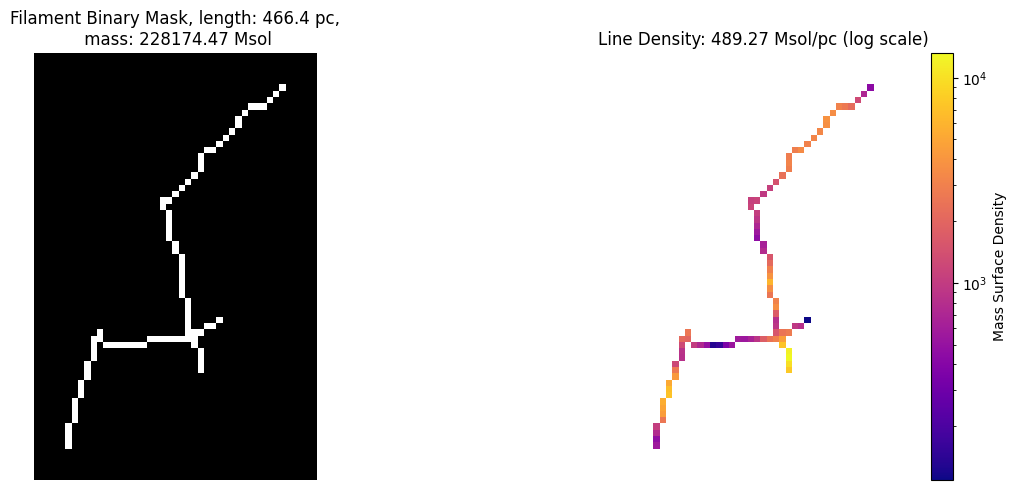

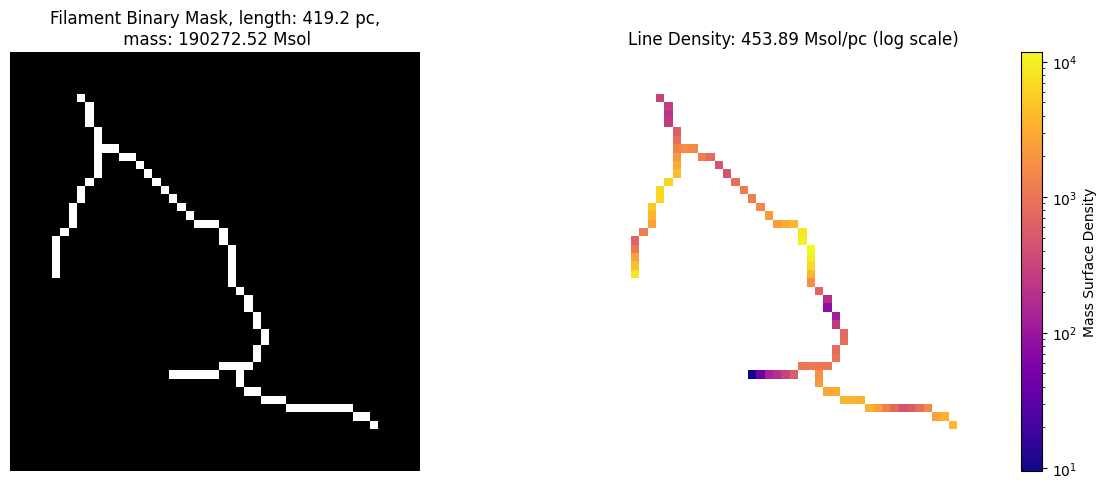

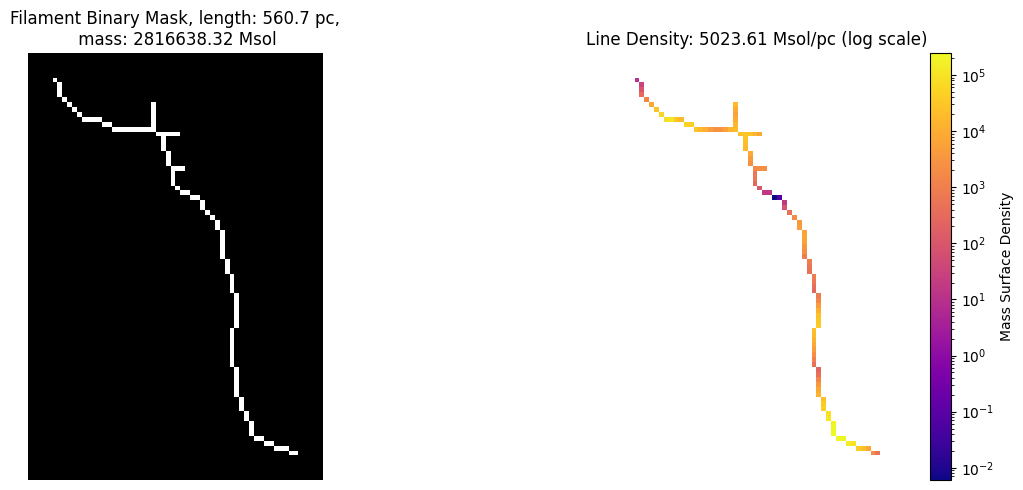

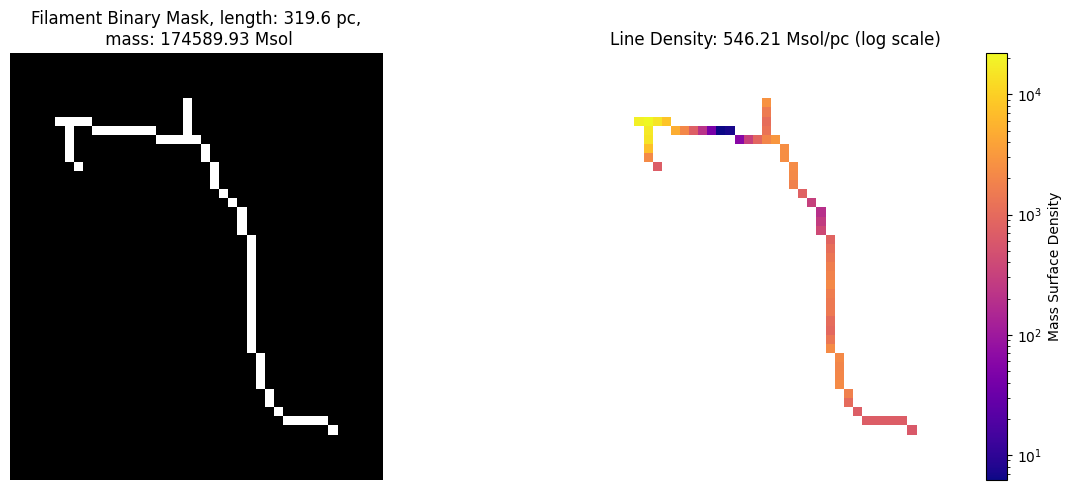

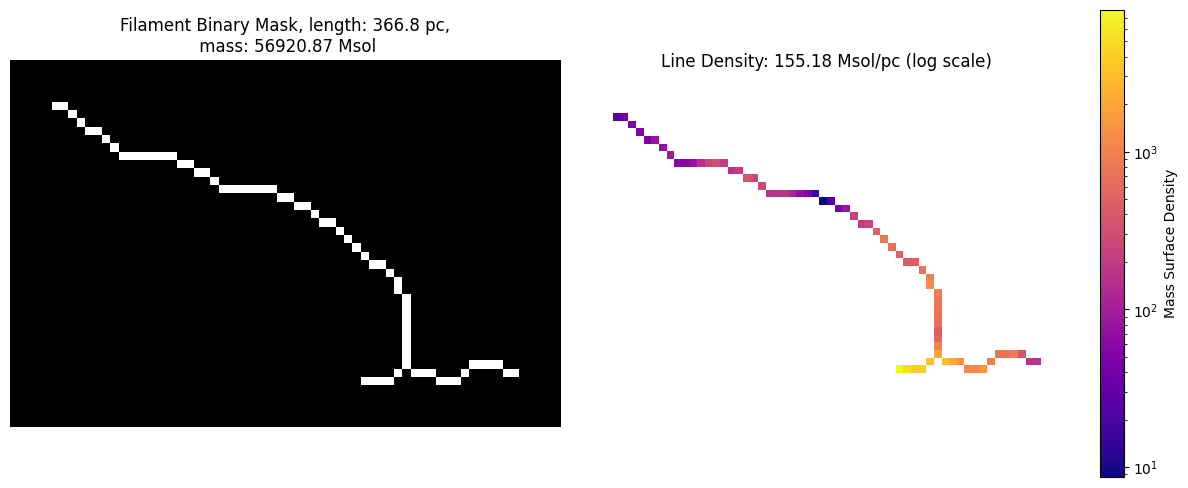

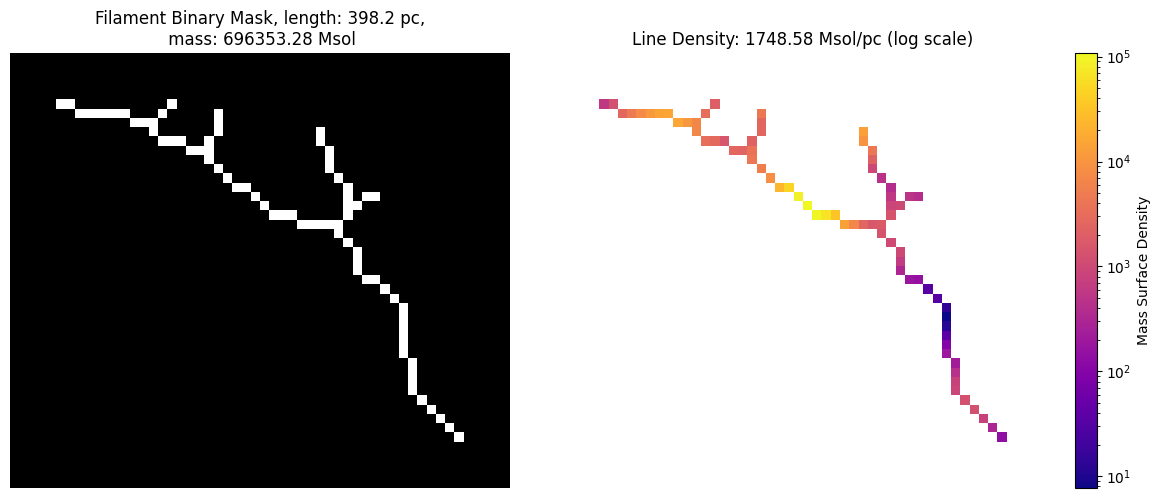

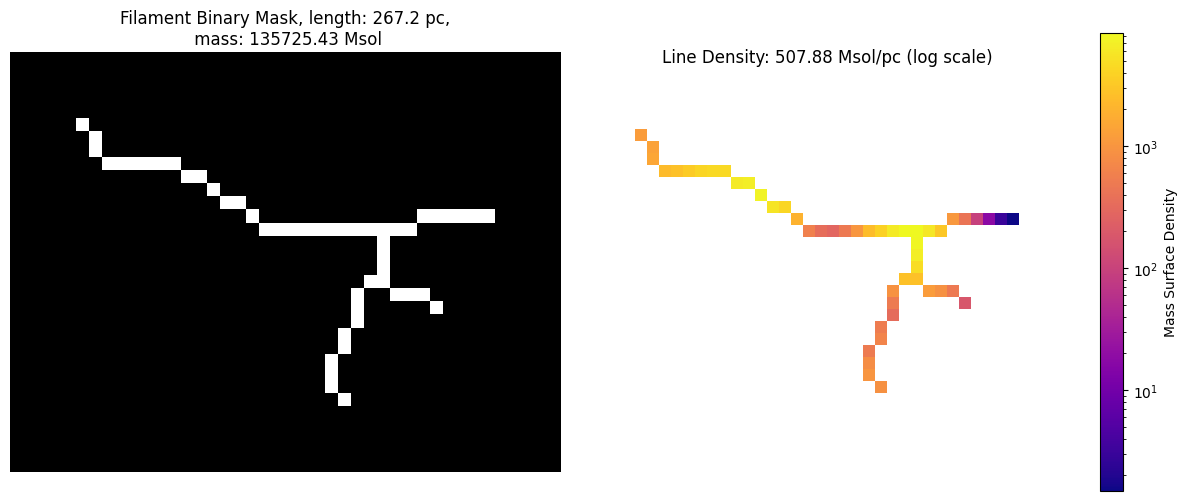

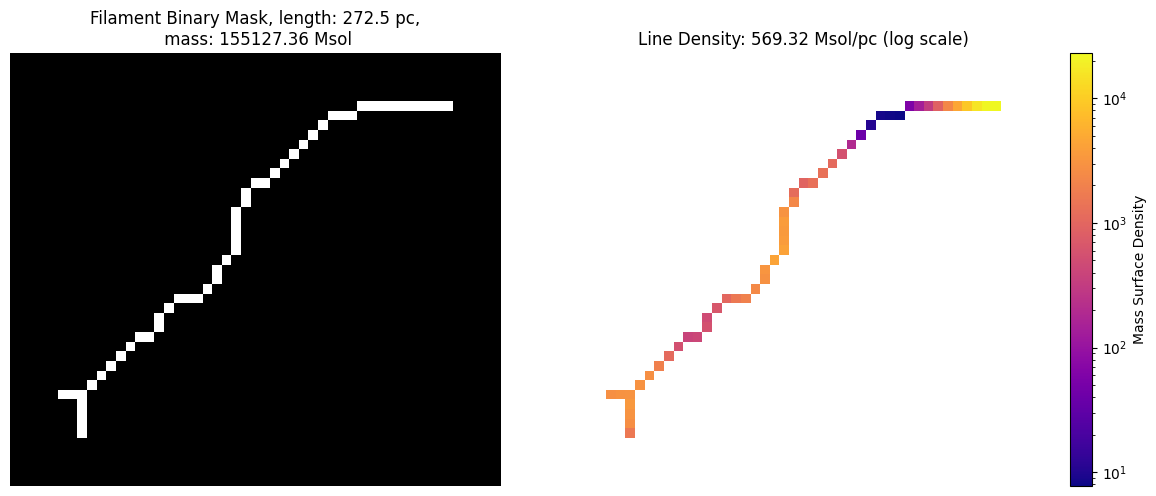

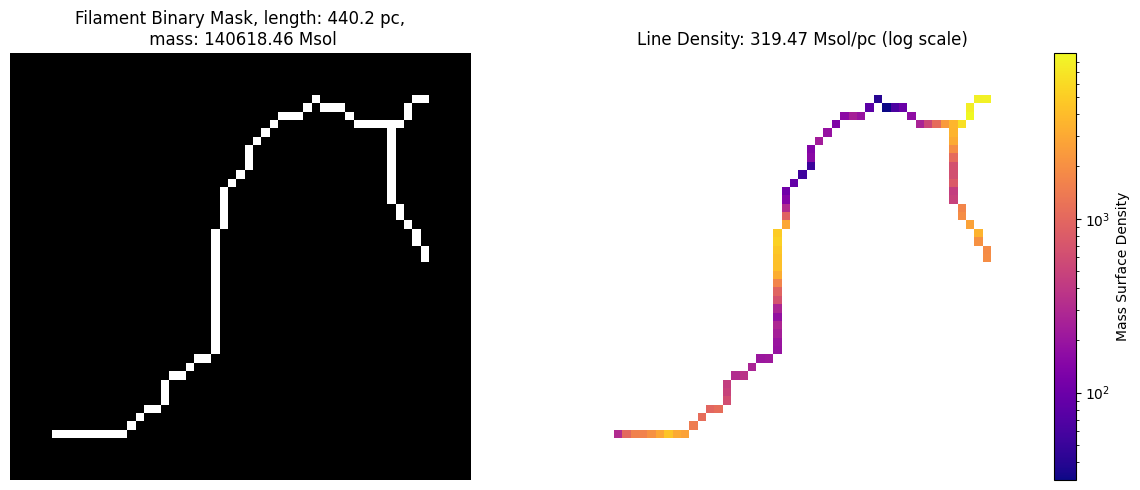

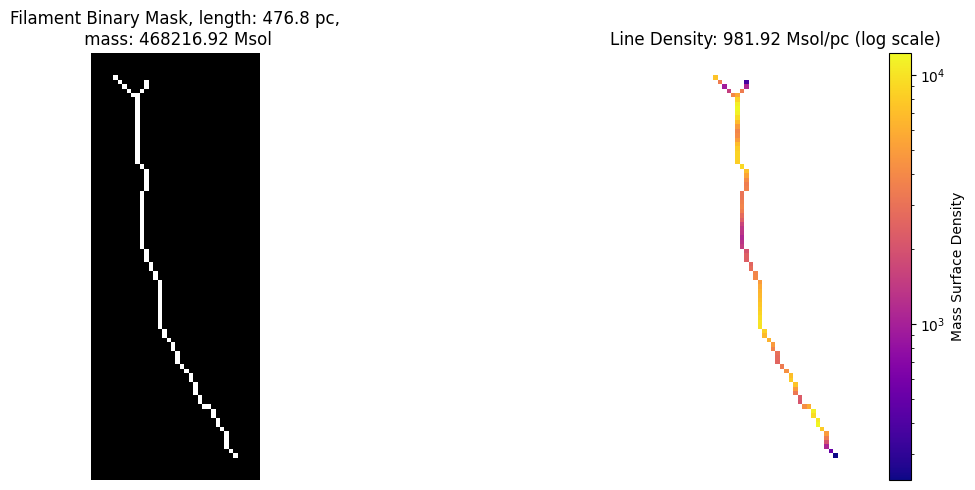

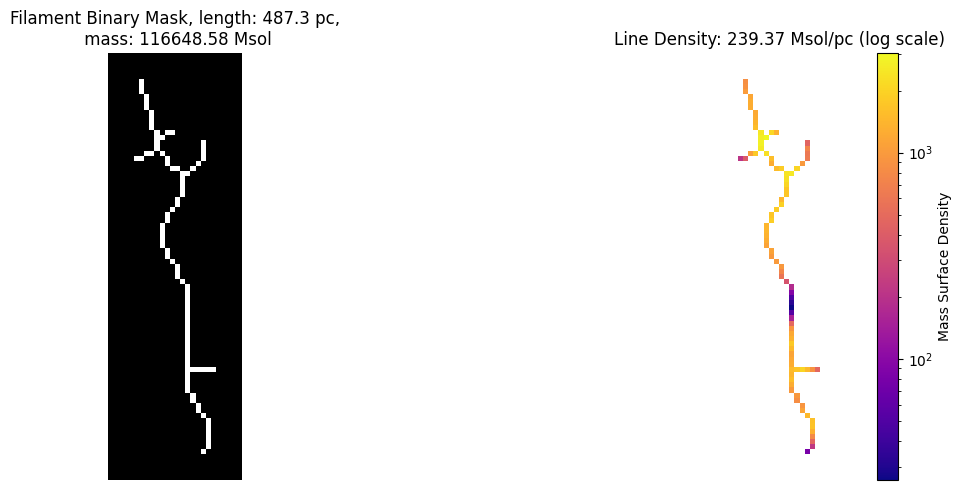

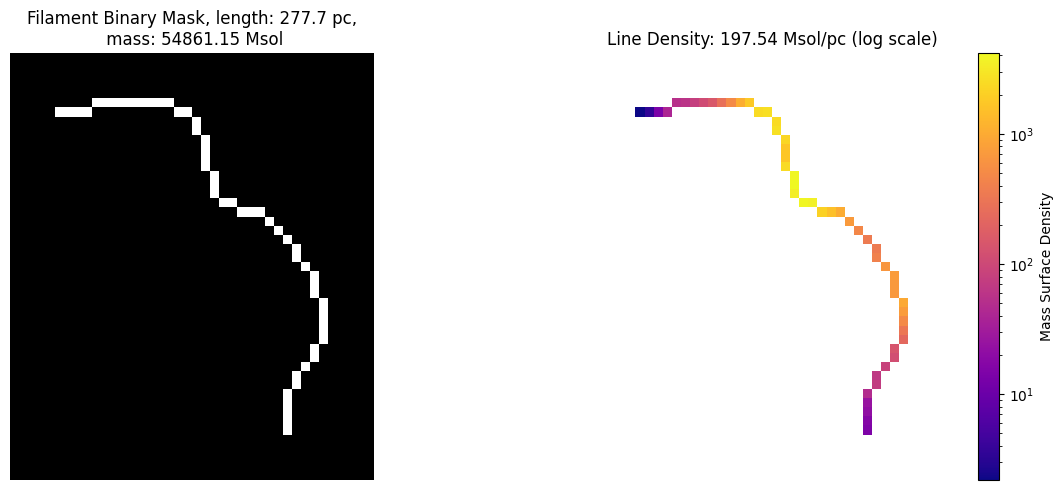

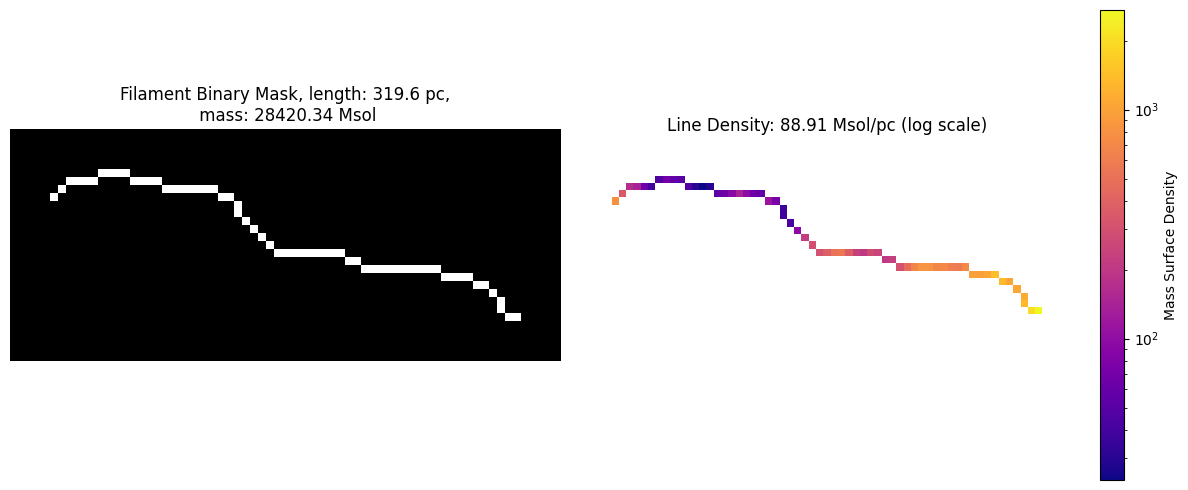

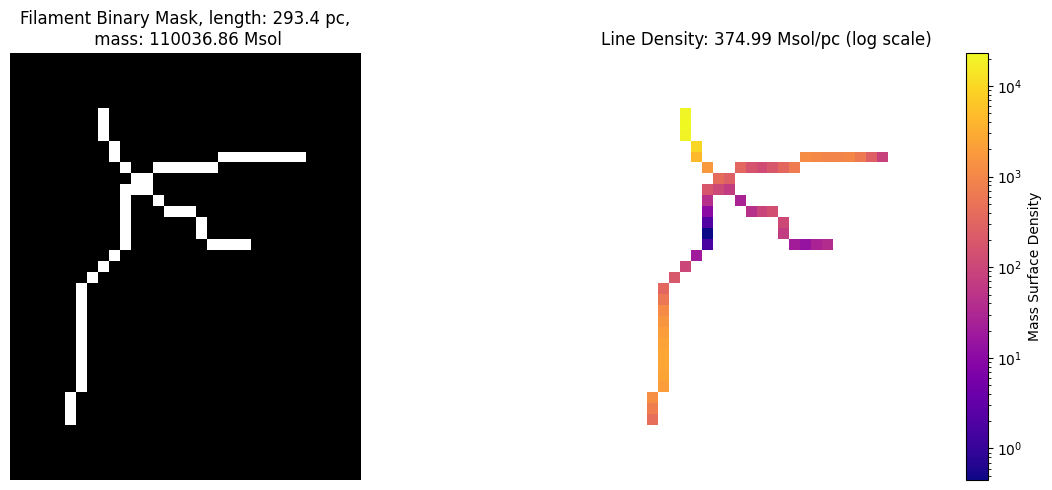

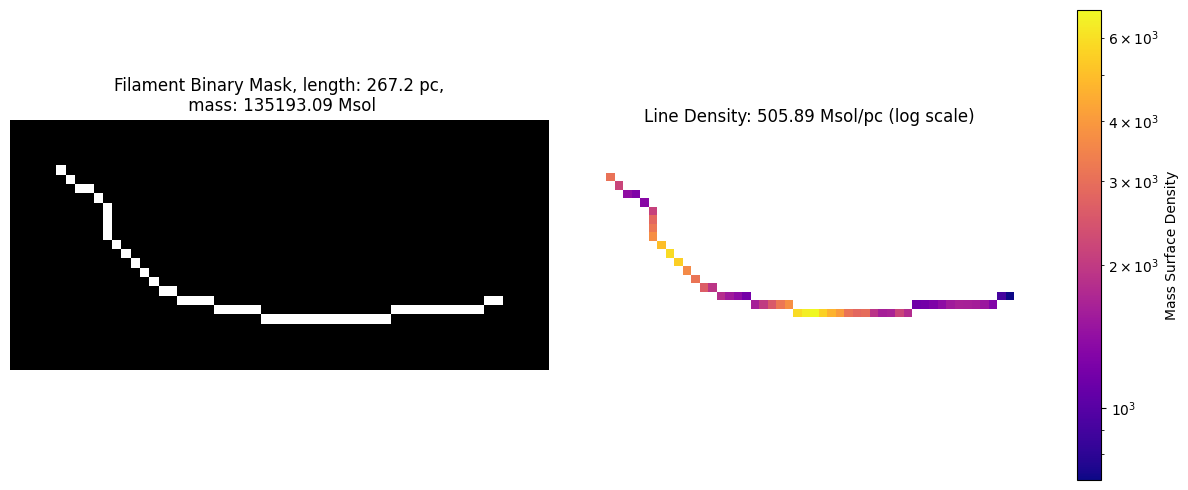

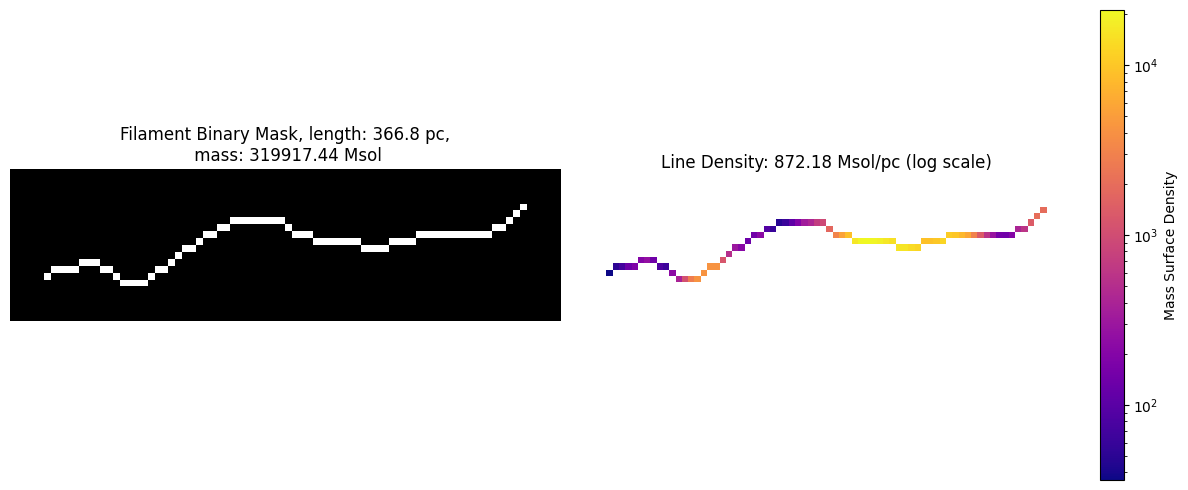

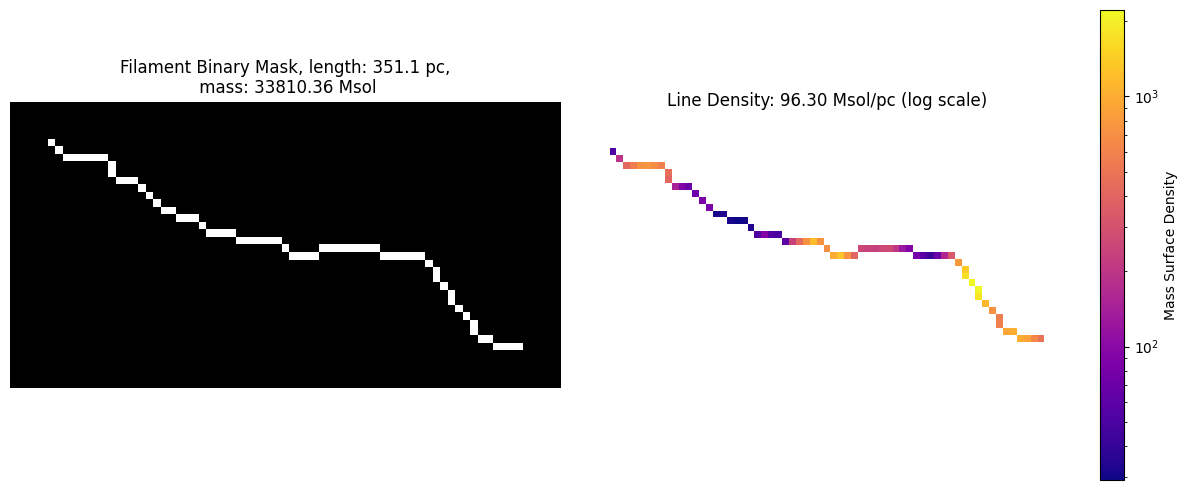

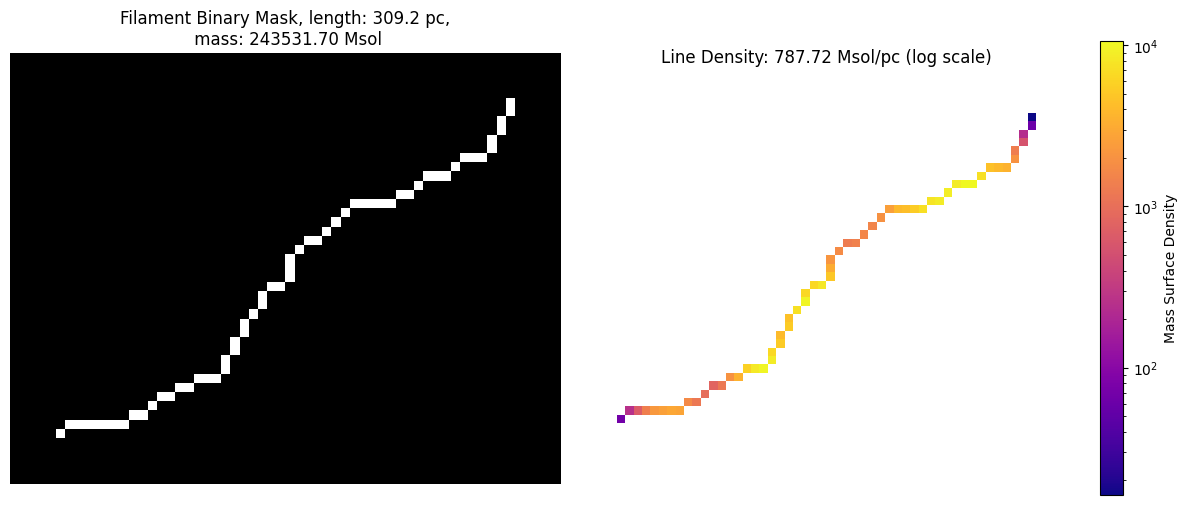

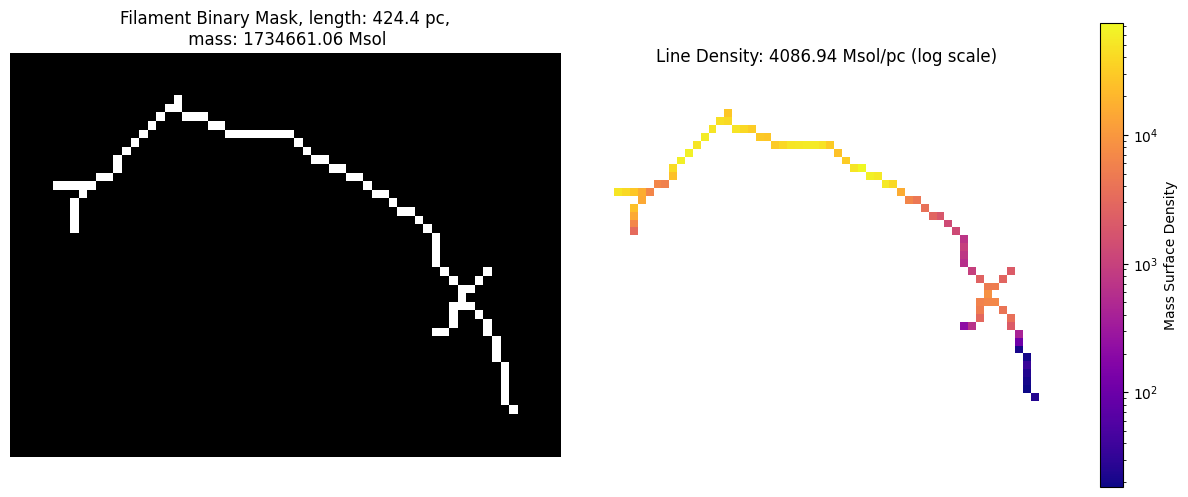

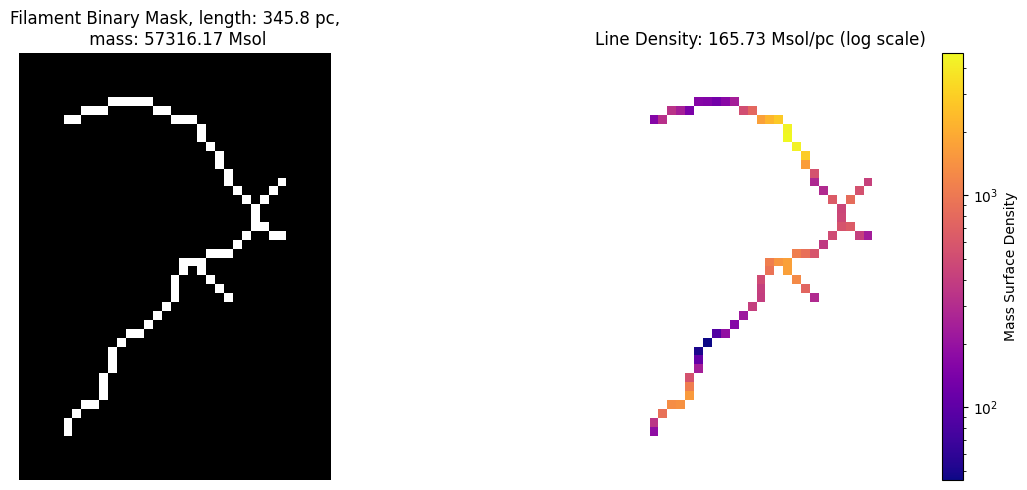

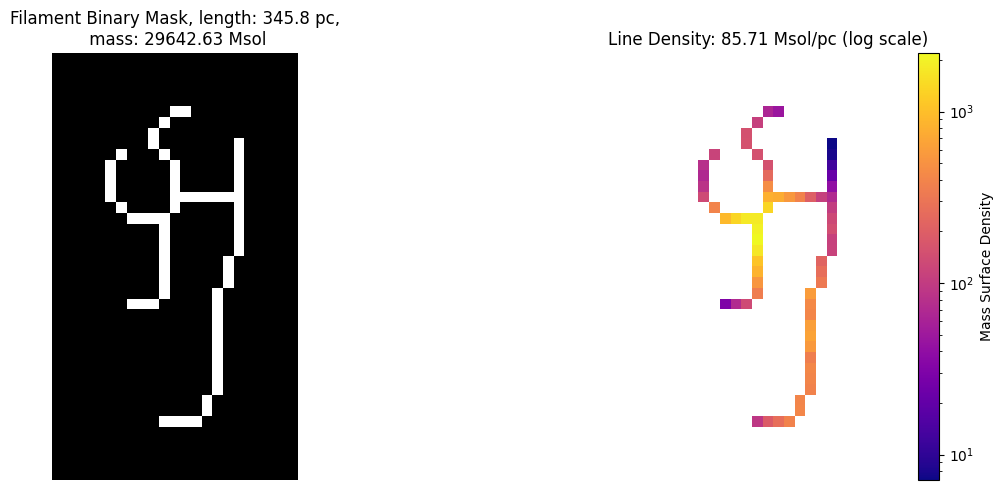

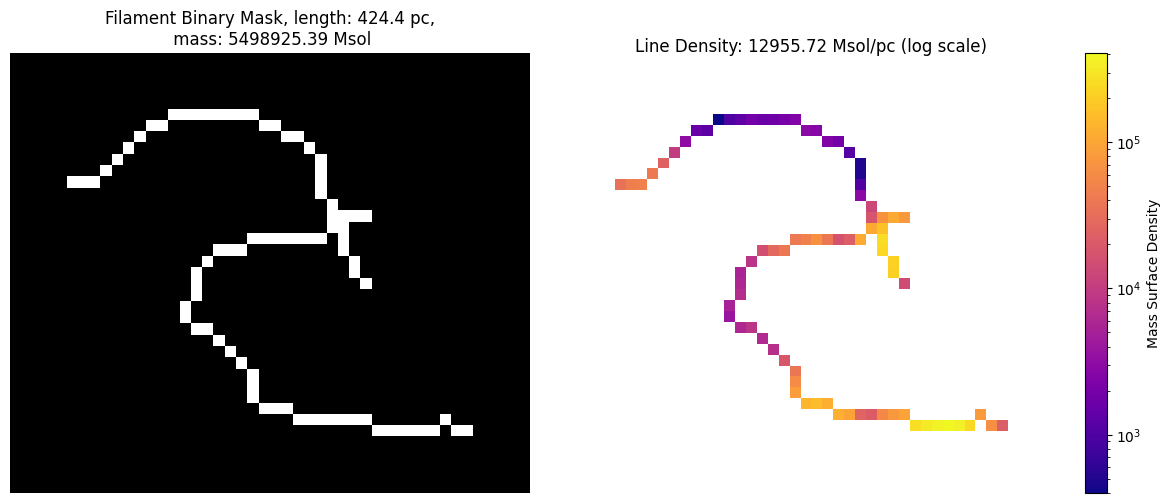

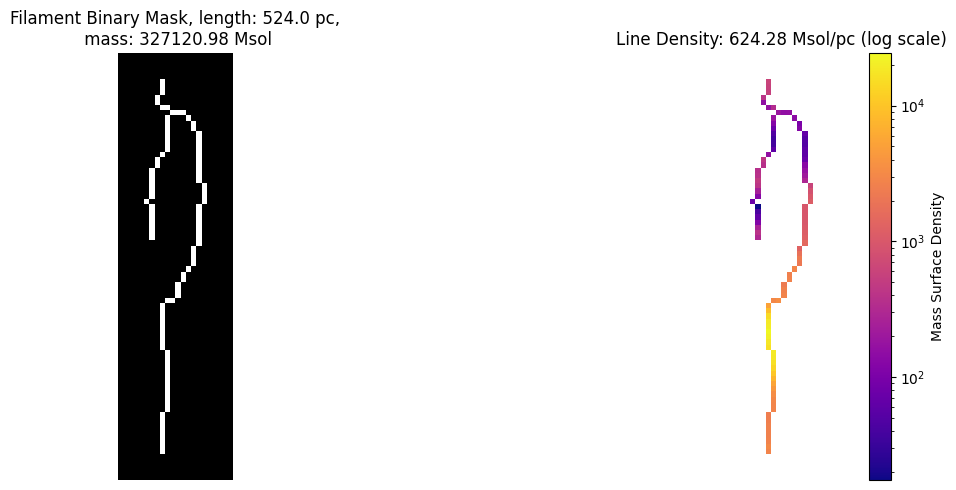

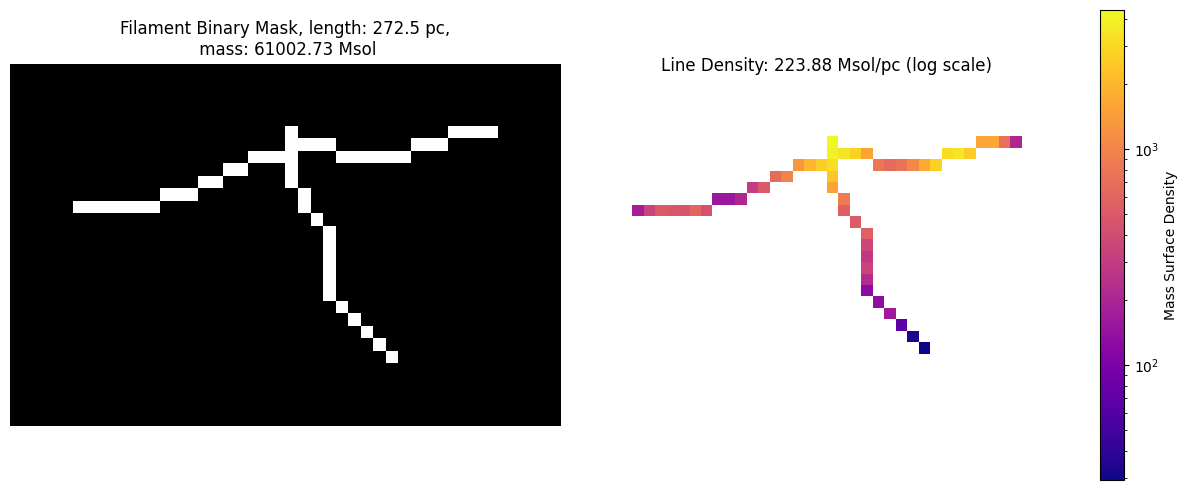

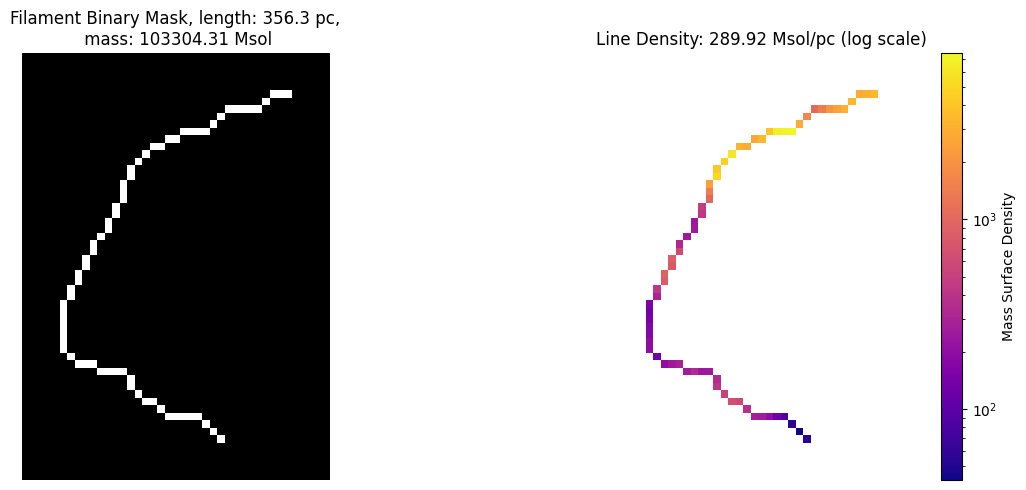

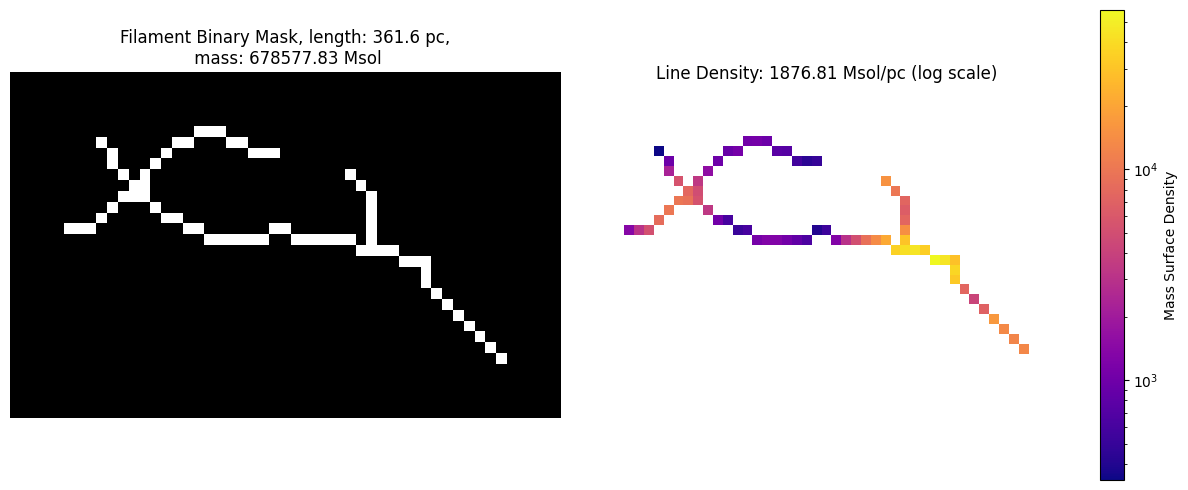

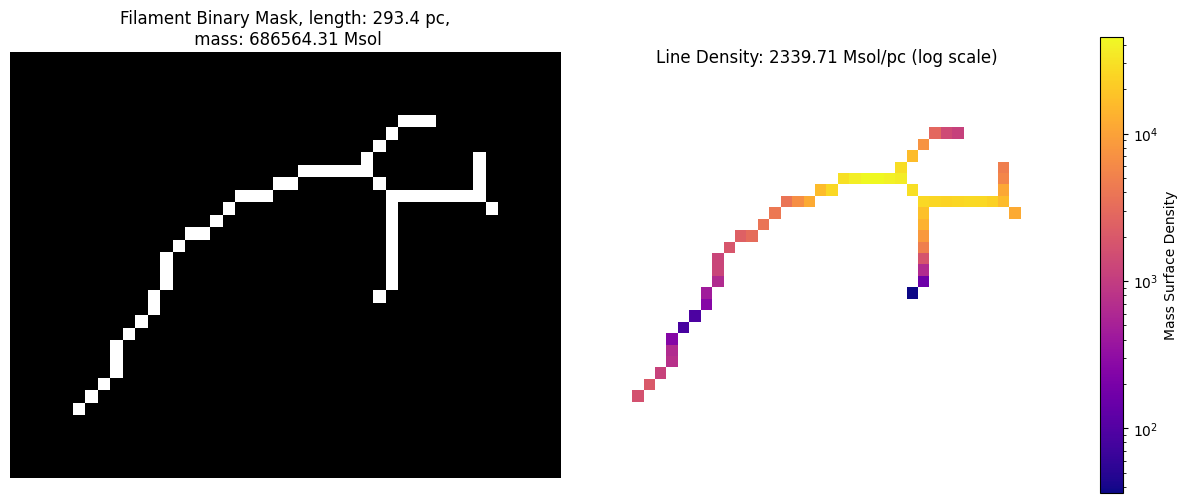

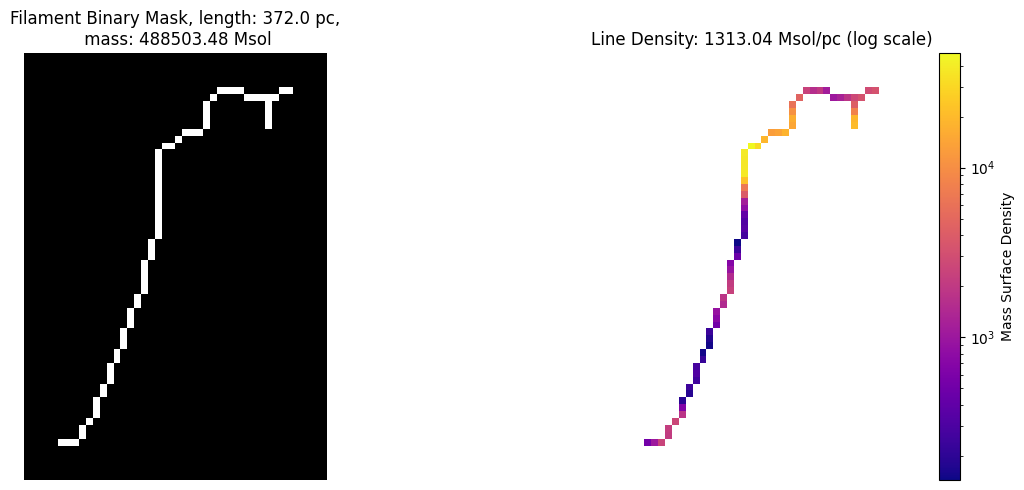

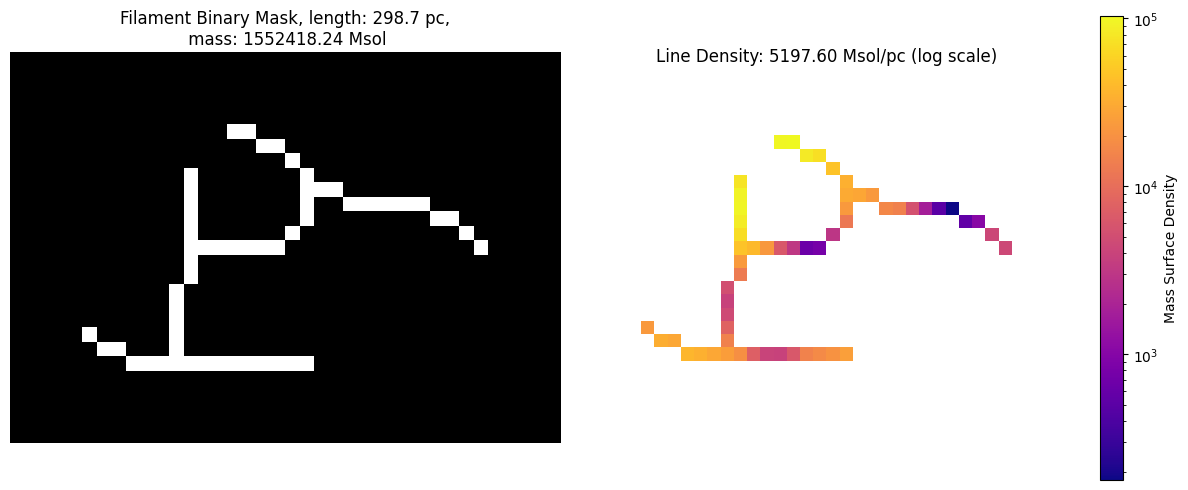

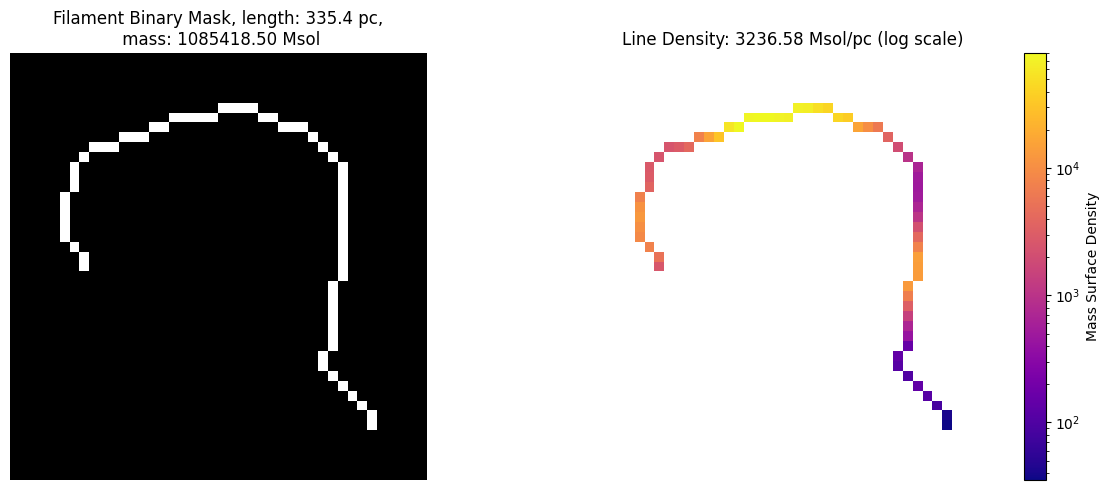

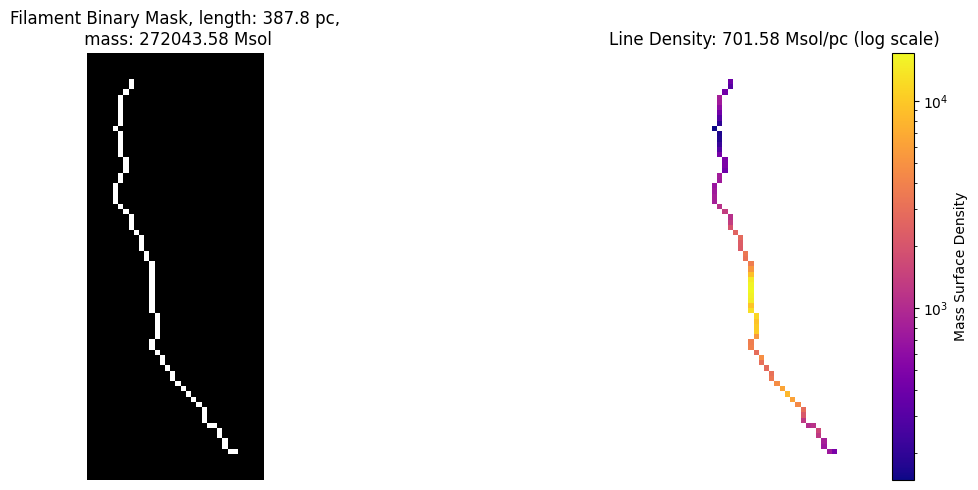

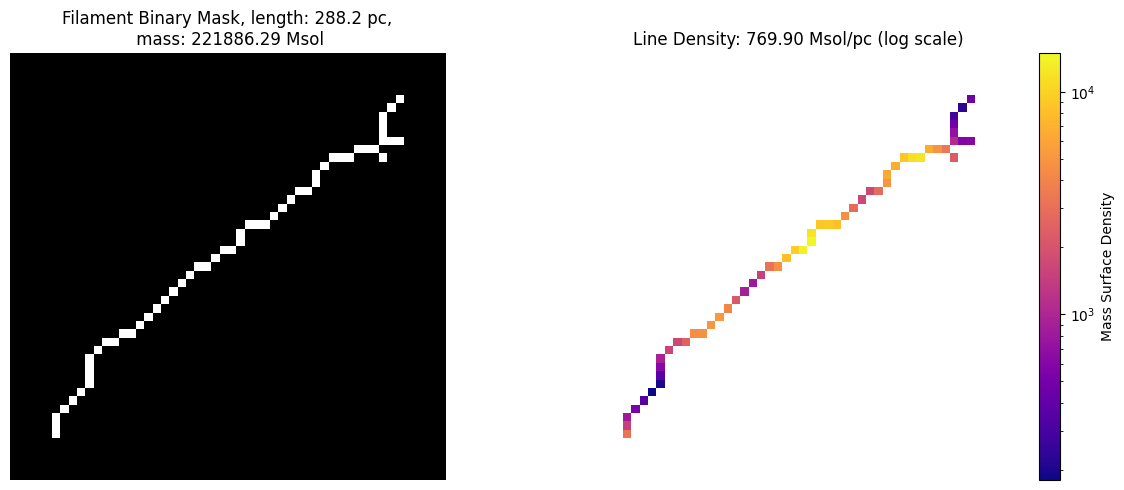

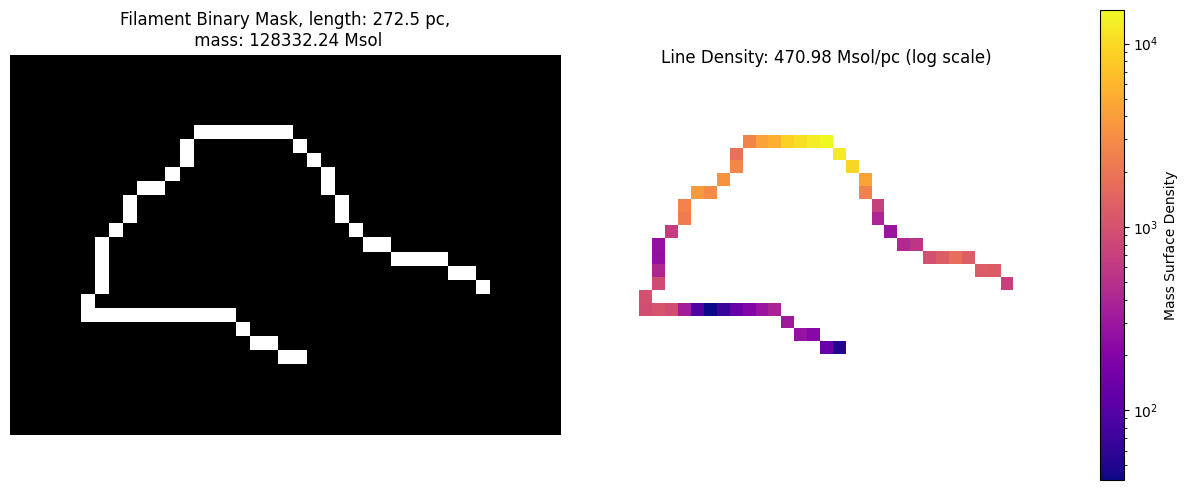

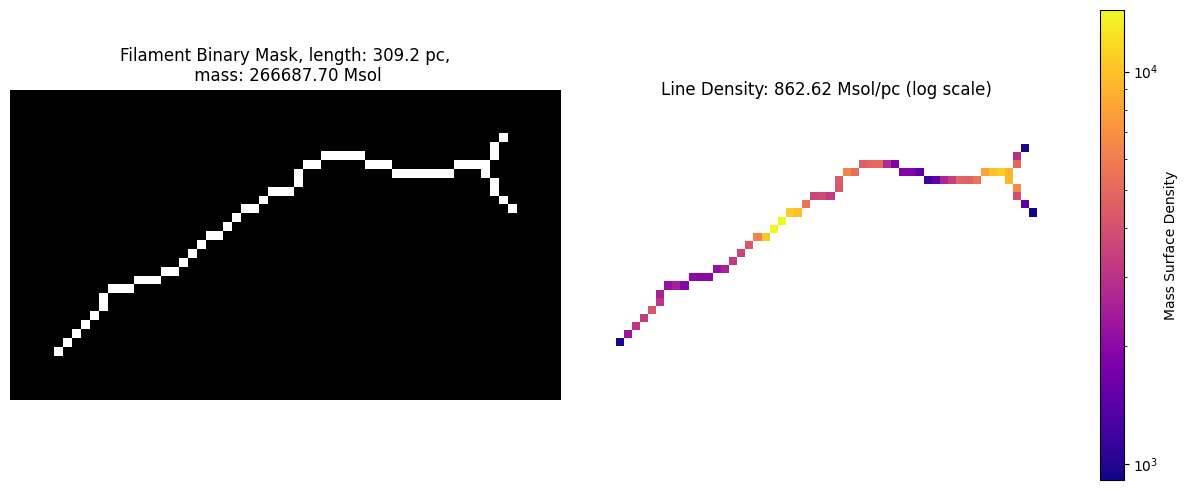

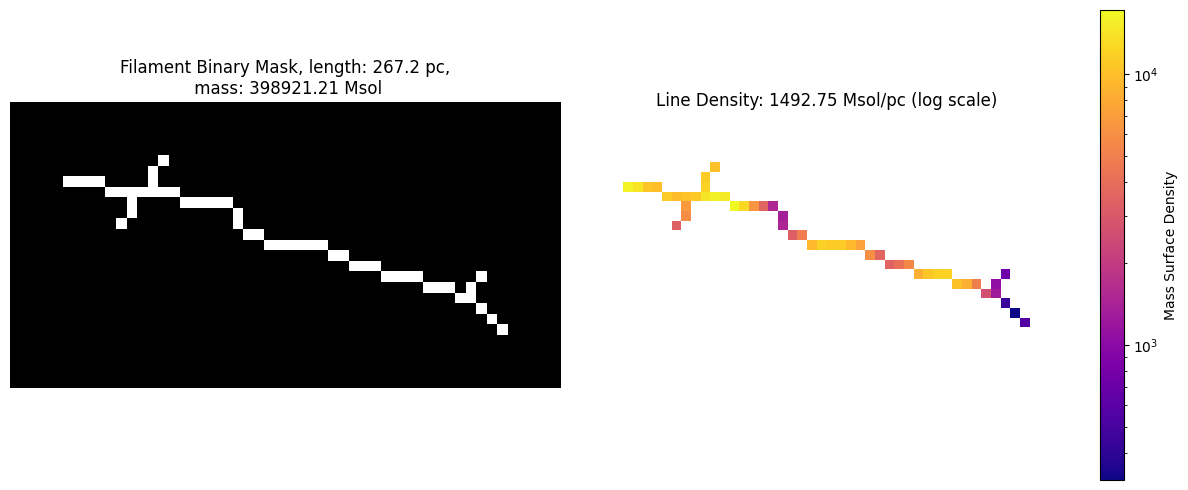

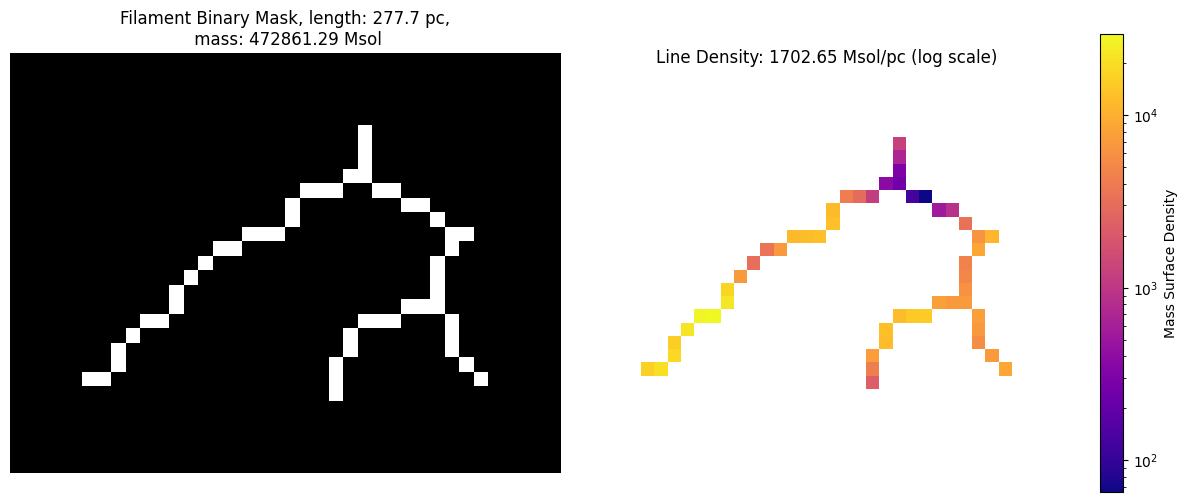

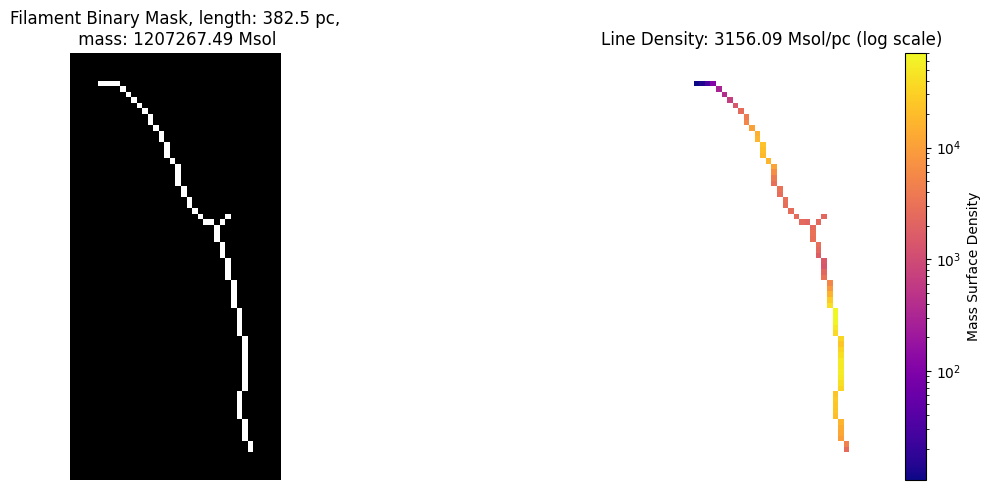

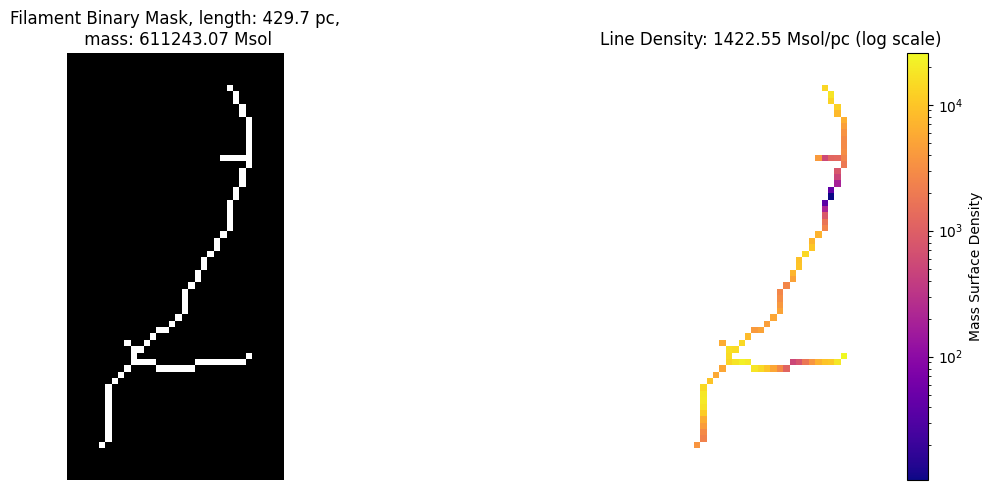

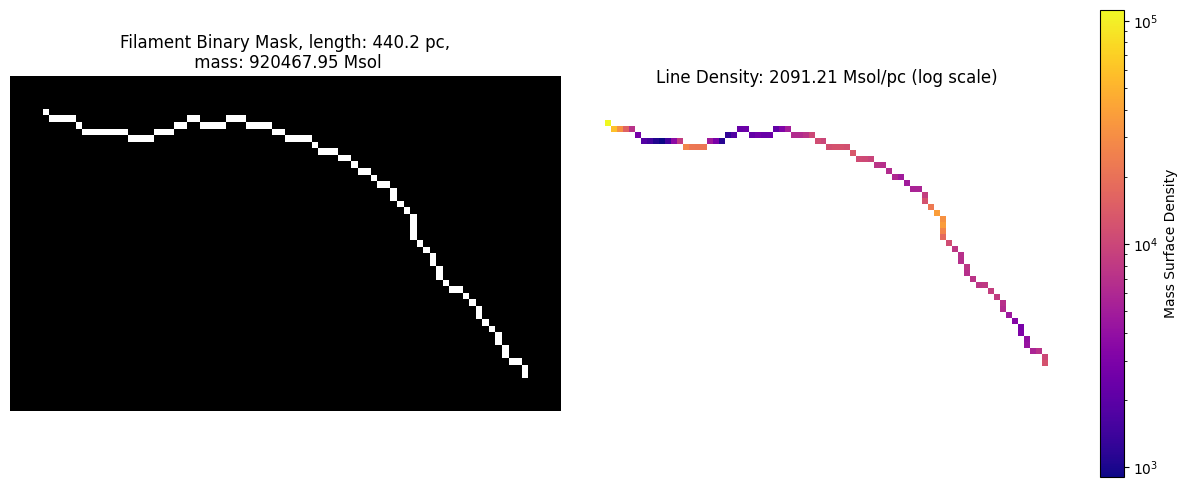

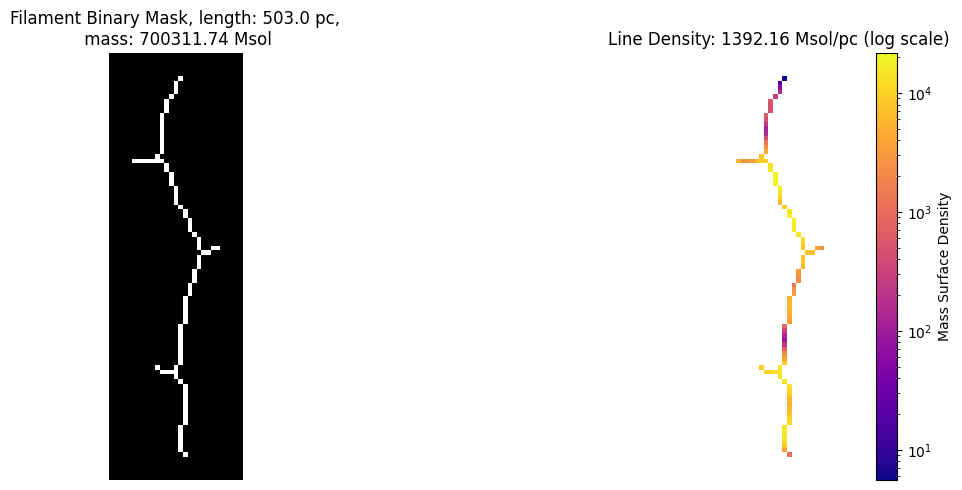

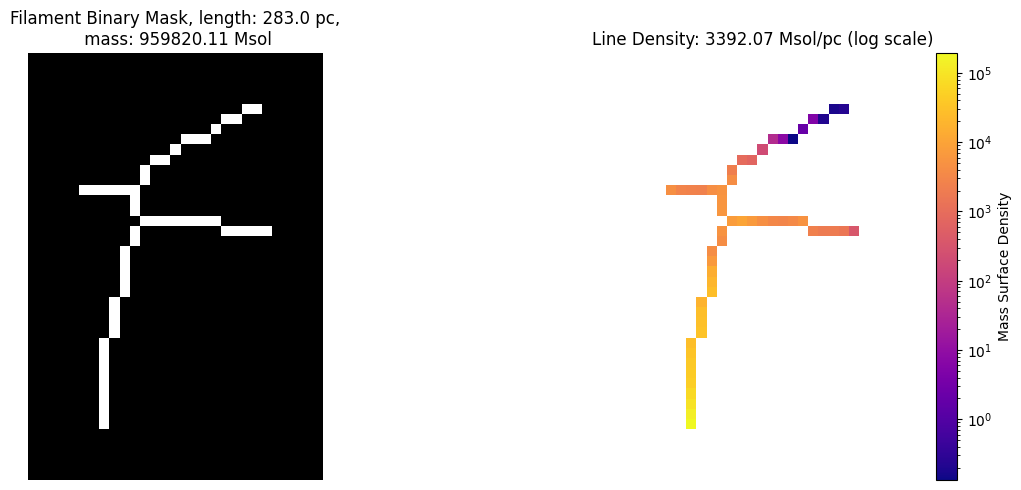

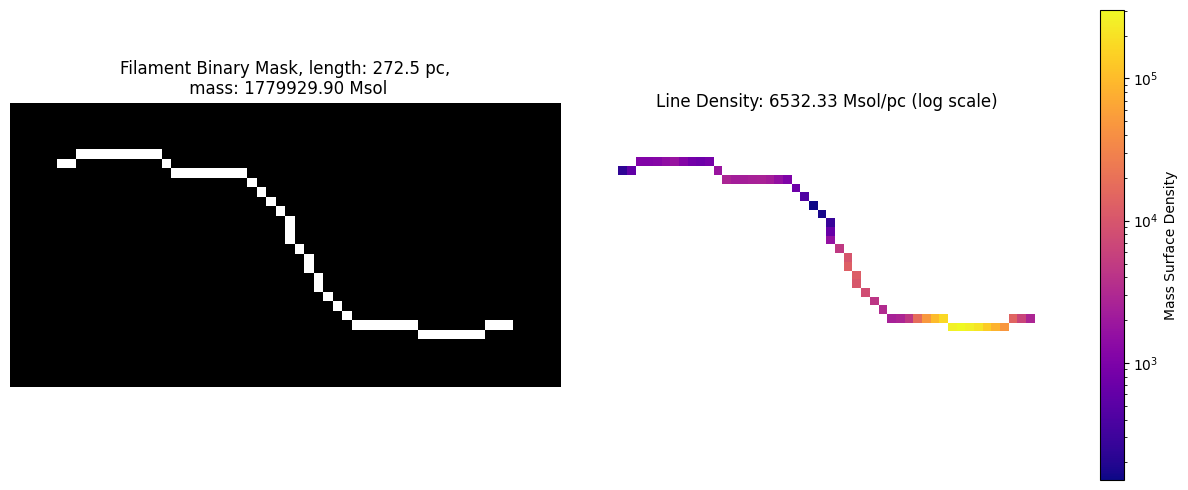

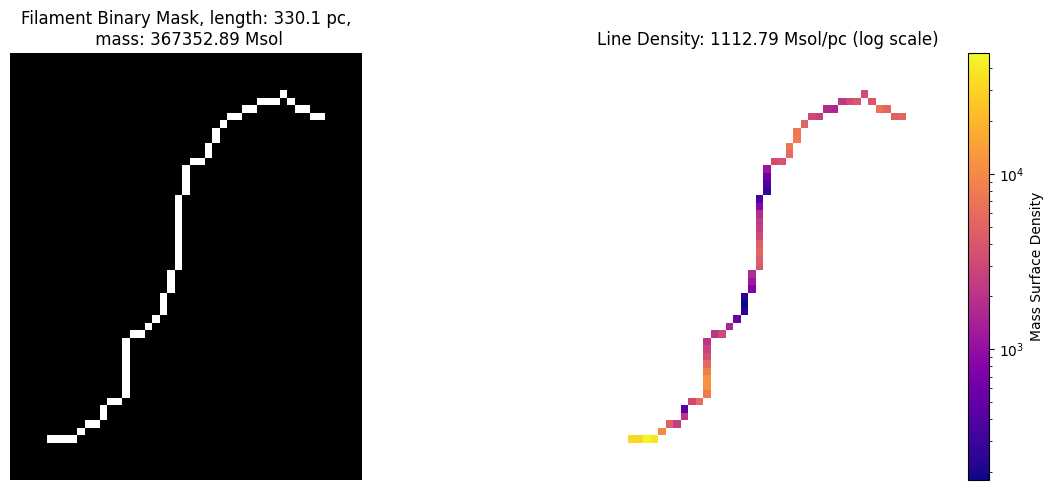

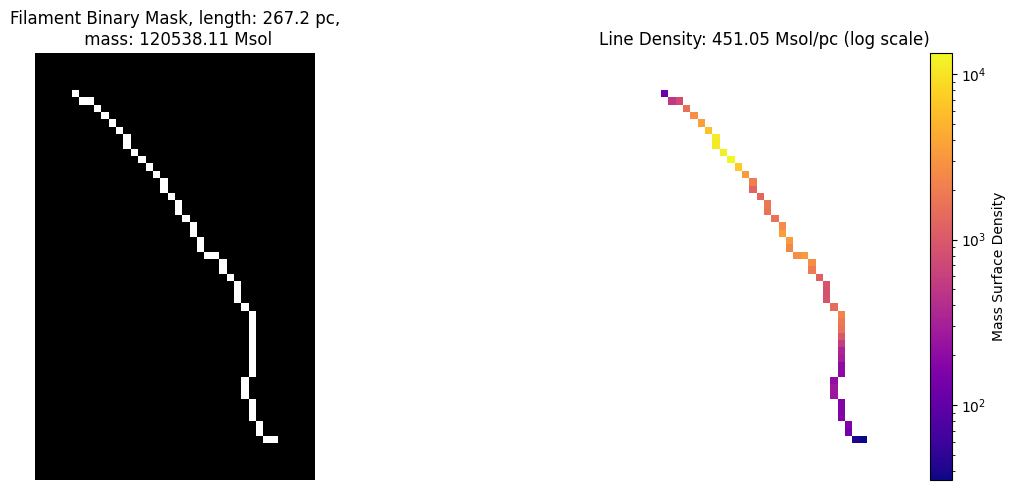

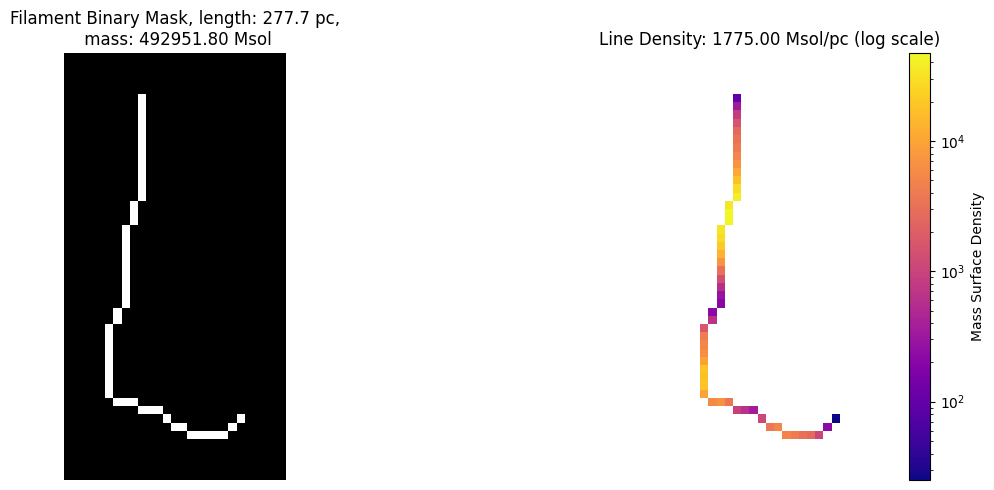

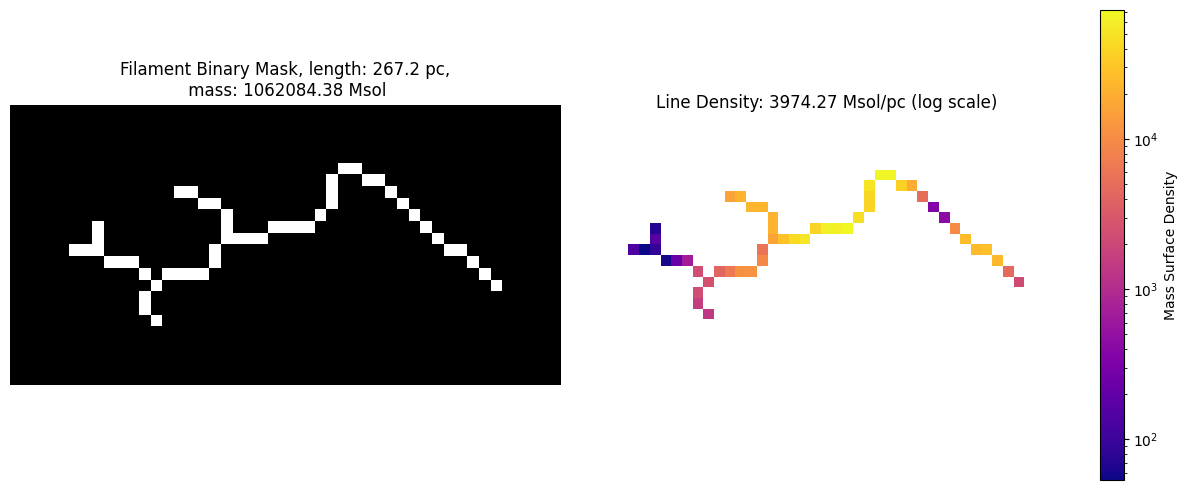

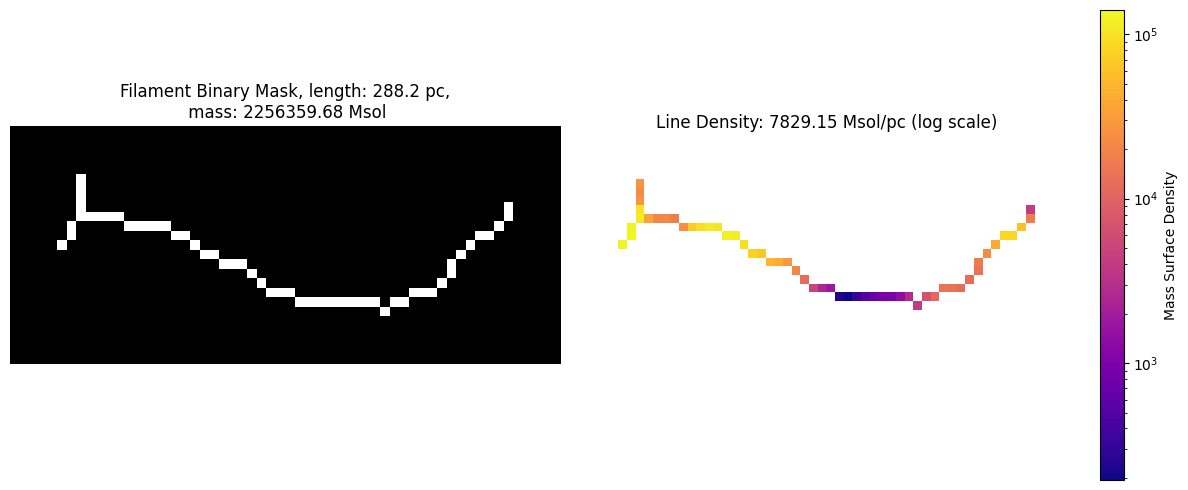

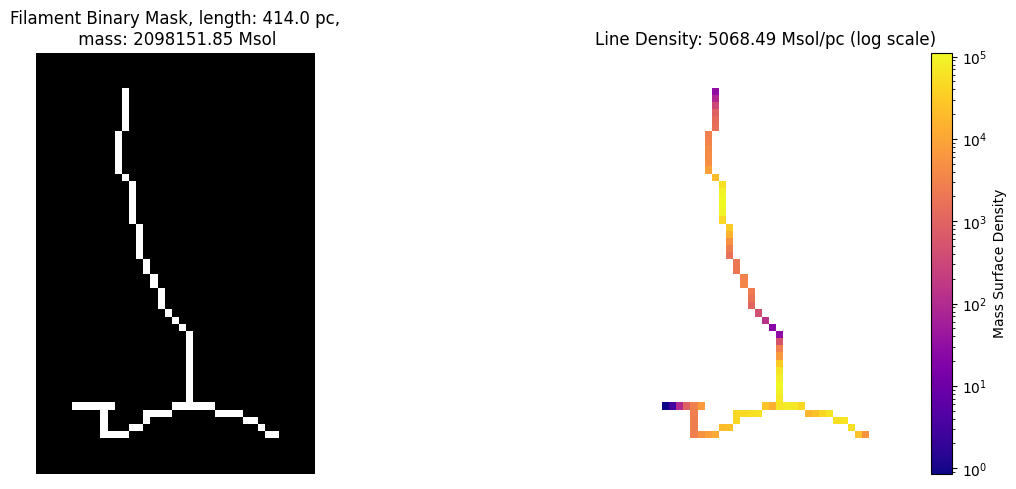

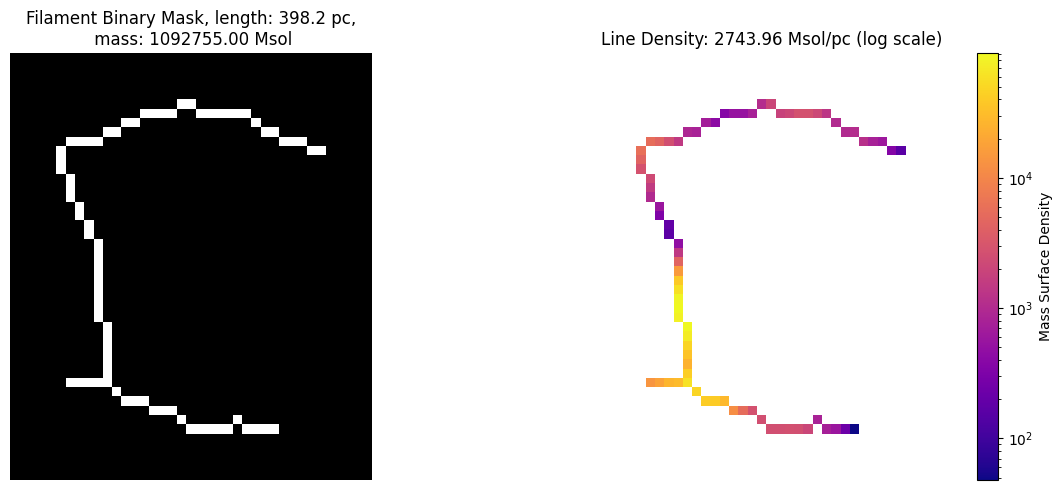

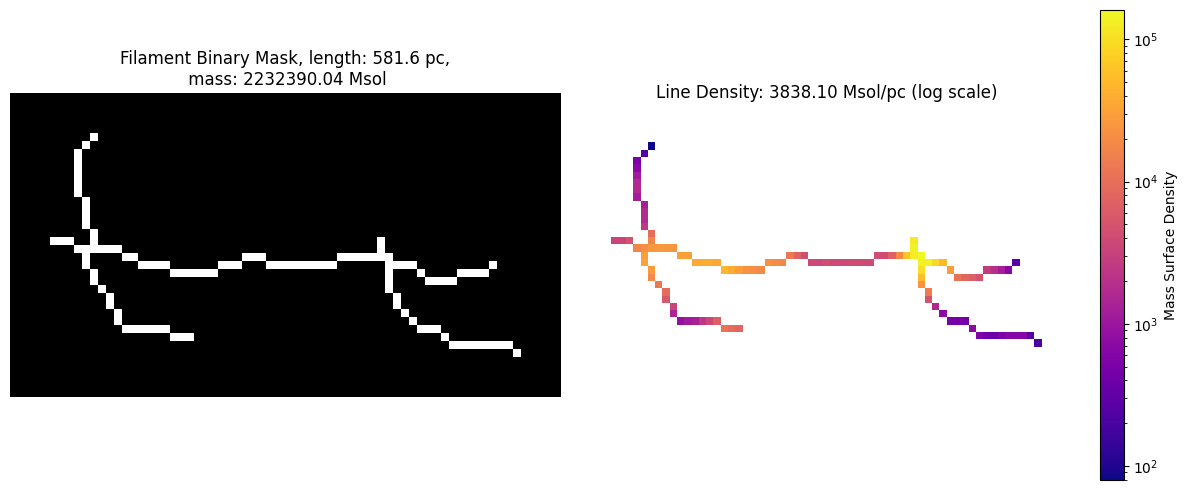

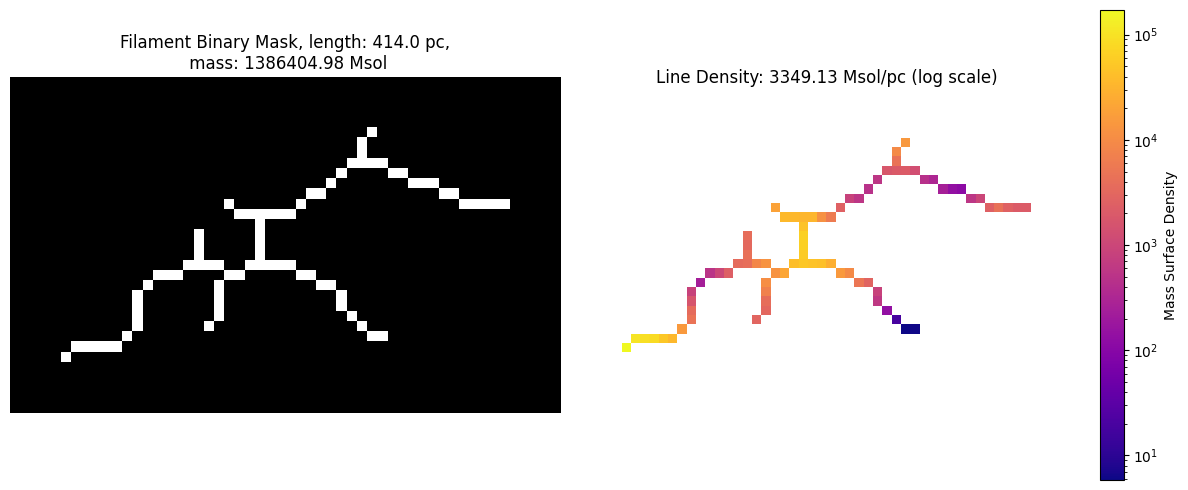

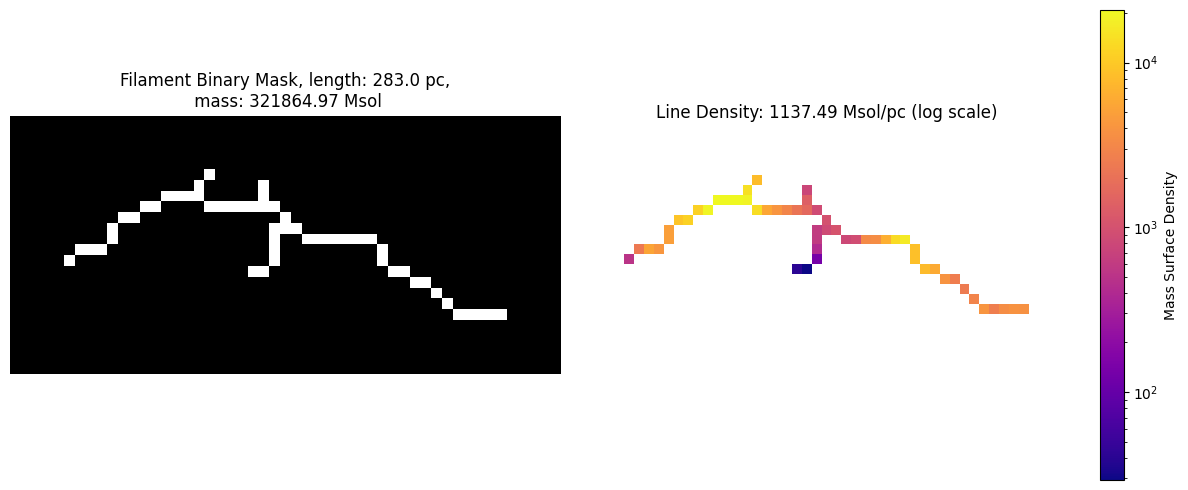

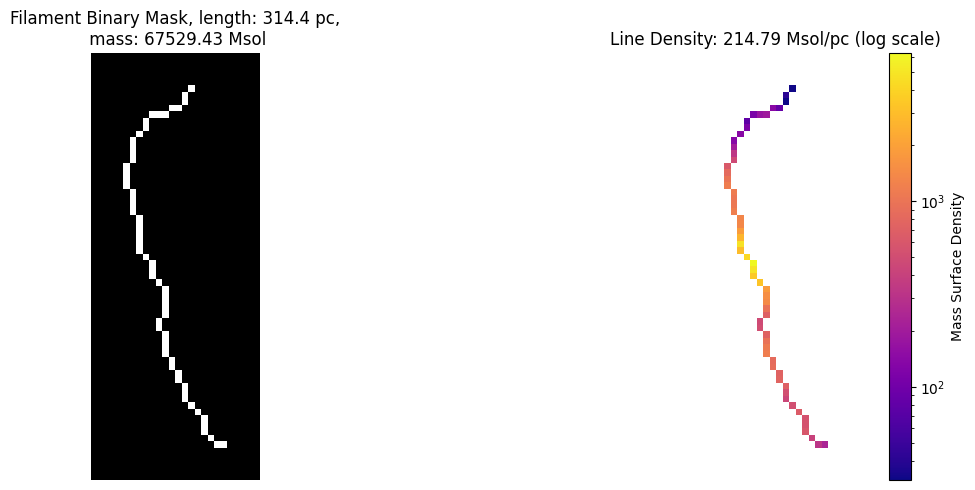

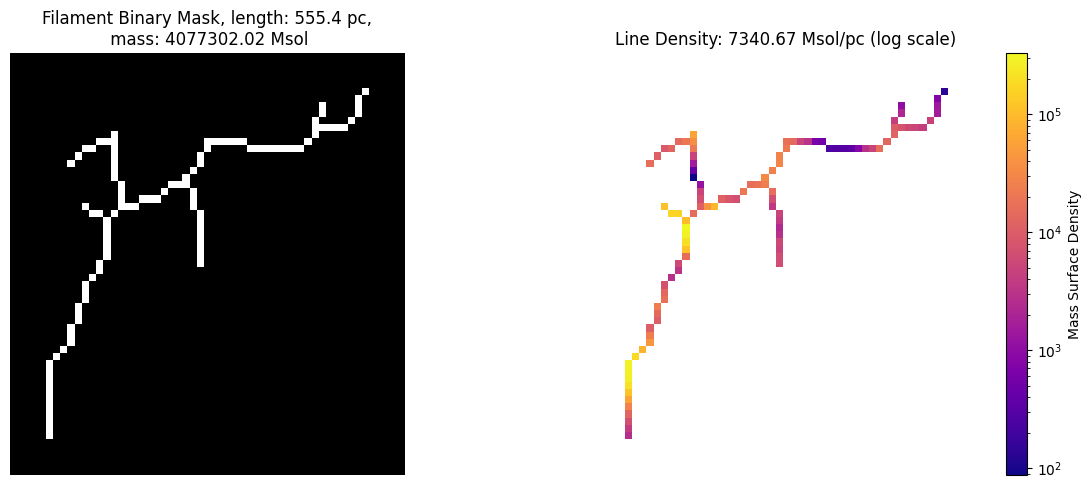

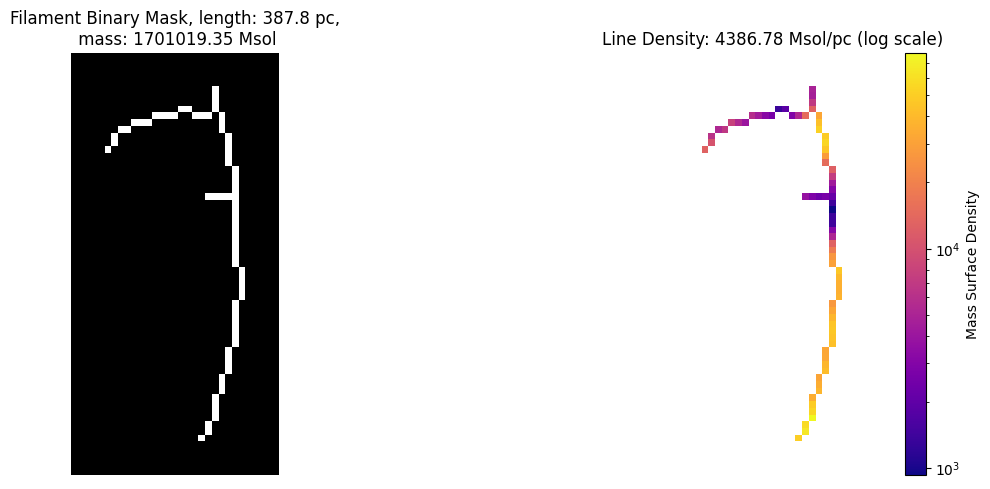

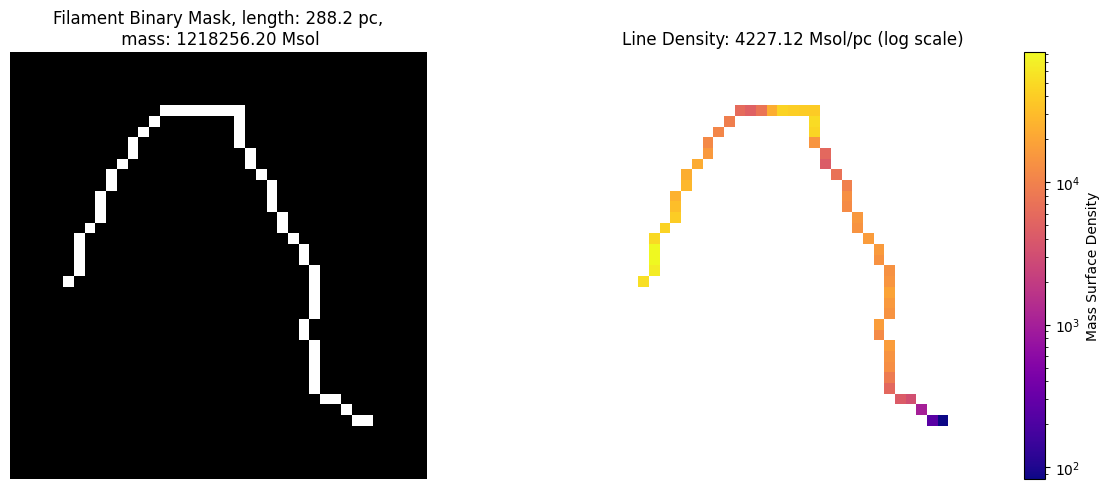

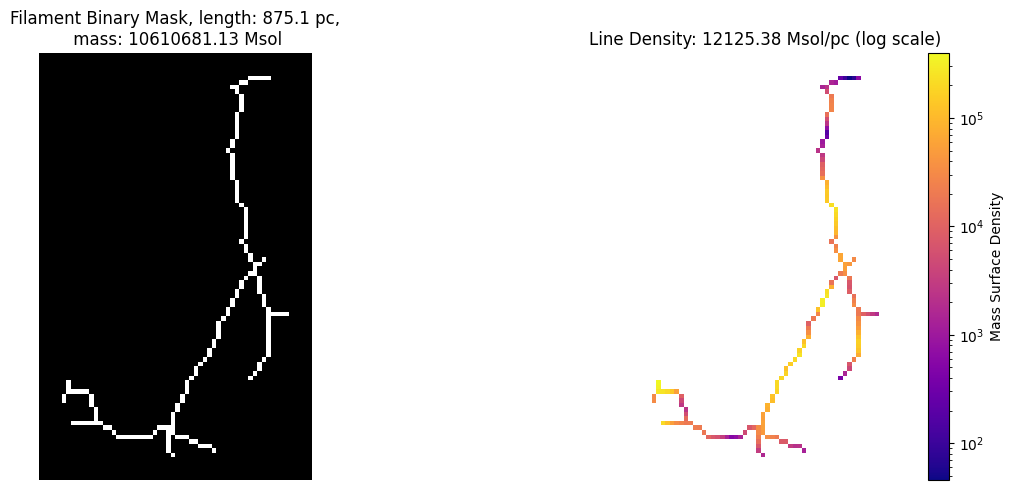

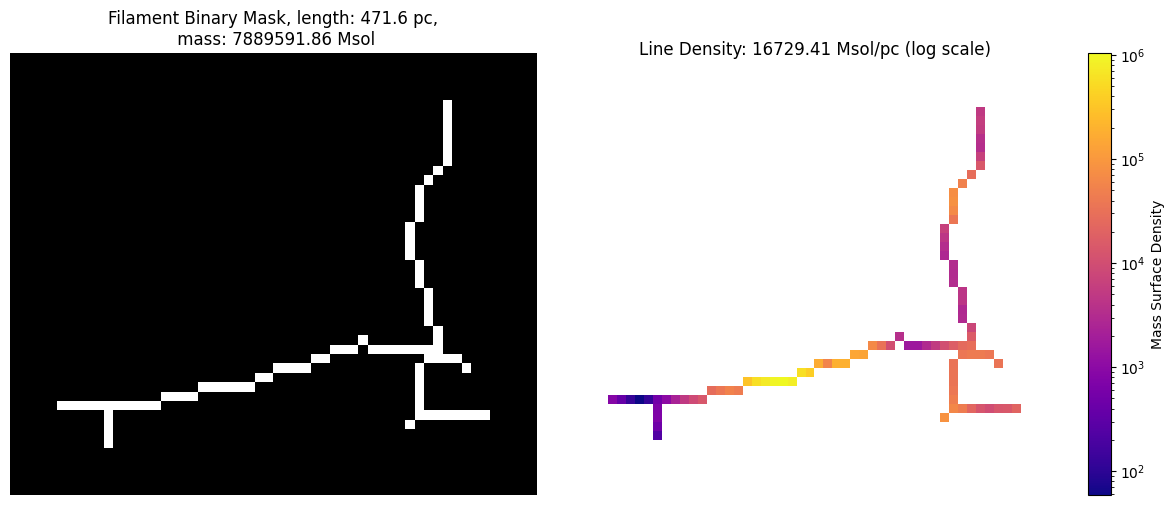

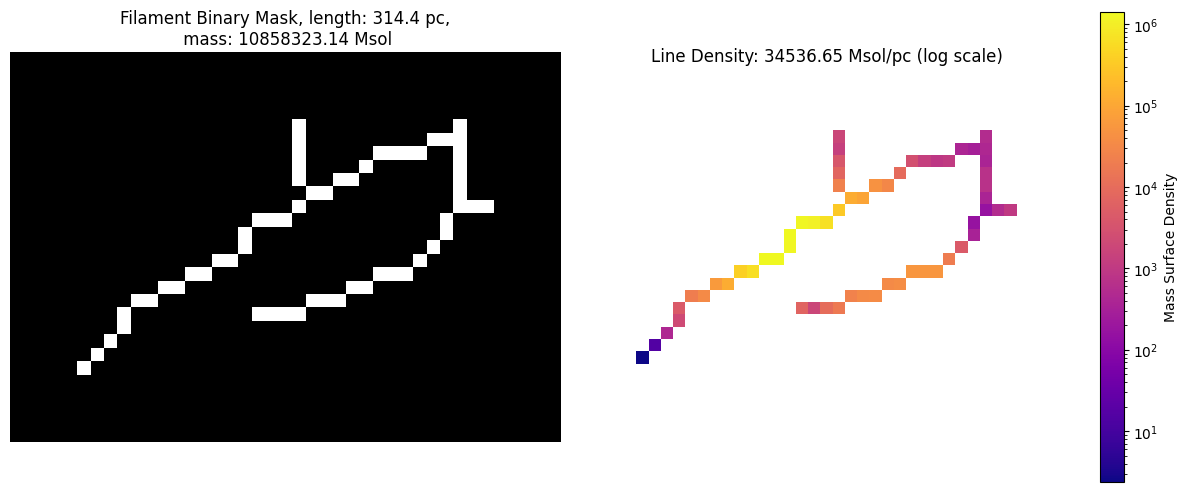

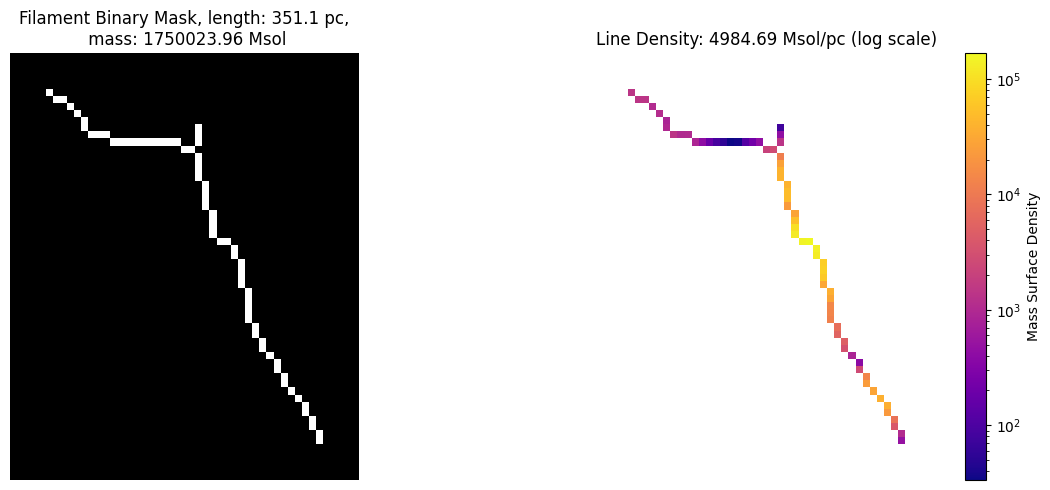

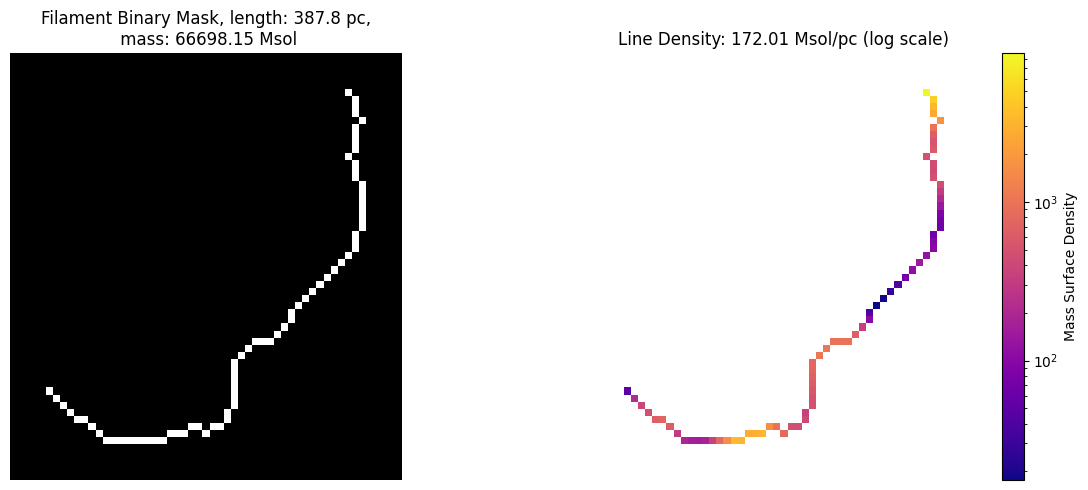

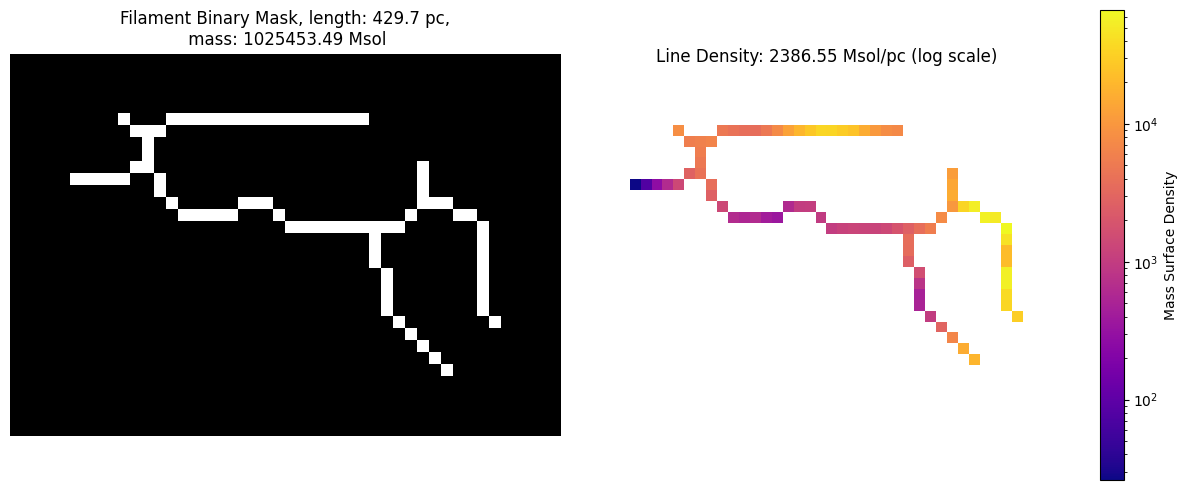

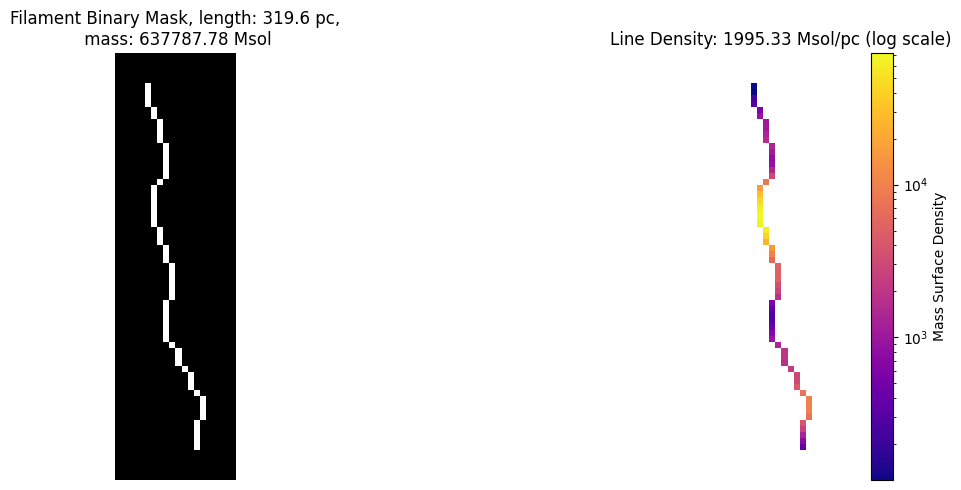

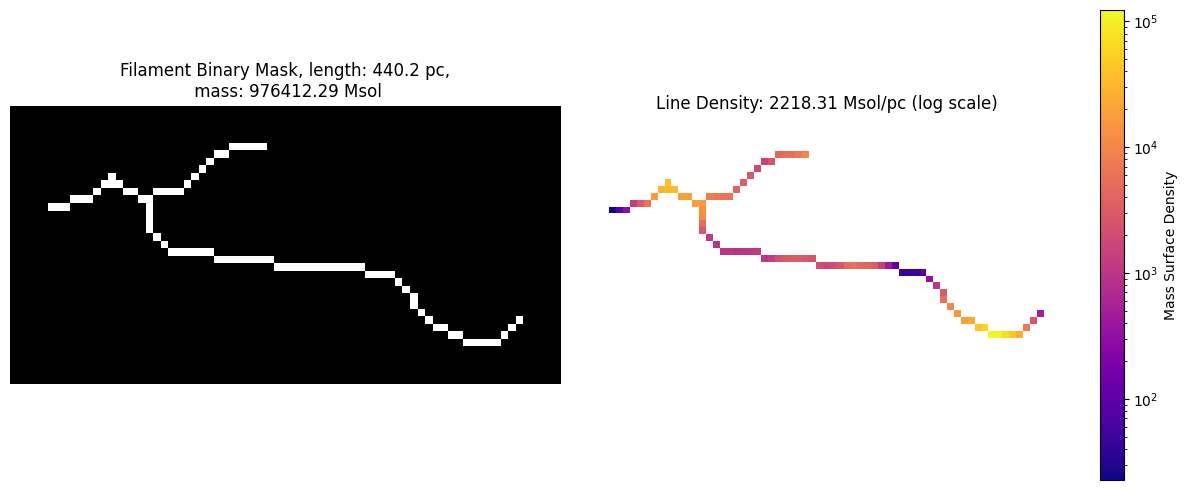

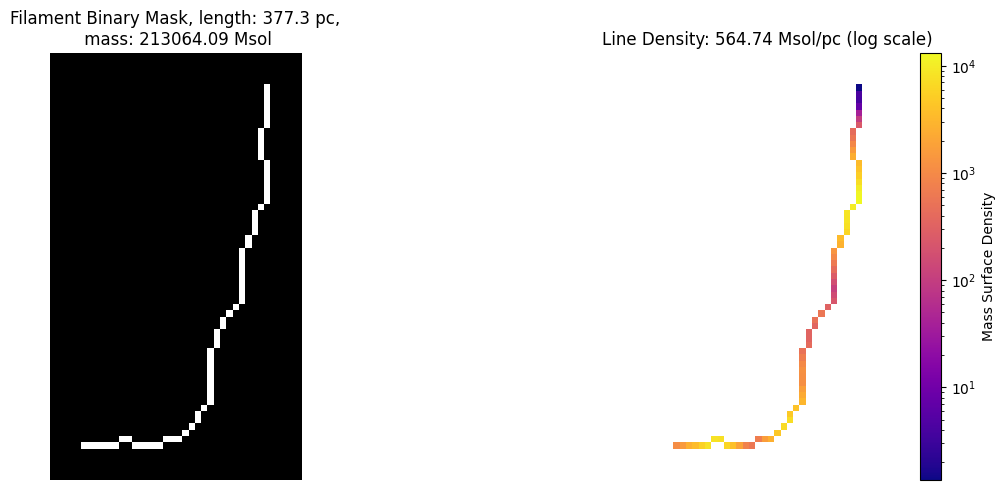

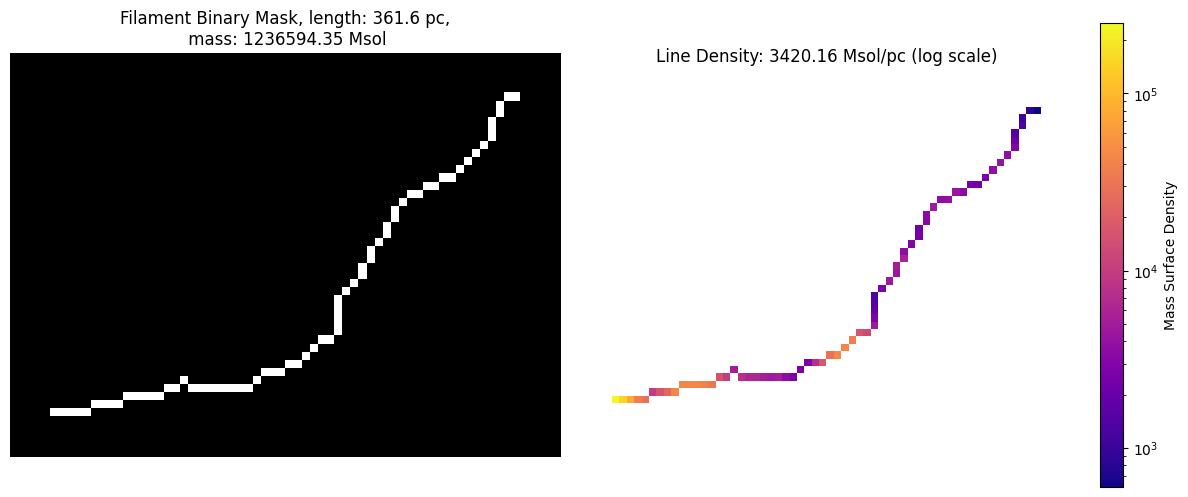

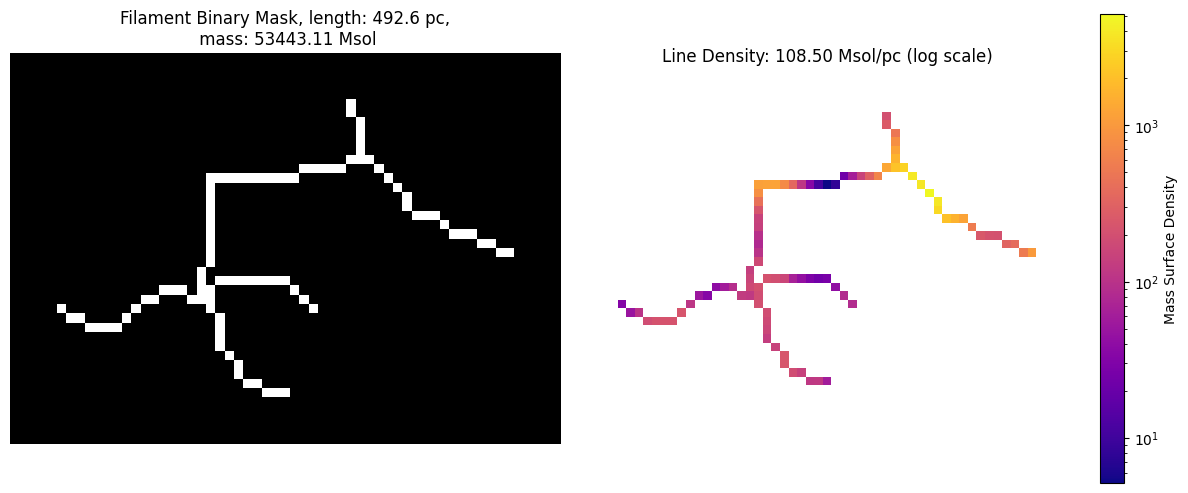

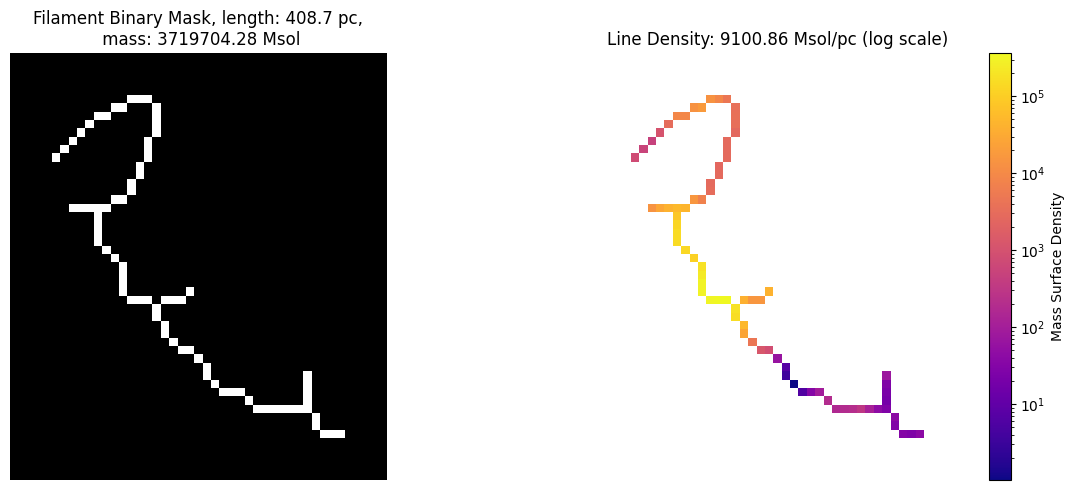

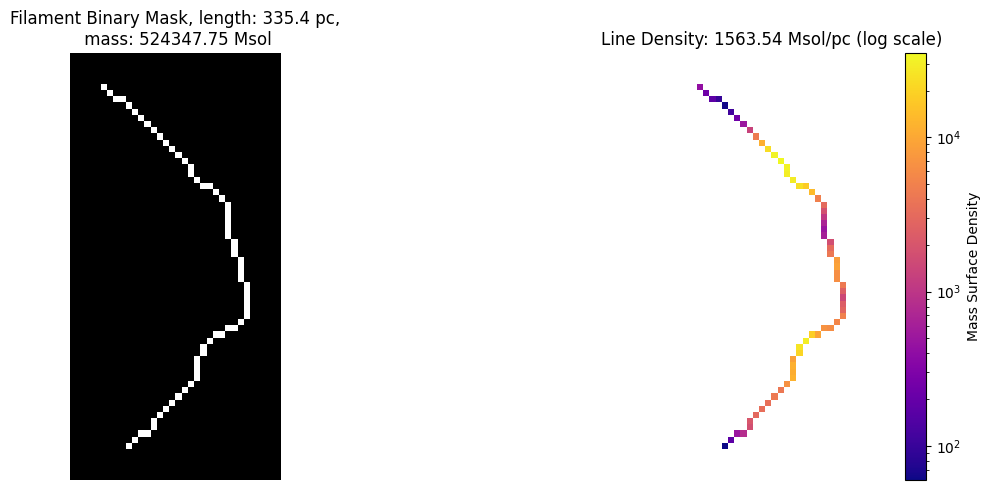

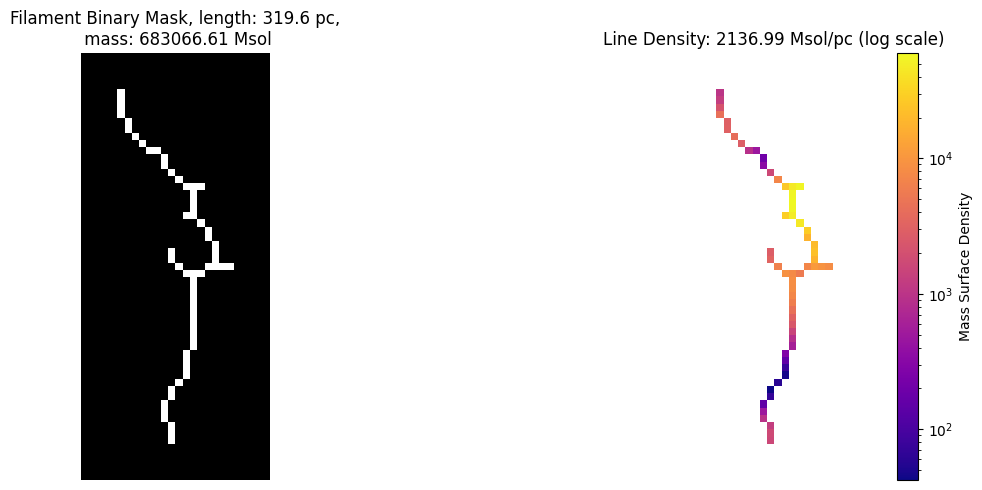

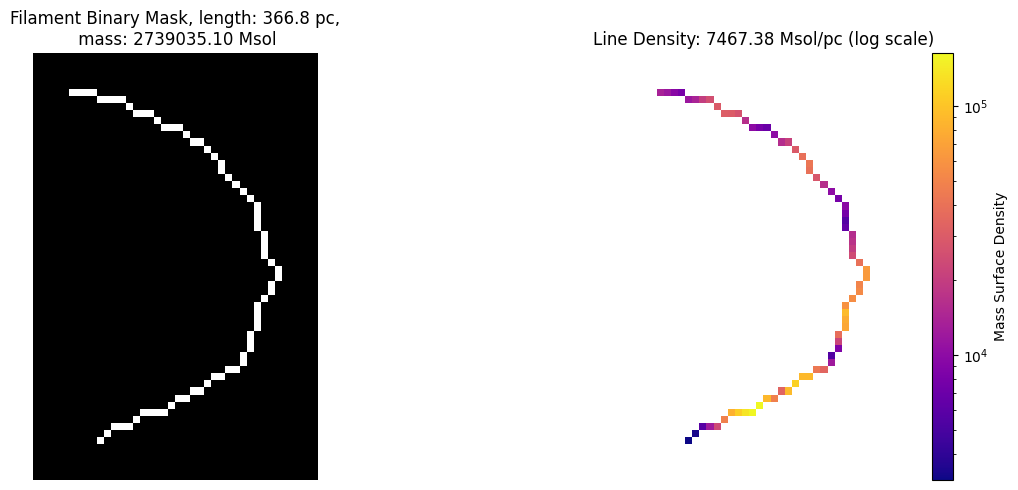

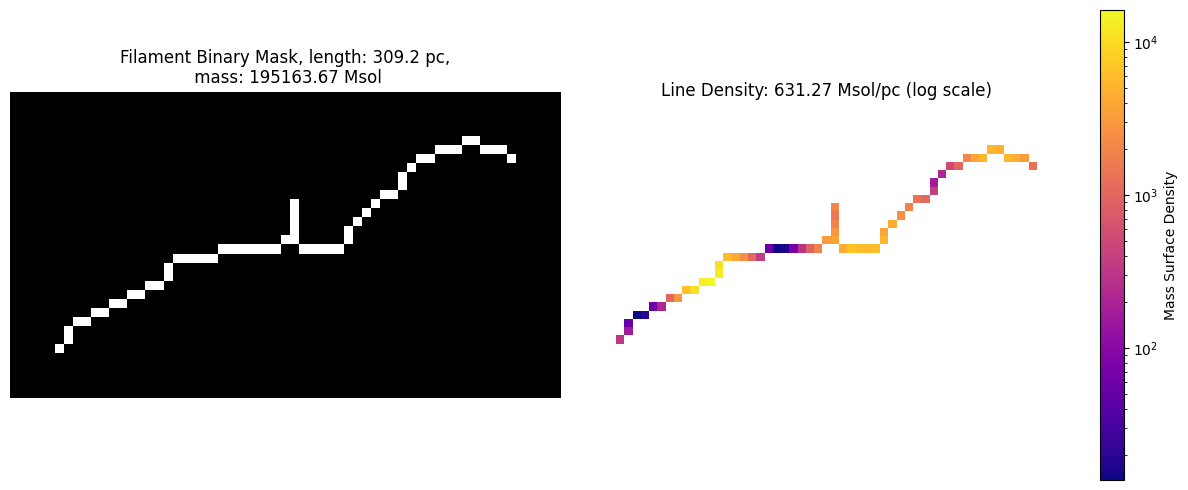

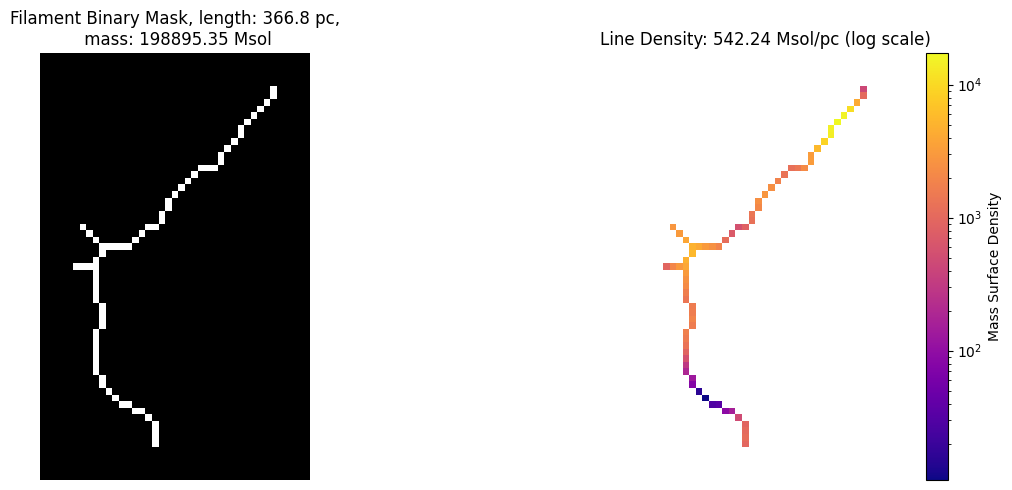

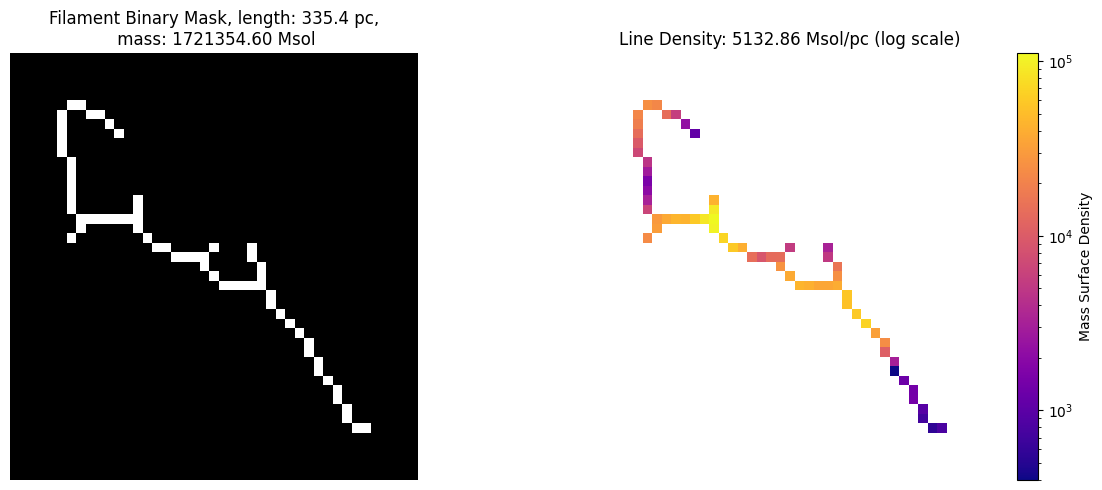

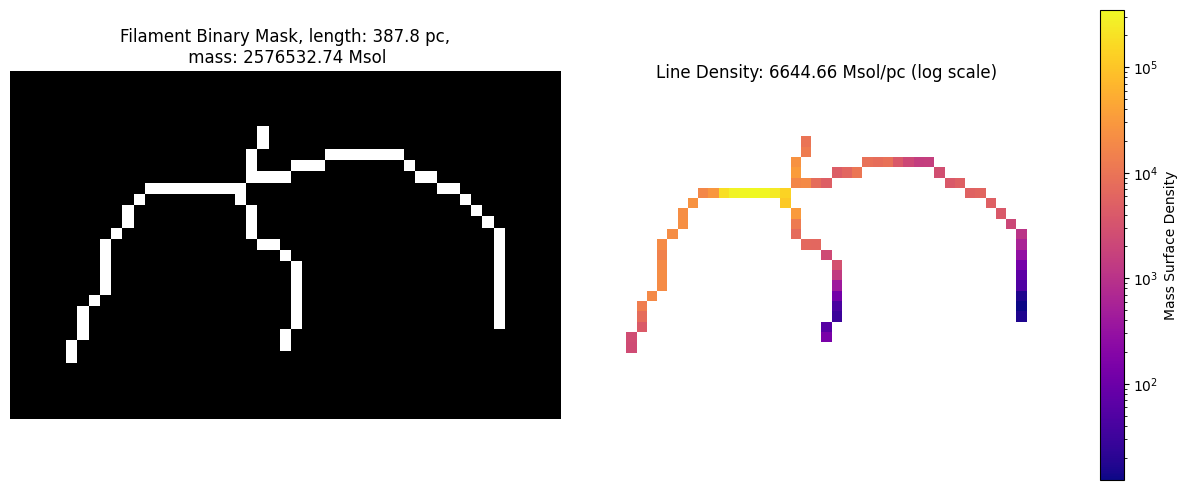

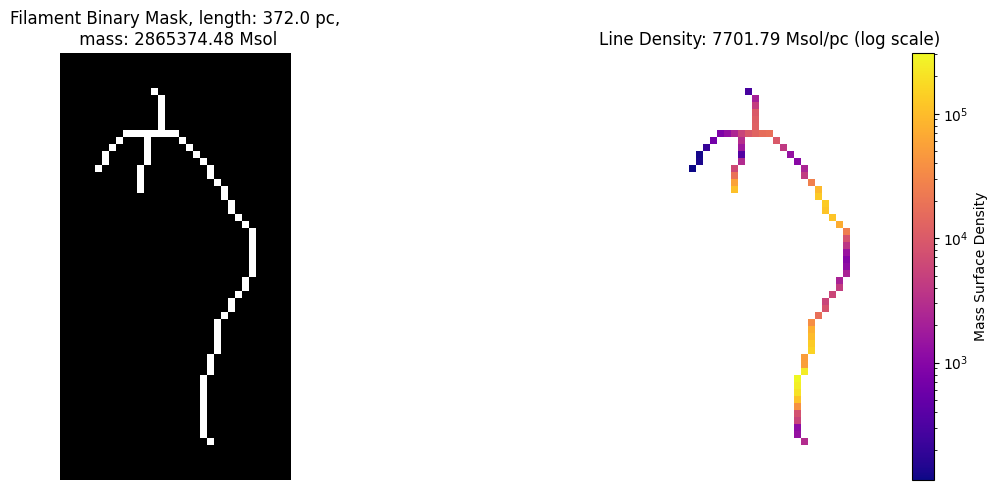

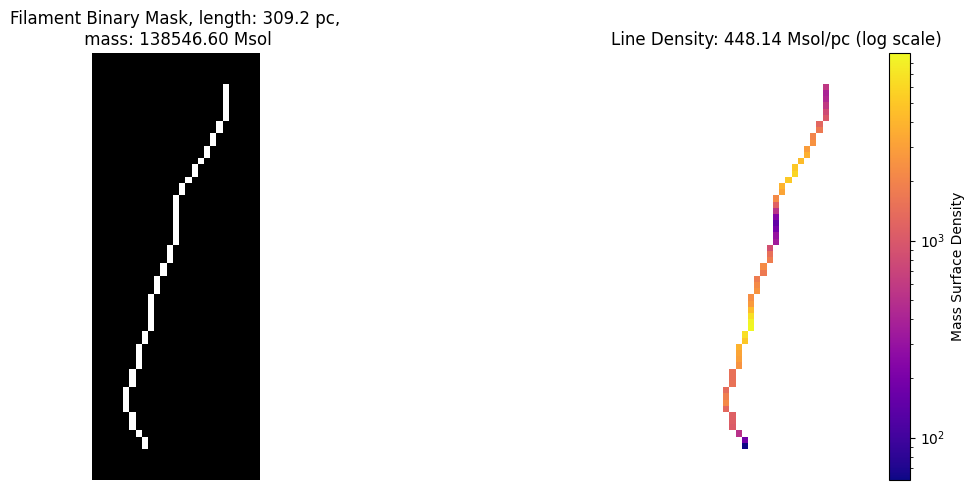

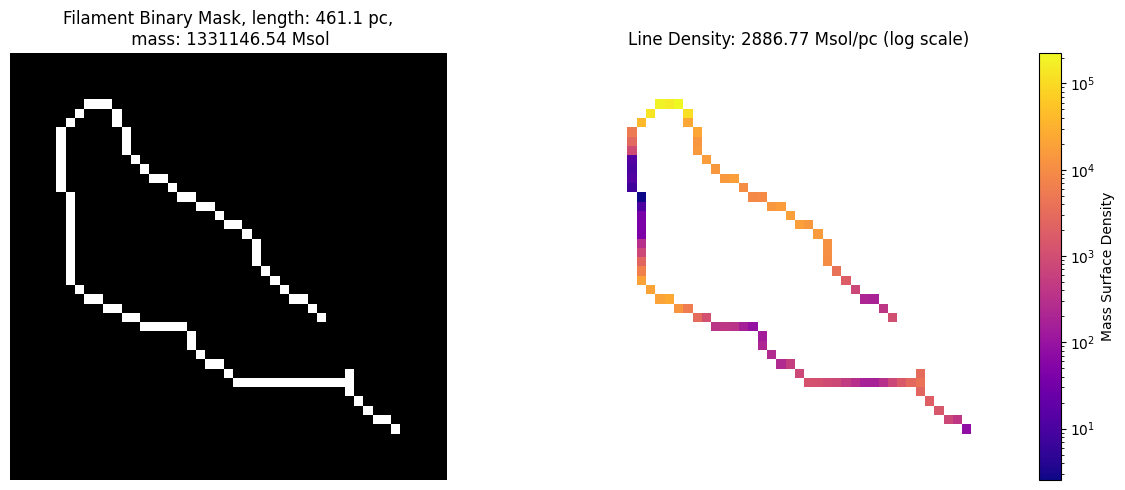

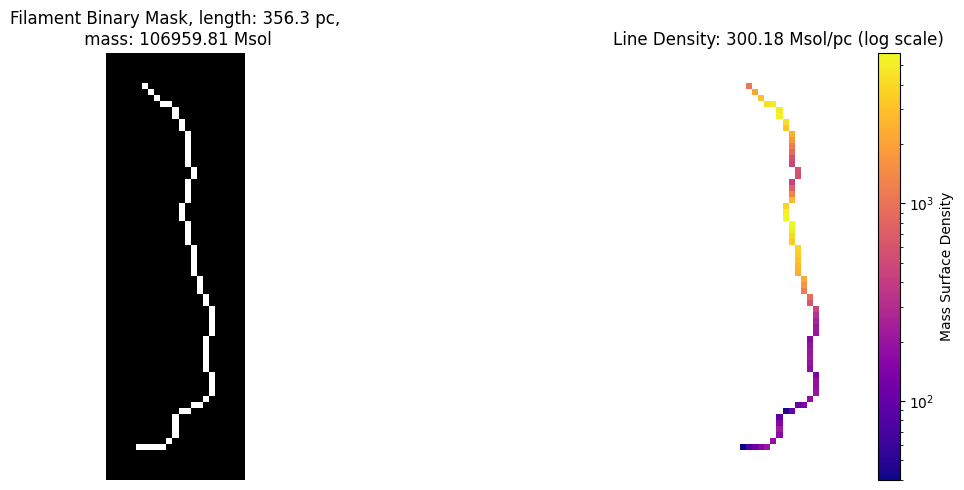

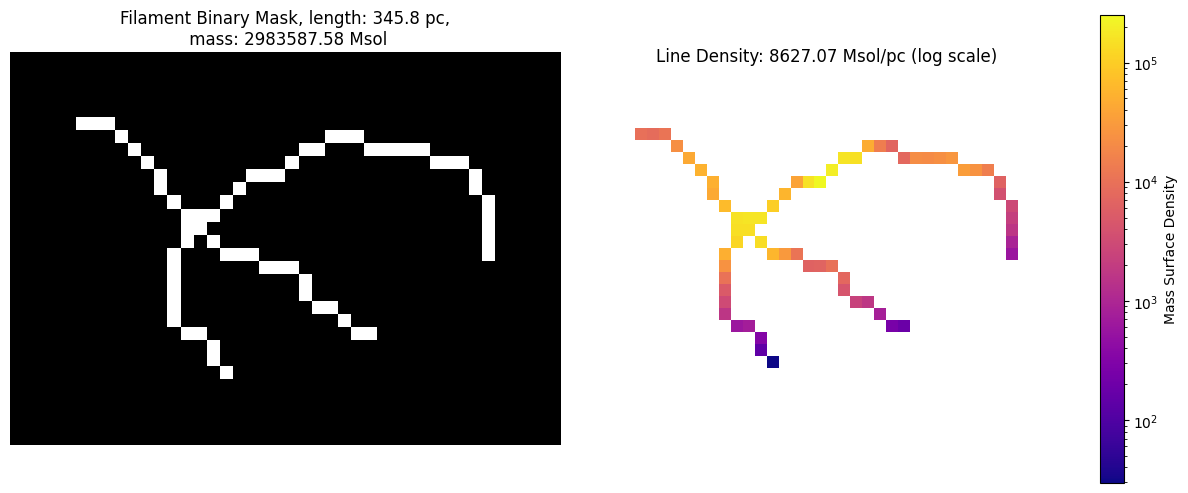

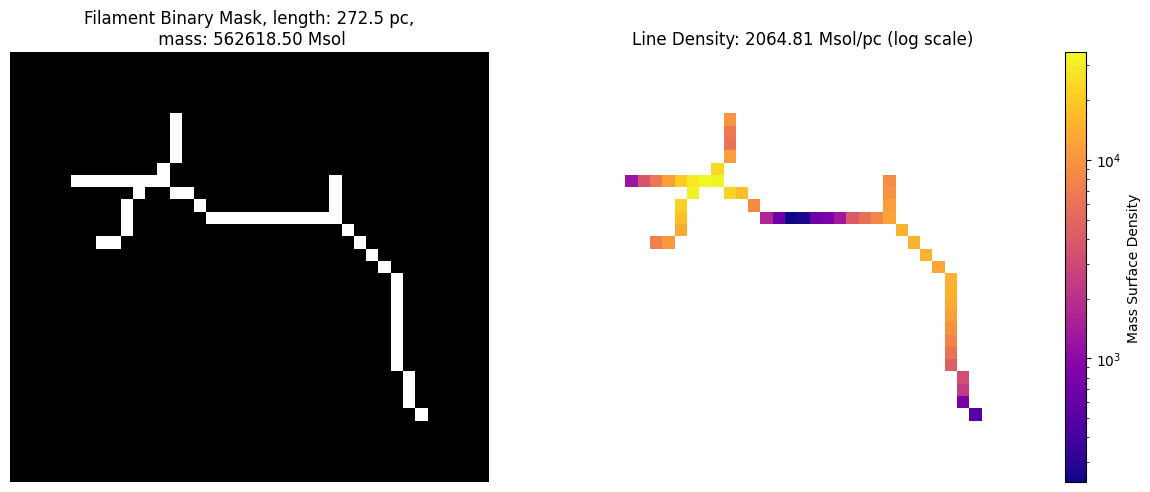

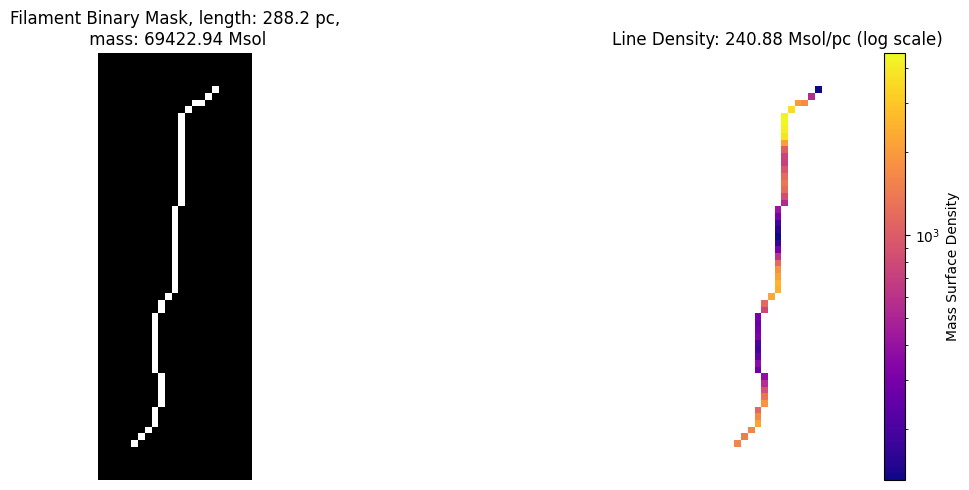

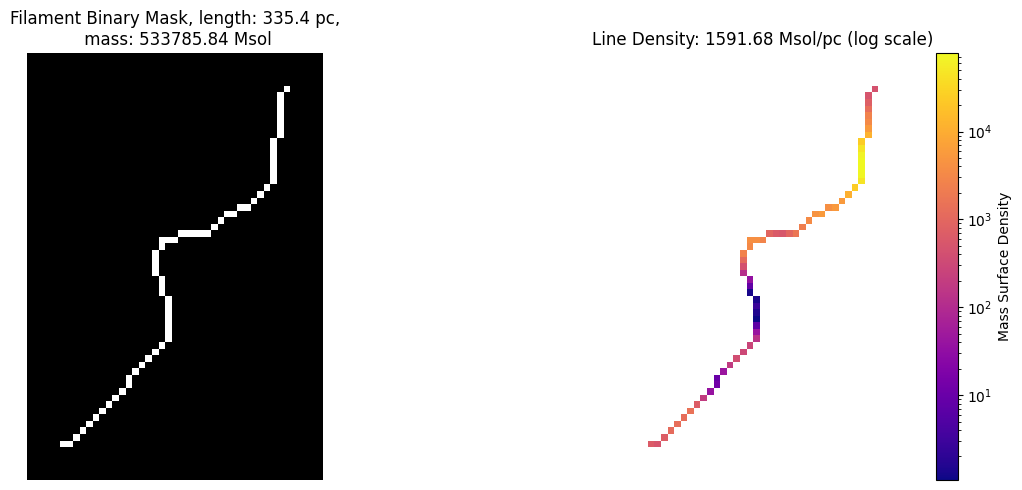

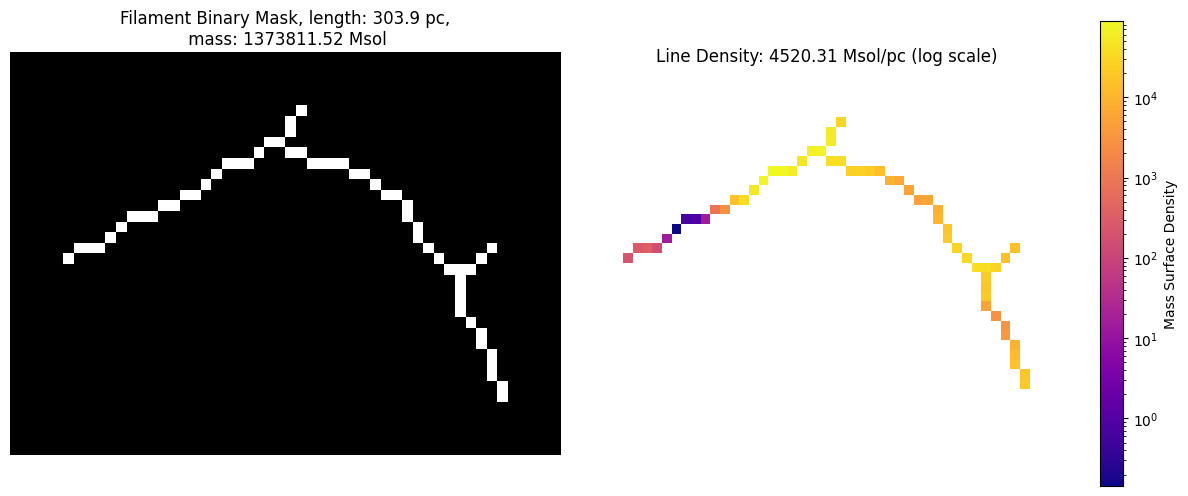

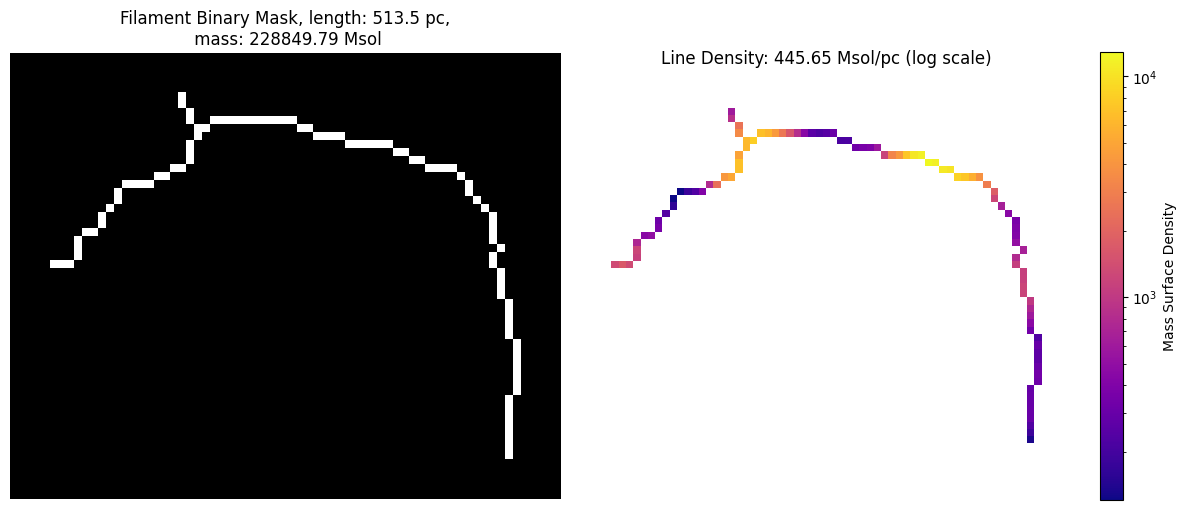

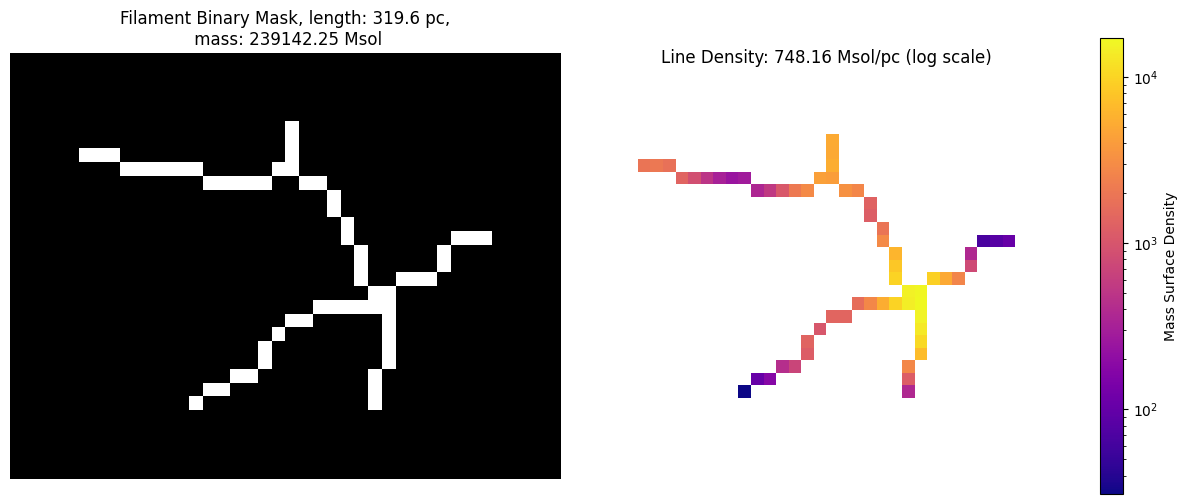

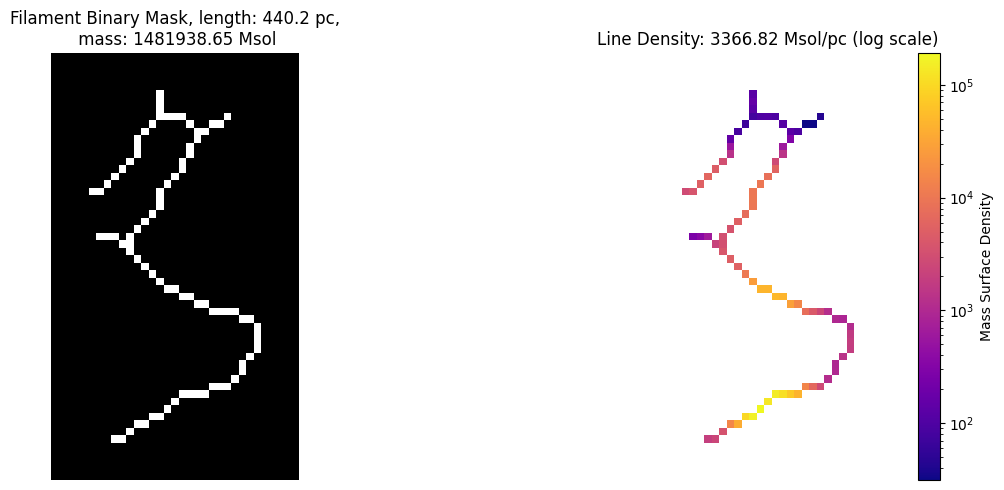

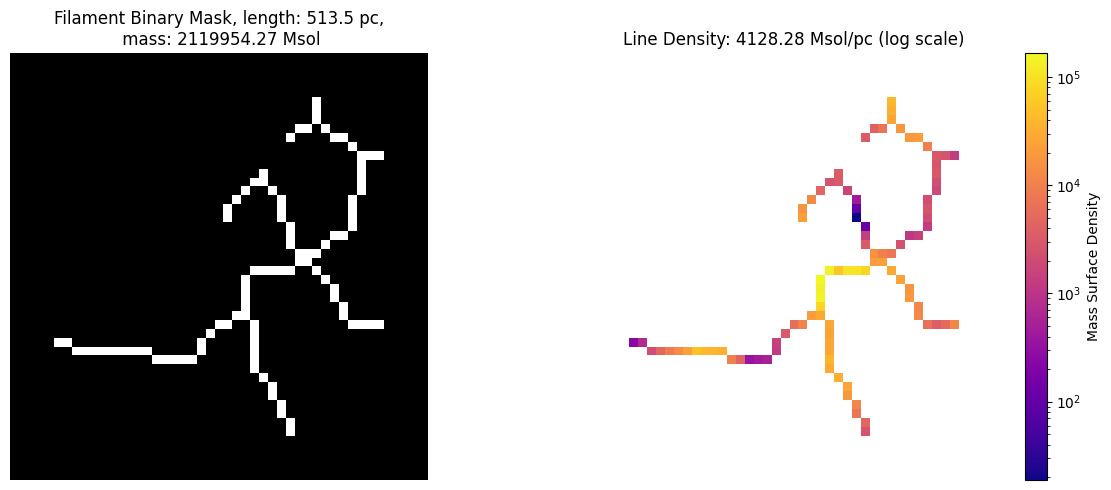

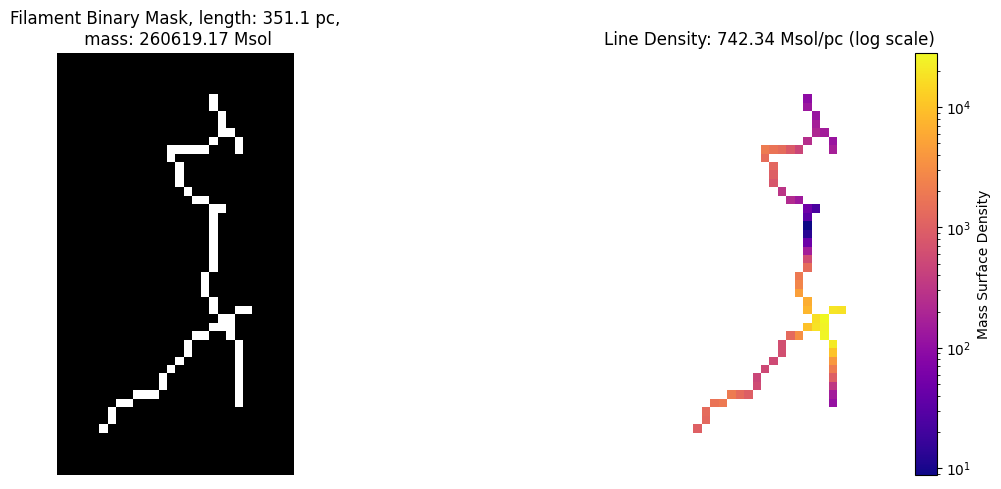

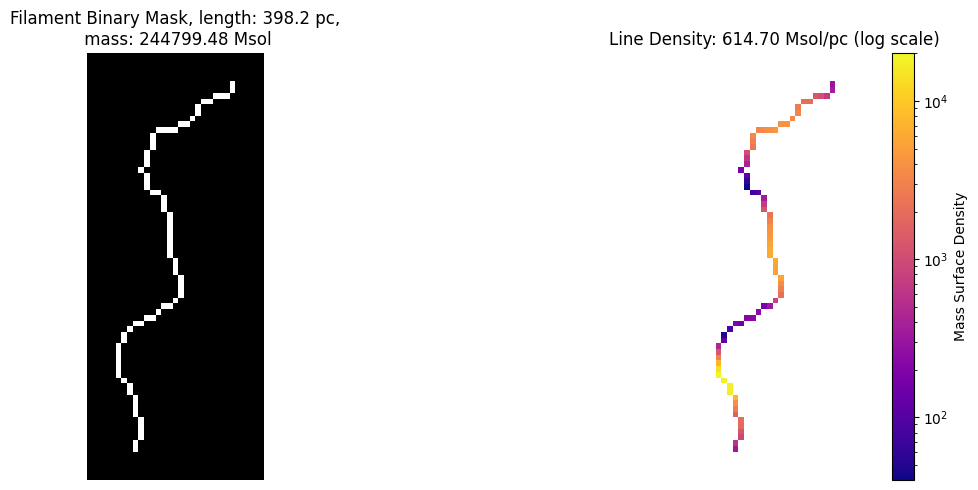

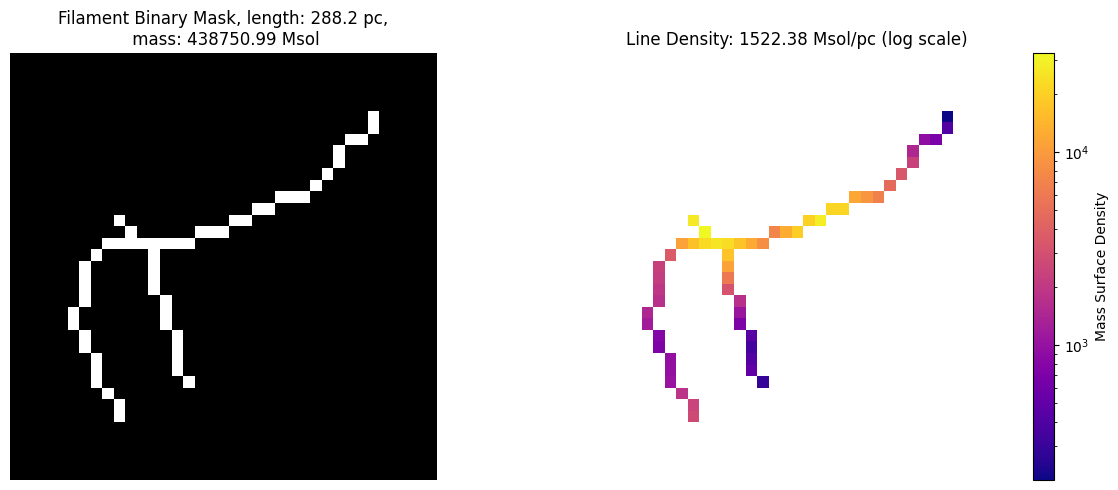

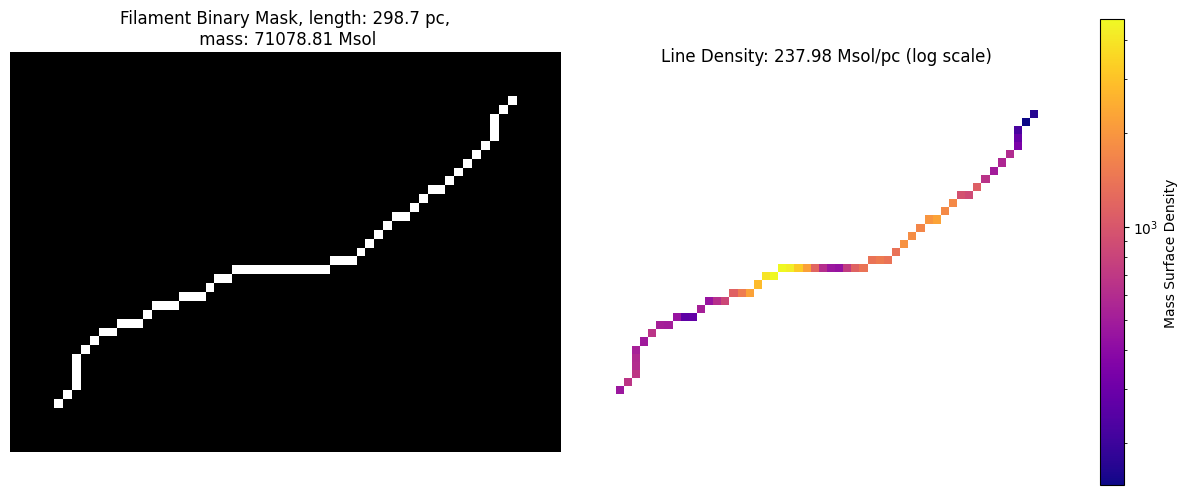

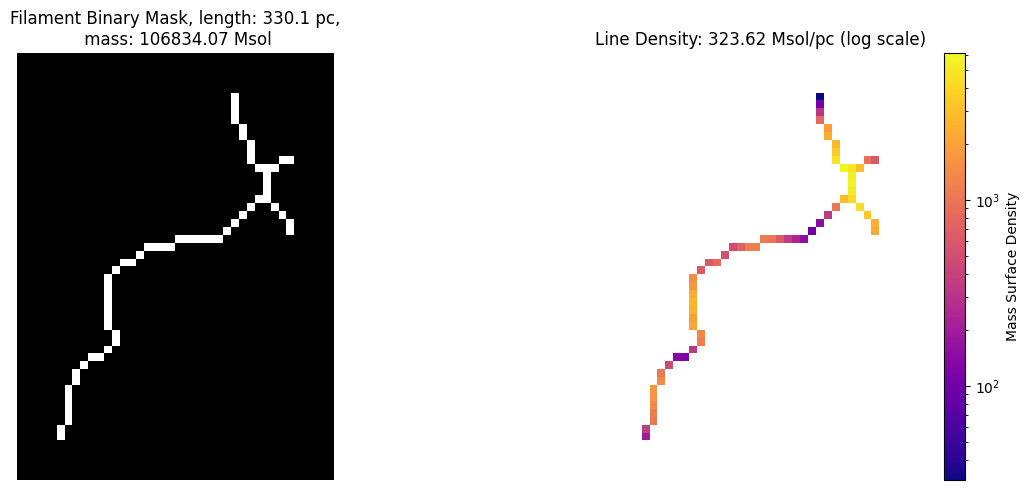

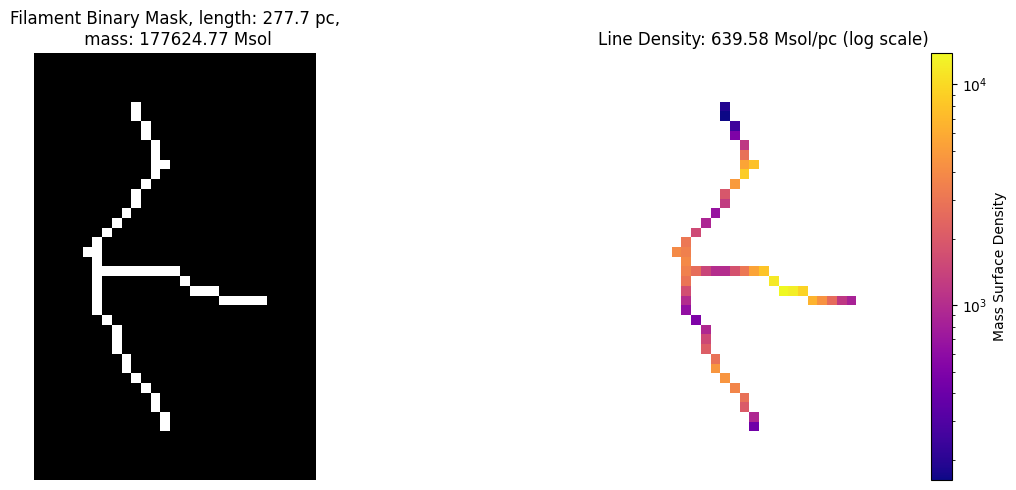

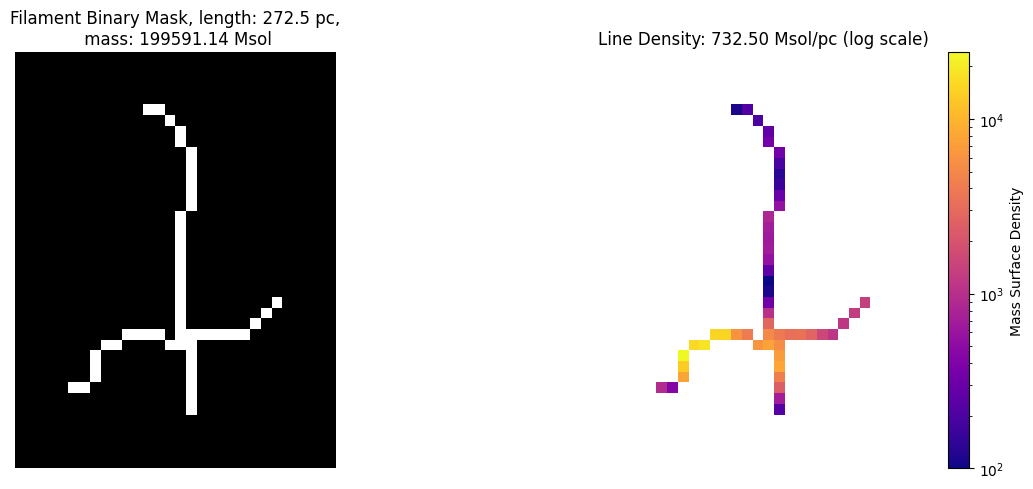

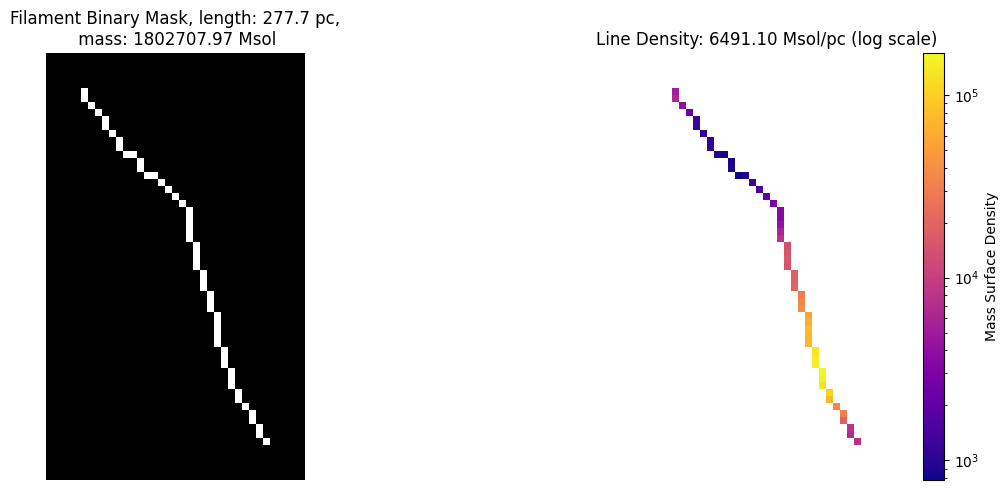

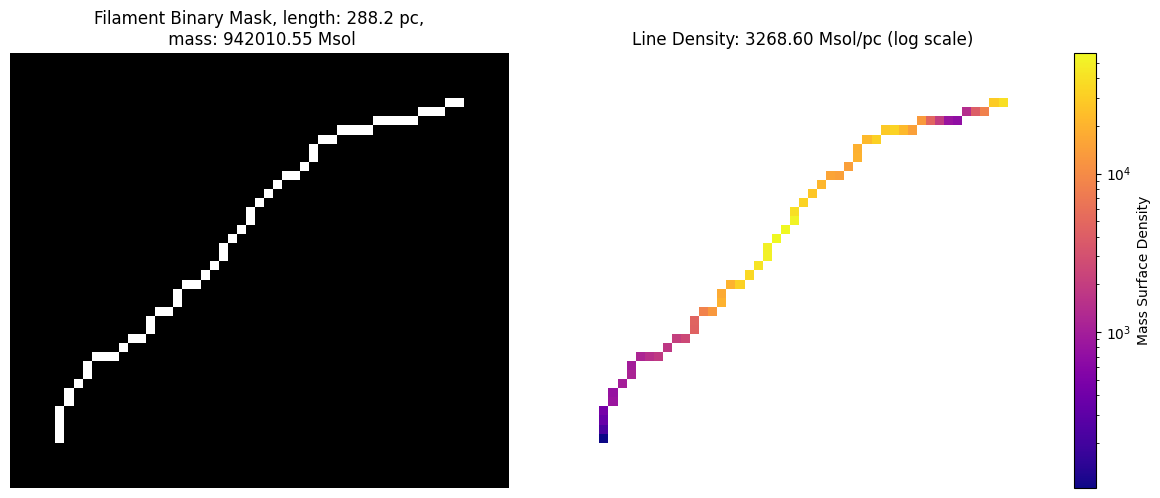

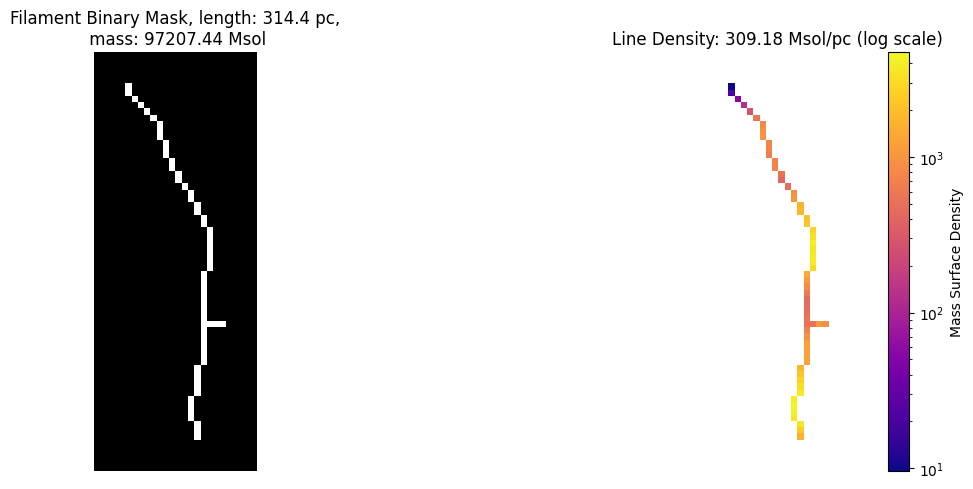

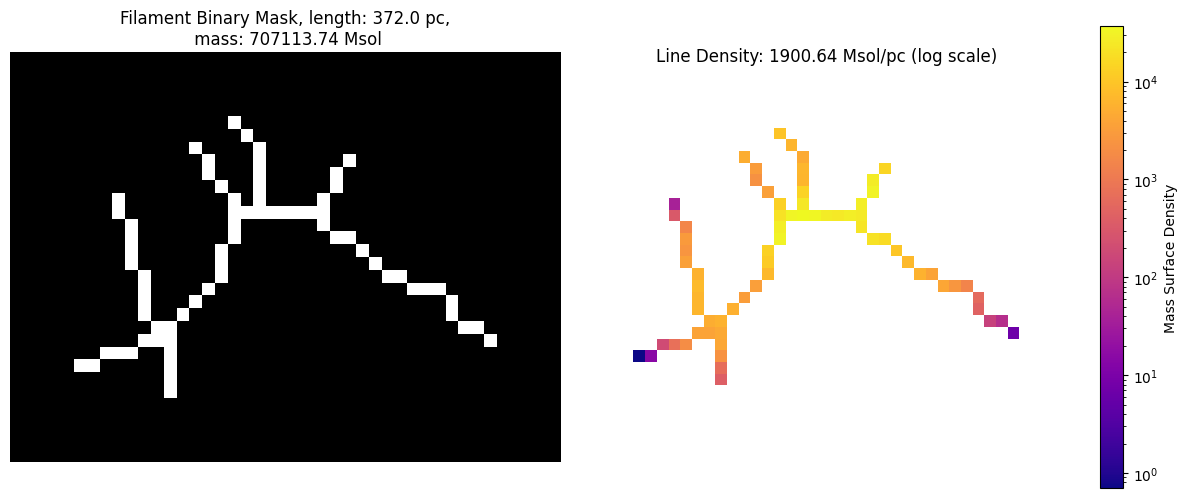

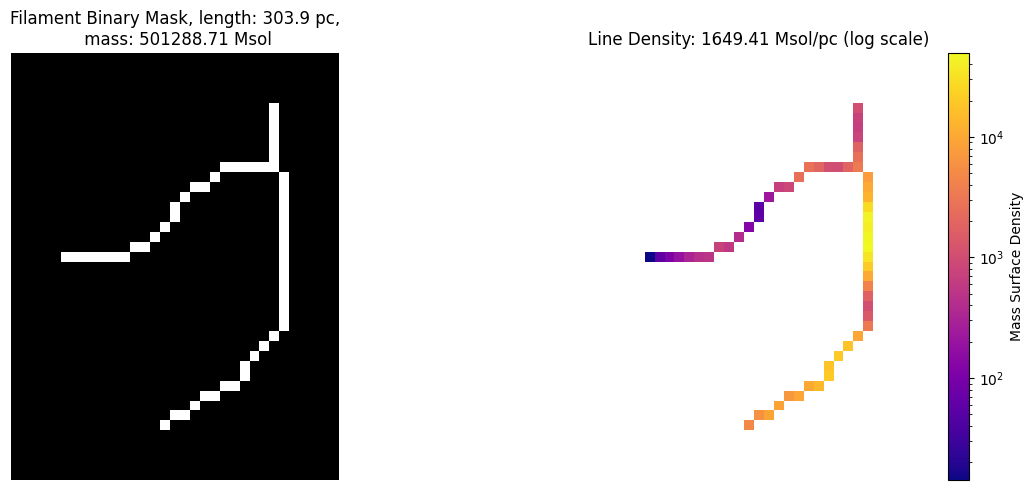

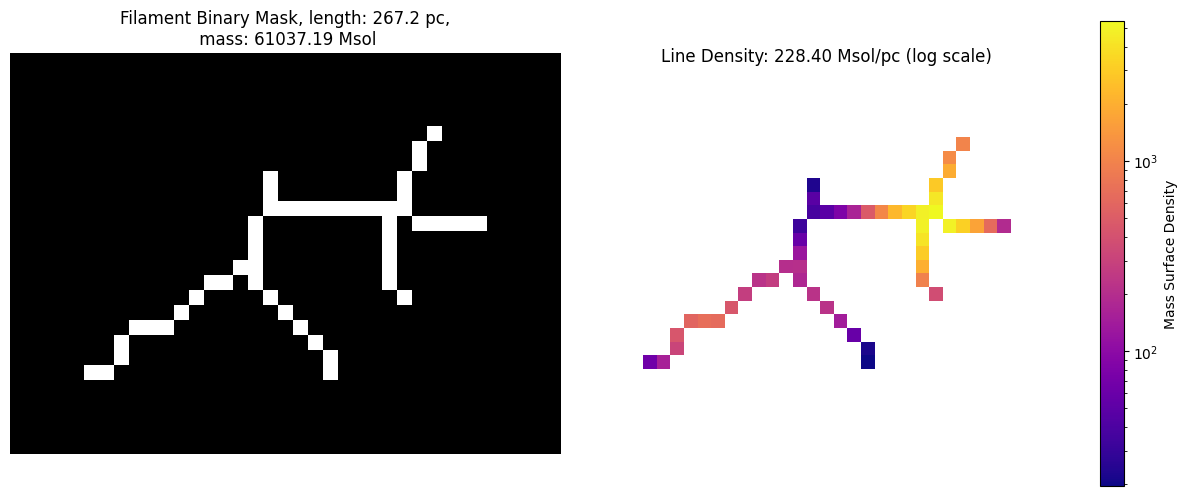

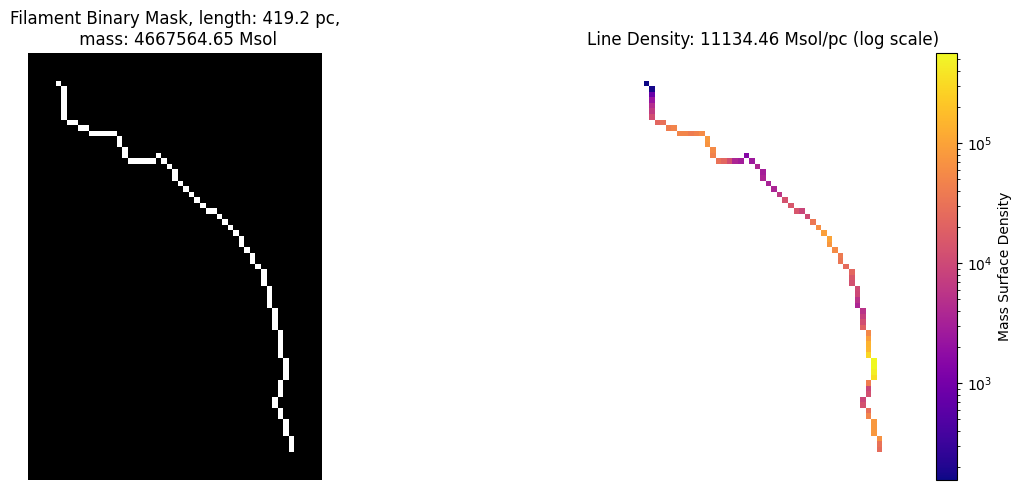

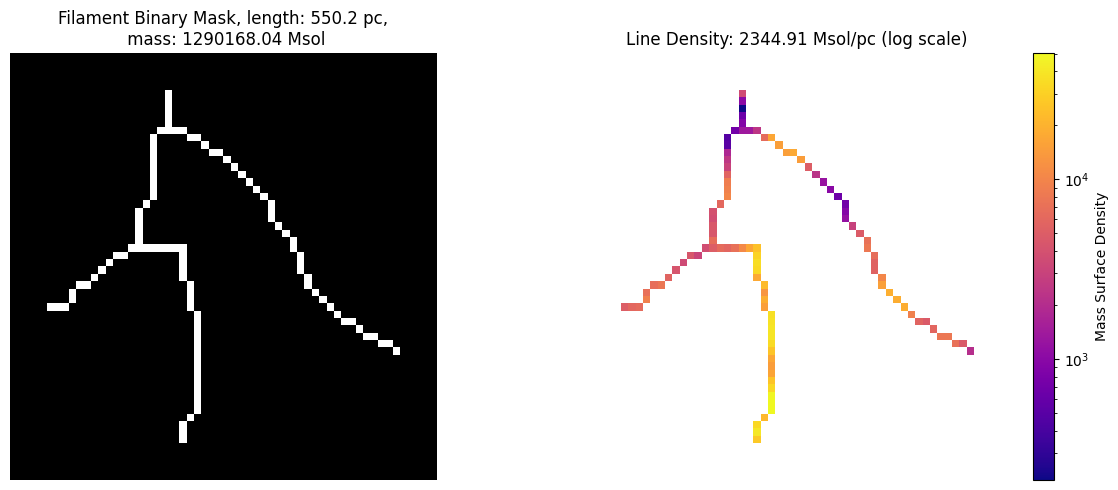

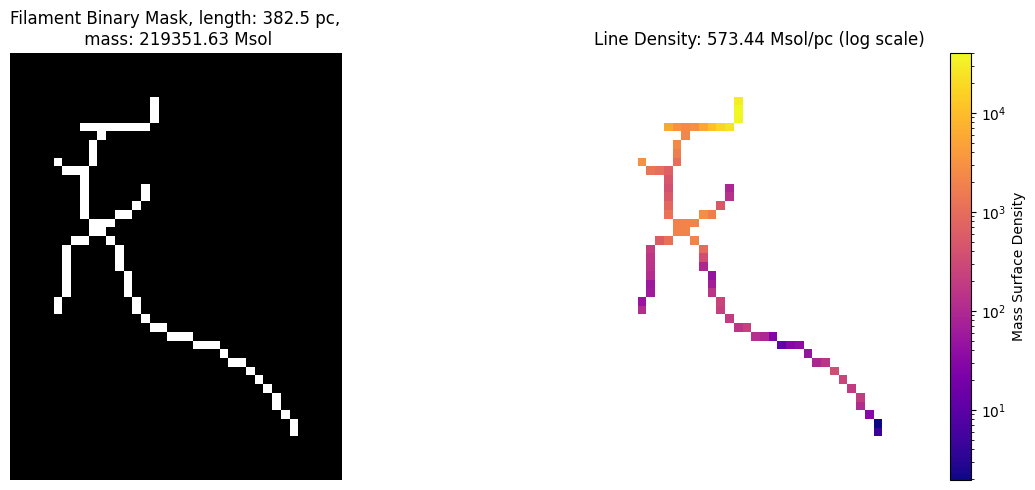

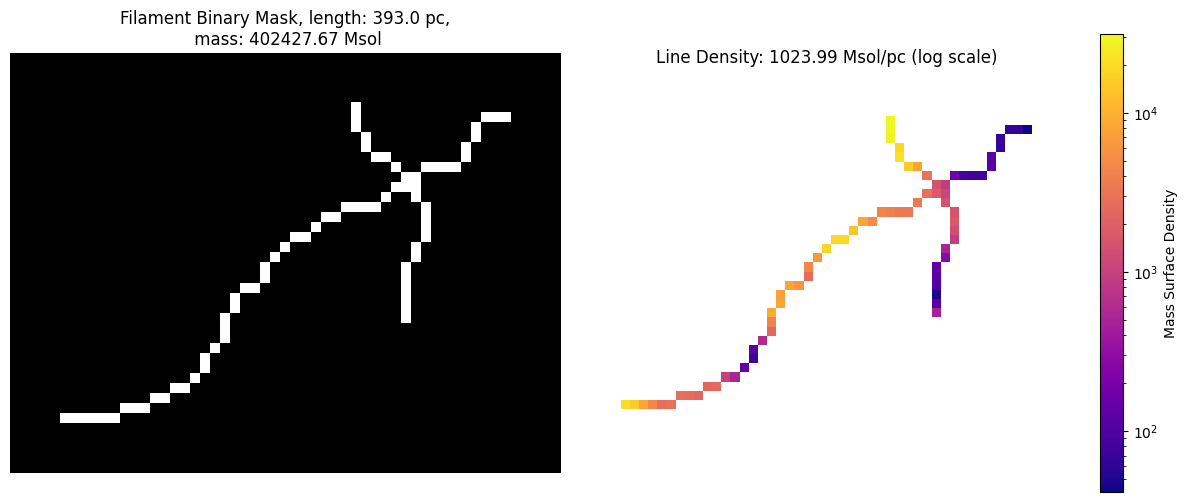

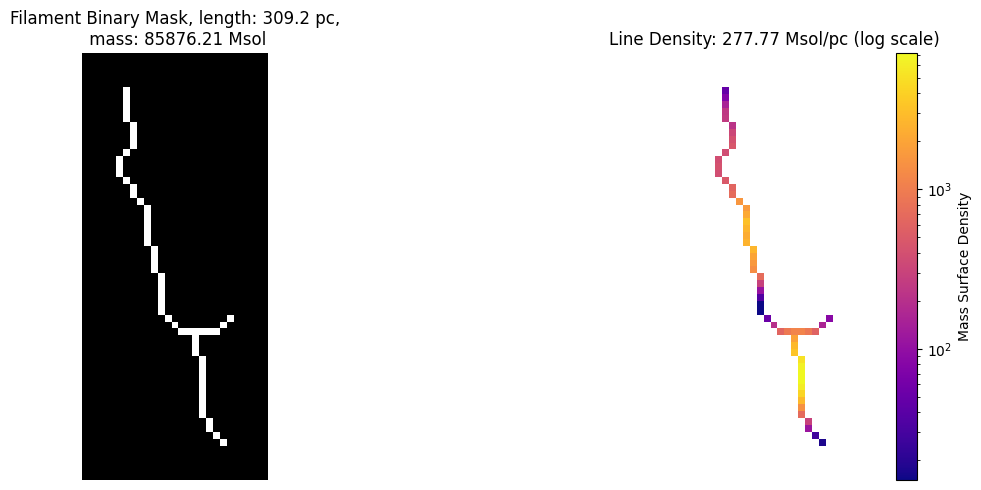

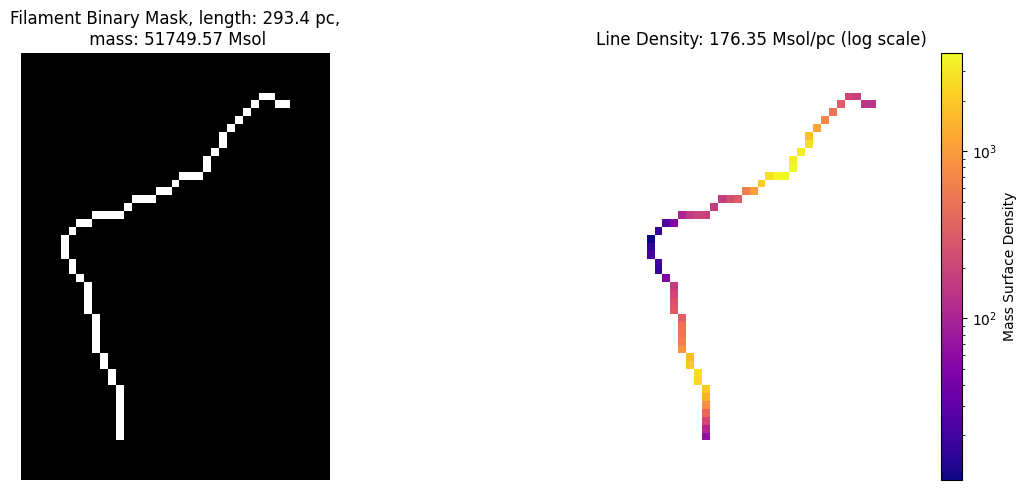

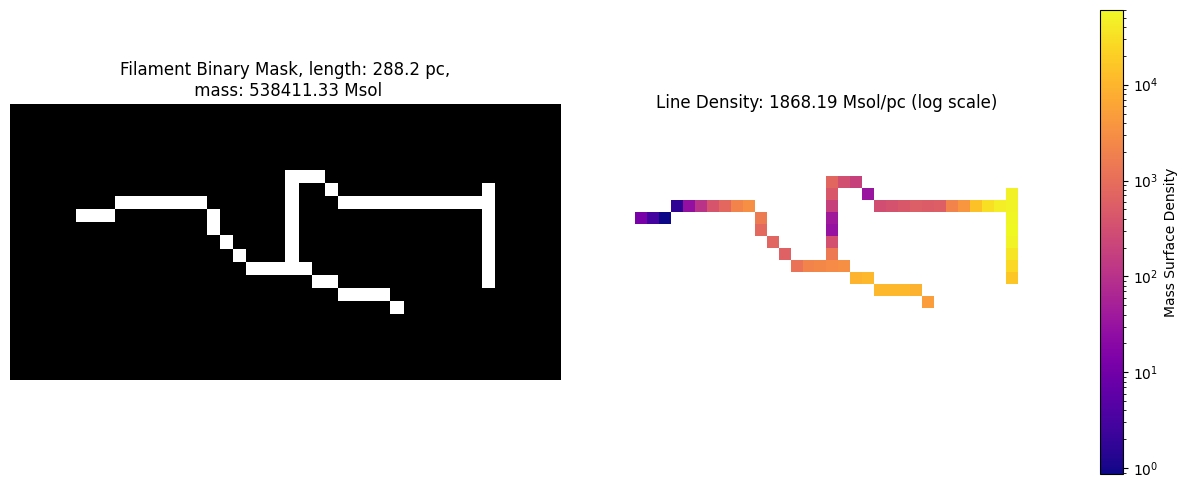

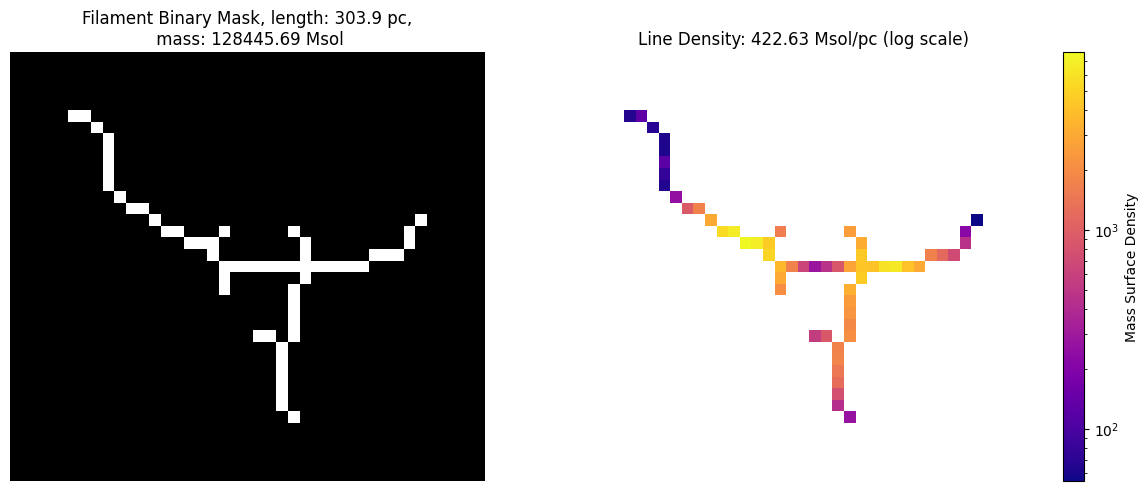

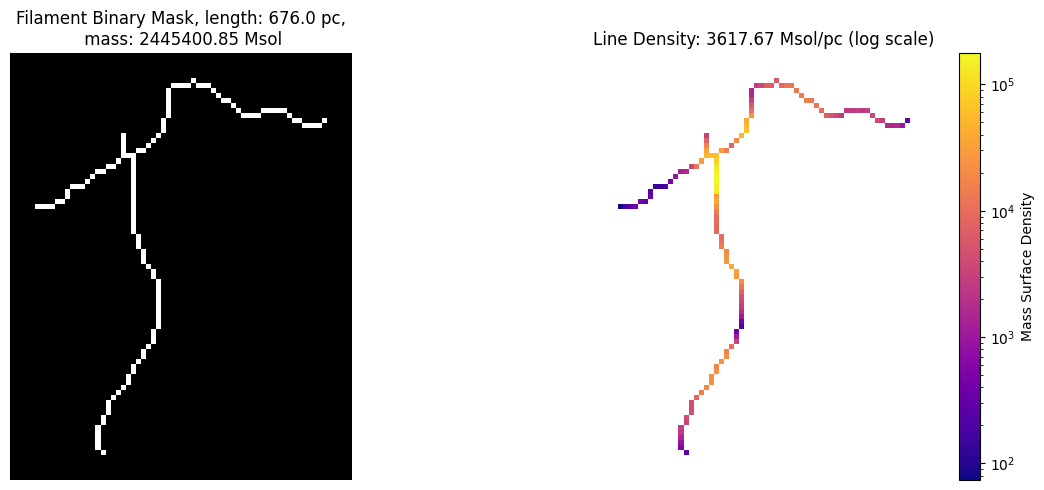

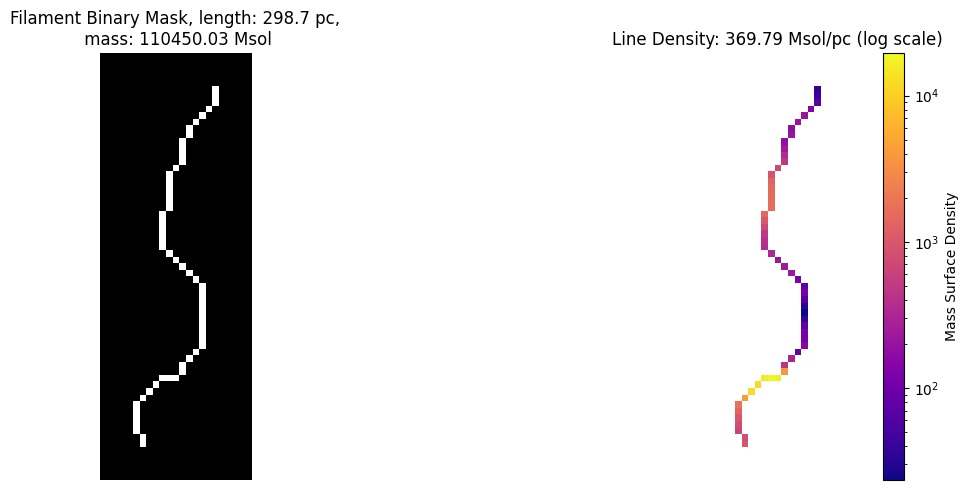

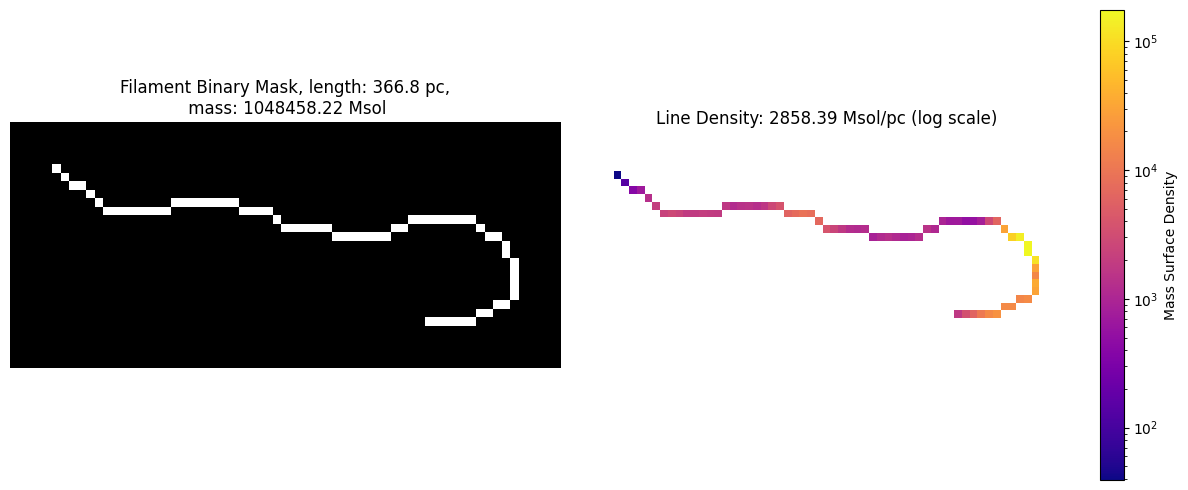

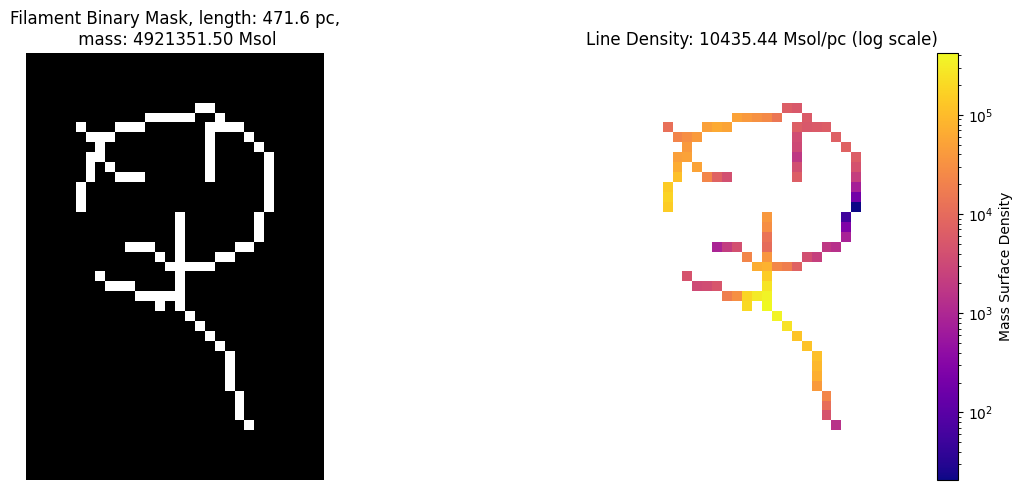

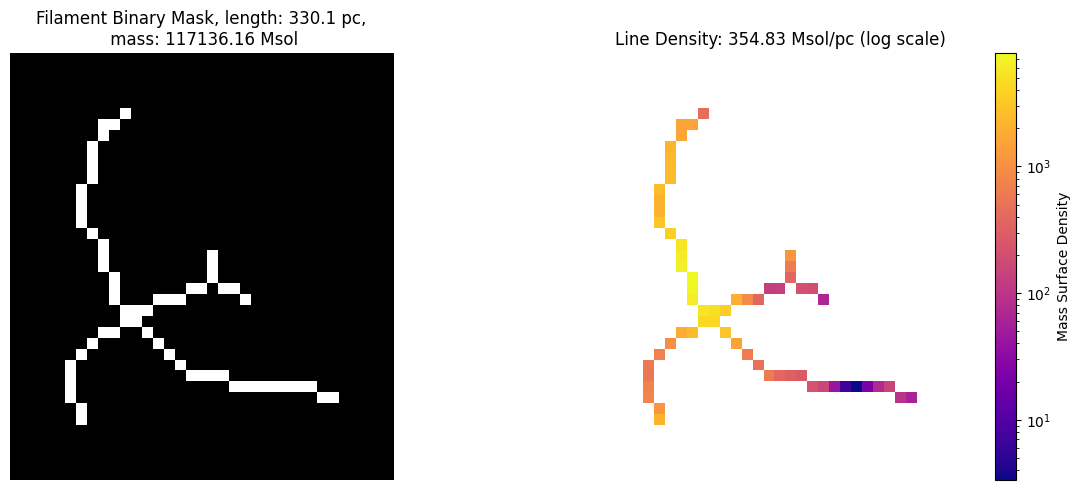

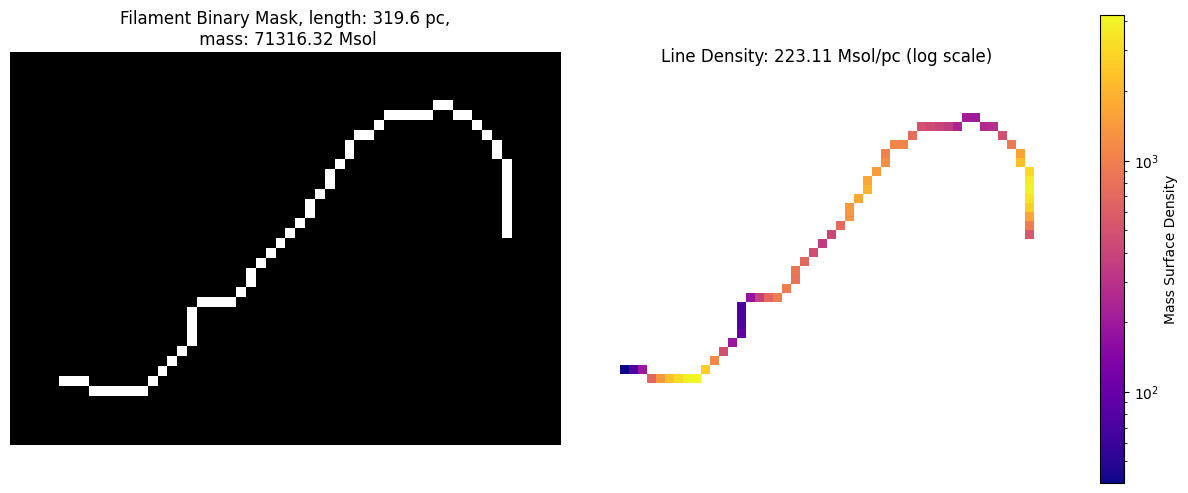

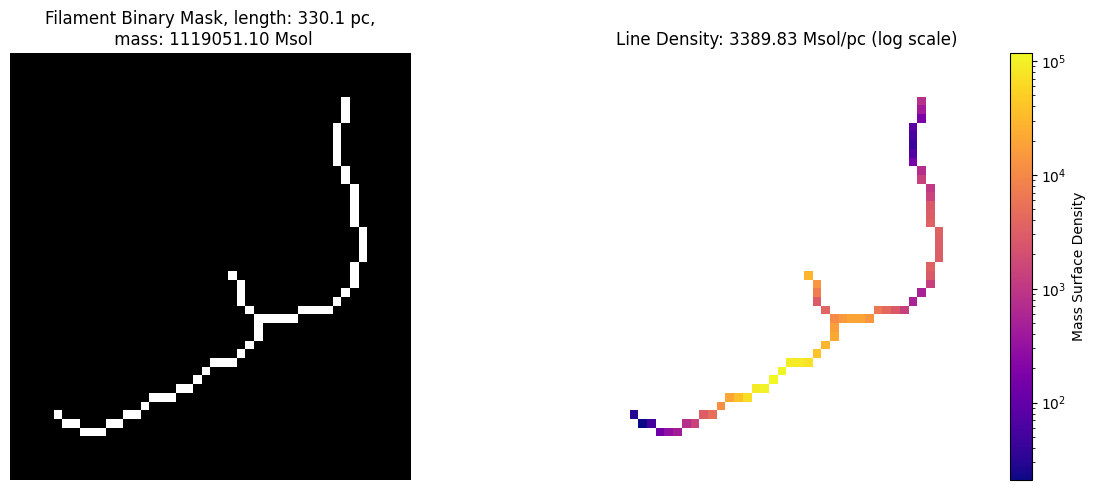

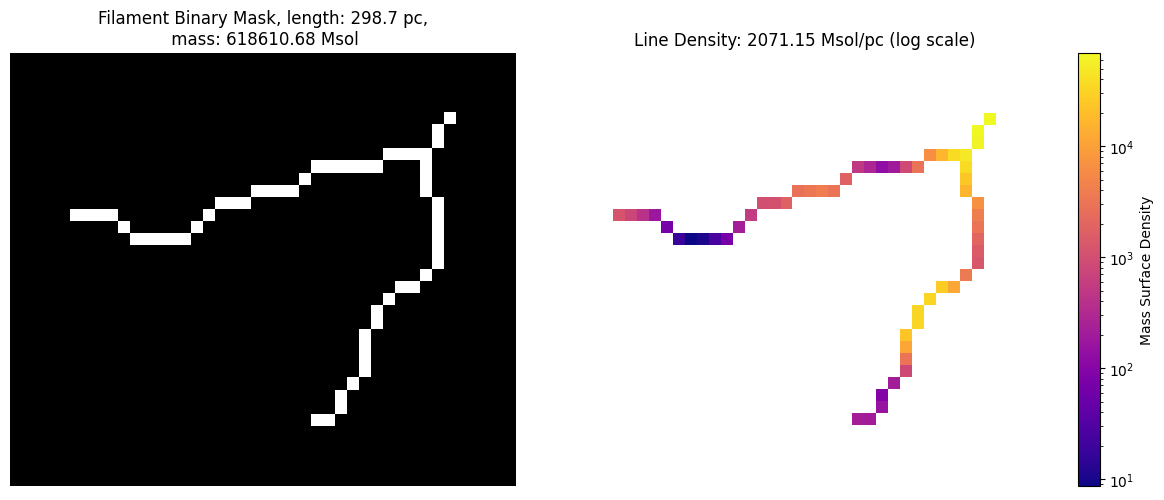

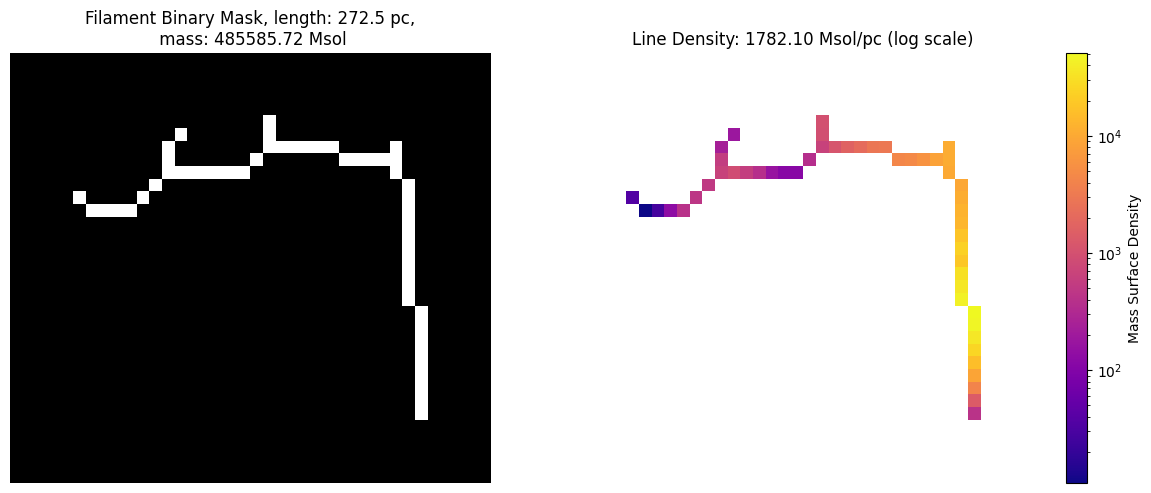

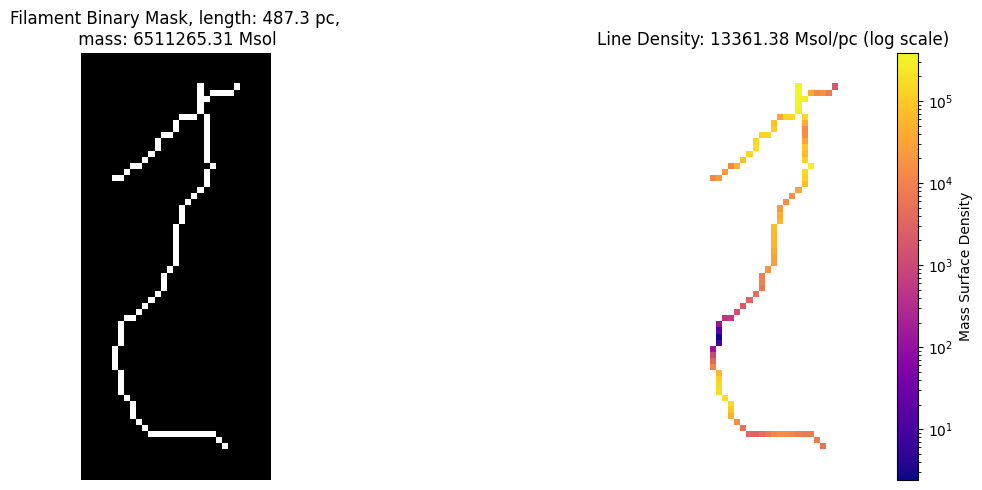

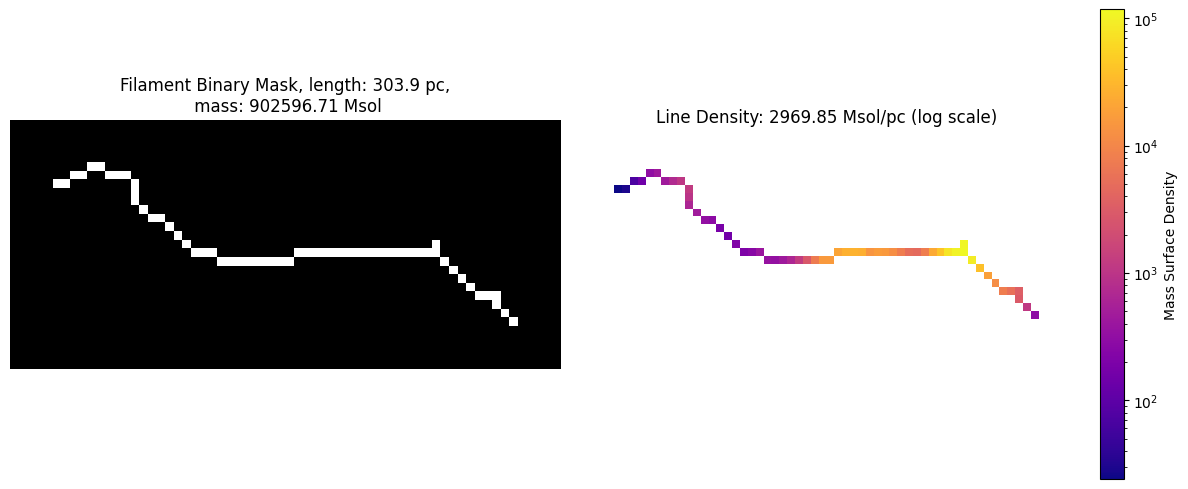

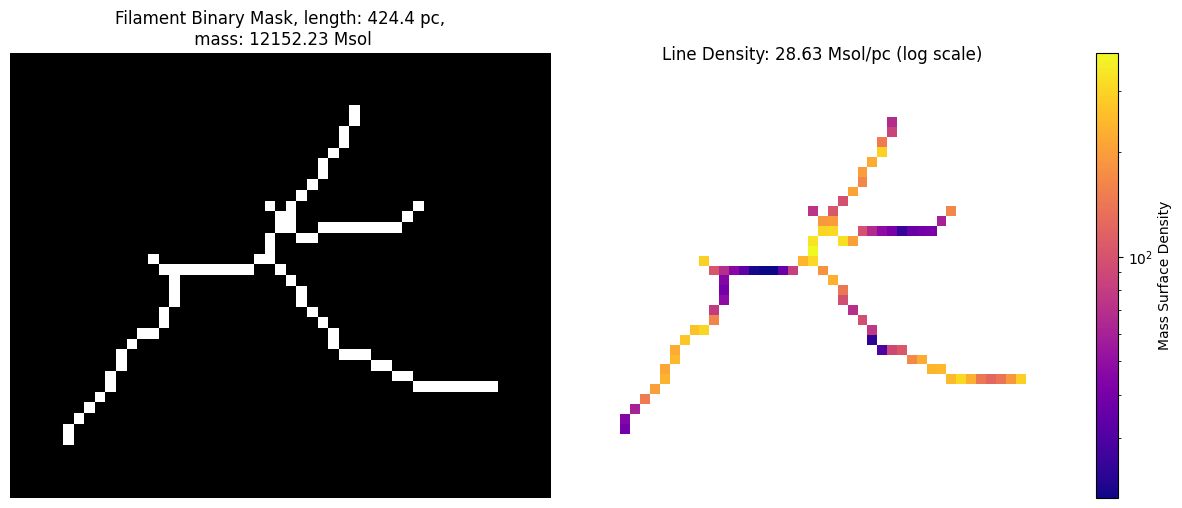

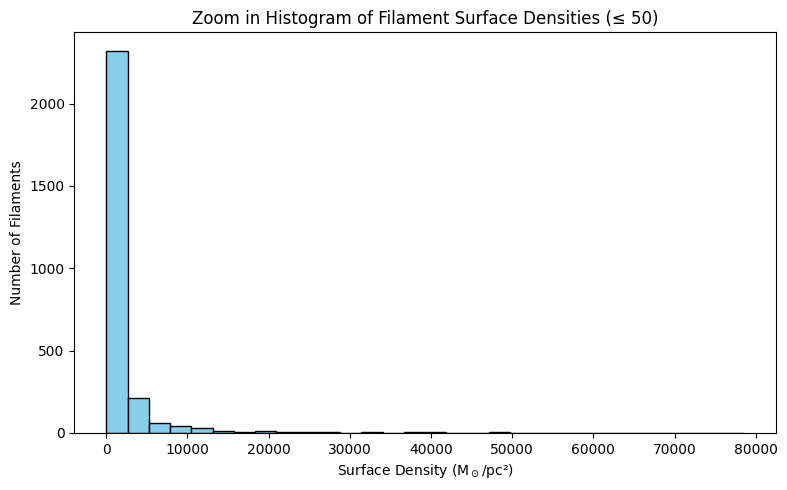

Average Surface Density (all filaments contribute equally): 1657.66 Msol/pc length
Surface Density Median: 378.28 Msol/pc length
Surface Density Standard Deviation: 4404.00 Msol/pc
-------------------------------------------------------------------------------------------------------------
Average Surface Density (all filaments contribute equally): 1479.57 Msol/pc length
Surface Density Median: 377.14 Msol/pc length
Surface Density Standard Deviation: 3710.47 Msol/pc


In [ ]:
Line_Density = []
restricted_density = []

for fil_id, pix_list in segment_info.items():
    mass_sum = []
    fil_length = len(pix_list)
    img = np.zeros_like(Molecular_Mass)
    centers_mask = np.zeros_like(Molecular_Mass)

    x_coords = []
    y_coords = []

    for values in pix_list:
        x = values[0]
        y = values[1]
        mass_sum.append(Molecular_Mass[y, x])
        img[y, x] = Molecular_Mass[y, x]
        centers_mask[y, x] = 1
        x_coords.append(x)
        y_coords.append(y)

    Line_Density.append(np.sum(mass_sum)/(5.24 * fil_length))

    if fil_length > 50:
        # Define bounding box with a small margin
        margin = 5
        x_min = max(min(x_coords) - margin, 0)
        x_max = min(max(x_coords) + margin + 1, img.shape[1])
        y_min = max(min(y_coords) - margin, 0)
        y_max = min(max(y_coords) + margin + 1, img.shape[0])

        # Crop to the bounding box
        cropped_mask = centers_mask[y_min:y_max, x_min:x_max]
        cropped_img = img[y_min:y_max, x_min:x_max]

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].imshow(cropped_mask, cmap='gray')
        axs[0].set_title(f"Filament Binary Mask, length: {5.24*fil_length:.1f} pc,\n mass: {np.sum(mass_sum):.2f} Msol")
        axs[0].axis('off')

        im = axs[1].imshow(cropped_img, cmap='plasma', norm='log')
        axs[1].set_title(f"Line Density: {Line_Density[-1]:.2f} Msol/pc (log scale)")
        axs[1].axis('off')

        cbar = fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
        cbar.set_label('Mass Surface Density')

        plt.tight_layout()
        plt.show()
    if fil_length > 20 and fil_length < 40:
        restricted_density.append(np.sum(mass_sum)/(5.24 * fil_length))

    
plt.figure(figsize=(8, 5))
plt.hist(Line_Density, bins=30, color='skyblue', edgecolor='black')
plt.title("Zoom in Histogram of Filament Surface Densities (≤ 50)")
plt.xlabel("Surface Density (M$_\odot$/pc²)")
plt.ylabel("Number of Filaments")
plt.tight_layout()
plt.show()

print(f"Average Surface Density (all filaments contribute equally): {np.mean(Line_Density):.2f} Msol/pc length")
print(f"Surface Density Median: {np.median(Line_Density):.2f} Msol/pc length")
print(f"Surface Density Standard Deviation: {np.std(Line_Density):.2f} Msol/pc")
print('-------------------------------------------------------------------------------------------------------------')
print(f"Average Surface Density (all filaments contribute equally): {np.mean(restricted_density):.2f} Msol/pc length")
print(f"Surface Density Median: {np.median(restricted_density):.2f} Msol/pc length")
print(f"Surface Density Standard Deviation: {np.std(restricted_density):.2f} Msol/pc")